### PROGRAM NAME: Reduced-Functioned Headset (FFH), Downstream (DS) Traffic Modeling
### PROJECT:               MXR Traffic Pattern Recognition and Modeling
### DESCRIPTION

- This Python script processes and analyzes the downstream traffic captures from the MXR rendering machine to the Hololens2 node in the format of UDP messages.

### PROGRAMMER: YONGKANG LIU (FDA/CDRH/OSEL/DBP, yongkang.liu@fda.hhs.gov)
### Python-VERSION: 3.8.5 (checked by running sys.version_info)
### UPDATES

- 08/02/2023, Version 0.5, cleaned the code and add intermediate steps to include results for analysis decisions.
- 06/28/2024, Version 1.0.


## FDA software disclaimer
#### *This software and documentation (the "Software") were developed at the Food and Drug Administration (FDA) by employees of the Federal Government in the course of their official duties. Pursuant to Title 17, Section 105 of the United States Code, this work is not subject to copyright protection and is in the public domain. Permission is hereby granted, free of charge, to any person obtaining a copy of the Software, to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, or sell copies of the Software or derivatives, and to permit persons to whom the Software is furnished to do so. FDA assumes no responsibility whatsoever for use by other parties of the Software, its source code, documentation or compiled executables, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic. Further, use of this code in no way implies endorsement by the FDA or confers any advantage in regulatory decisions. Although this software can be redistributed and/or modified freely, we ask that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.*


Through the earlier exploration on the DL data, a traffic pattern was observed.


The major DL traffic messages, i.e., with prefix "80:23", occured in bursts, which always 

- start with a small message with prefix "80:23:00:00" and 

- continue with a sequence of packets of big size (> 1000 bytes) with a message flag "05:00" and 

- concluded with a middle size message (400-800 bytes) flagged as "05:02". 

Note that in each burst session, one or more of the three parts may be missing. It mainly depends on the separation interval length to serve as a rough criterion in identifying the start and end of each burst.

### Step 0. Load system libraries and pre-defined functions

In [1]:
import sys
sys.version_info

import pandas as pd
import fnmatch
import os
import csv

import matplotlib.pyplot as plt
import numpy as np

# Plot function with x boundary limits
def scatterplot(x_data, y_data, x_xlim=[0, 0], x_label="", y_label="", \
                title="", color = "r", yscale_log=False, figSave=False, fig_index=""):

    plt.figure()
    # Create the plot object
    _, ax = plt.subplots()

    # Plot the data, set the size (s), color and transparency (alpha)
    # of the points
    ax.scatter(x_data, y_data, s = 5, color = color, alpha = 0.75, marker='.')

    if yscale_log == True:
        ax.set_yscale('log')

    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if x_xlim[0]<x_xlim[1]:        
        ax.set_xlim(x_xlim[0], x_xlim[1])
        
#     ax.set_xticks(np.arange(x_xlim[0], x_xlim[1], round((x_xlim[1]-x_xlim[0])/10)+1))
#     arr_time = np.arange(0, 700, step = 20)
#     ax.set_xticks(arr_time)
    
    
#     ax.set_xticks(np.arange(0, 690, step=30))
    
    if figSave:
        plt.rcParams["figure.figsize"] = [12.00, 8.0]
        plt.rcParams["figure.autolayout"] = True
        #plt.savefig('test_'+fig_index+'.png', bbox_inches='tight')
        plt.savefig('test_'+fig_index+'.svg', format='svg', dpi=1200)

### Step 1. Load Traffic Capture data from CSV file(s)

In [2]:
listFile = []

file_path = 'dl_filtered.csv'

pcap_start_time = 0

# If the csv file is found and the file full path is saved in a variable, filePath
with open(file_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    real_row_count = 0
    stream_dir_list = []
    ana_mat = []
    for row in csv_reader:
        if line_count == 0: # the first row
            cols = {k: v for v, k in enumerate(row)} # save column names into a dict {key:value}={columnName:index}
#             cols["stream_id"]=len(cols) # add a new column storing IP stream ID (direction)
#             cols["ip.len.eqv"]=cols["stream_id"]+1 # add one more new column storing the equivalent IP length, which is\
            # a theoretical value showing the IP packet length needed to contain a single Application Layer PDU
            print(cols)
        else:
            if line_count == 1: #Get the start time of the PCAP data
                pcap_start_time = float(row[cols["frame.time_epoch"]])
                print(pcap_start_time)
                
            # we can access row's element by calling the column name, e.g., row[cols['column1_name']]
            # If the capture is an IP packet and is not in the banned IP range
            if row[cols["ip.proto"]]!="" \
                and row[cols["ip.dst"]]!="255.255.255.255" \
                and row[cols["ip.dst"]]!="239.255.255.250" \
                and row[cols["ip.dst"]]!="224.0.0.251": 
                #print(row)
                #print(type(row))
#                 stream_dir = row[cols["ip.src"]] + "-->" + row[cols["ip.dst"]]
#                 if stream_dir not in stream_dir_list:
#                     stream_dir_list.append(stream_dir)
                
                row_tmp = row.copy()
                row_tmp[cols["frame.time_epoch"]] = float(row_tmp[cols["frame.time_epoch"]])-pcap_start_time
#                 row_tmp.append(stream_dir_list.index(stream_dir)) #corresponding to cols["stream_id"]
                
#                 row_tmp.append(0) # corresponding to cols["ip.len.eqv"]
                ana_mat.append(row_tmp) 
                real_row_count += 1
                
                
            #if real_row_count > 20:
                #break
            
        line_count += 1

pcap_end_time = ana_mat[-1][cols["frame.time_epoch"]]

print('total pcap pkts: ', len(ana_mat))

print('PCAP starts at ', pcap_start_time)
print('PCAP period length (sec): ', pcap_end_time)

print(ana_mat[31561][cols["data.data"]][:40])

print(ana_mat[31561][cols["data.data"]][6:11])

print(ana_mat[31561][cols["data.data"]][30:38])

{'frame.number': 0, 'frame.time_epoch': 1, 'eth.type': 2, 'ip.proto': 3, 'ip.len': 4, 'ip.src': 5, 'ip.dst': 6, 'tcp.flags': 7, 'tcp.segment': 8, 'tcp.analysis.acks_frame': 9, 'udp.stream': 10, 'udp.srcport': 11, 'udp.dstport': 12, 'udp.length': 13, 'ssl.record.version': 14, 'ssl.record.length': 15, 'ssl.record.opaque_type': 16, 'data.len': 17, 'data.data': 18}
1662578431.800264
total pcap pkts:  105617
PCAP starts at  1662578431.800264
PCAP period length (sec):  683.258857011795
80:23:47:14:00:00:00:00:e0:6a:05:00:04:f
47:14
05:00:04


### Step 2. Data Exploration

#### Overview of the DL traffic associated with XR content rendered remotely

There are multiple message types that can be distinguished by the hex digitals at the beginning of application messages.

We keep three most frequent ones that also occupy the majority of the total traffic load. 

In [3]:
# define new columns at the right end
if "data.type" not in cols: # store the major message type, i.e., [0:5] with the first 4 digits at the message beginning
    cols["data.type"] = len(cols)
    
if "data.type.second" not in cols: # store the secondary message type, i.e., [6:11] with the next 4 digits following the major type 
    cols["data.type.second"] = len(cols)
    
if "data.type.sub" not in cols: # store the secondary message type, i.e., [30:38] with 6 digits, used by "80:23"
    cols["data.type.sub"] = len(cols) 
    
if "data.seg.idx" not in cols: # store the burst/segment index for "80:23" messages
    cols["data.seg.idx"] = len(cols)
    
if "data.seg.tap.idx" not in cols: # store the index for "80:23" messages within a burst/seg
    cols["data.seg.tap.idx"] = len(cols)
    
if "data.type.name" not in cols: # store the index for "80:23" messages within a burst/seg
    cols["data.type.name"] = len(cols)
    
   
    
for i in ana_mat:
    row_data_prefix = i[cols["data.data"]][:38]  # truncate the original data sequence (keep only first four pairs)
    i[cols["data.data"]] = row_data_prefix
    
    i.append(row_data_prefix[:5]) # "data.type"
    i.append(row_data_prefix[6:11]) # "data.type.second"
    i.append(row_data_prefix[30:38]) # "data.type.sub"
    i.append(-1) # initial value for "data.seg.idx", -1 means NA
    i.append(-1) # initial value for "data.seg.tap.idx", -1 means NA
    i.append("NA") # initial value for "data.type.name"
    

# check all unique "data.type" and find the population
msg_type_dict = {}
type_id = 0
type_ins_count = [0 for i in range(10)]
type_ins_byte_sum = [0 for i in range(10)]
for i in ana_mat:
    row_data_prefix = i[cols["data.type"]]
    row_data_len = i[cols["data.len"]]
    if row_data_prefix not in msg_type_dict:
        msg_type_dict[row_data_prefix] = type_id
        type_id += 1
    type_ins_count[msg_type_dict[row_data_prefix]] += 1
    type_ins_byte_sum[msg_type_dict[row_data_prefix]] += int(row_data_len)
    
sum_pkt_total = sum(type_ins_count)
sum_byte_total = sum(type_ins_byte_sum)   
for i in msg_type_dict:
    print("{}, {}, ratio:{}, sum_byte:{}, sum_byte_ratio:{}".format(i, type_ins_count[msg_type_dict[i]], type_ins_count[msg_type_dict[i]]/sum_pkt_total, \
                                                                    type_ins_byte_sum[msg_type_dict[i]], type_ins_byte_sum[msg_type_dict[i]]/sum_byte_total))   

80:66, 3, ratio:2.840451821203026e-05, sum_byte:1411, sum_byte_ratio:1.712616993831132e-05
80:64, 2, ratio:1.893634547468684e-05, sum_byte:49, sum_byte_ratio:5.947429673828877e-07
80:65, 689, ratio:0.006523571016029617, sum_byte:942660, sum_byte_ratio:0.011441640931288835
80:61, 24, ratio:0.0002272361456962421, sum_byte:891, sum_byte_ratio:1.0814611917105162e-05
80:68, 123, ratio:0.0011645852466932406, sum_byte:125243, sum_byte_ratio:0.0015201508870190817
80:23, 103844, ratio:0.9832129297366902, sum_byte:81258015, sum_byte_ratio:0.9862782237702694
80:00, 911, ratio:0.008625505363719855, sum_byte:38025, sum_byte_ratio:0.0004615326803007001
80:a3, 20, ratio:0.0001893634547468684, sum_byte:22234, sum_byte_ratio:0.0002698676558528801
6a:e0, 1, ratio:9.46817273734342e-06, sum_byte:4, sum_byte_ratio:4.855044631697043e-08


The frames with the prefix __"80:23"__ and __"80:65"__ dominate the traffic data so that we focus on characterizing their patterns in the model.

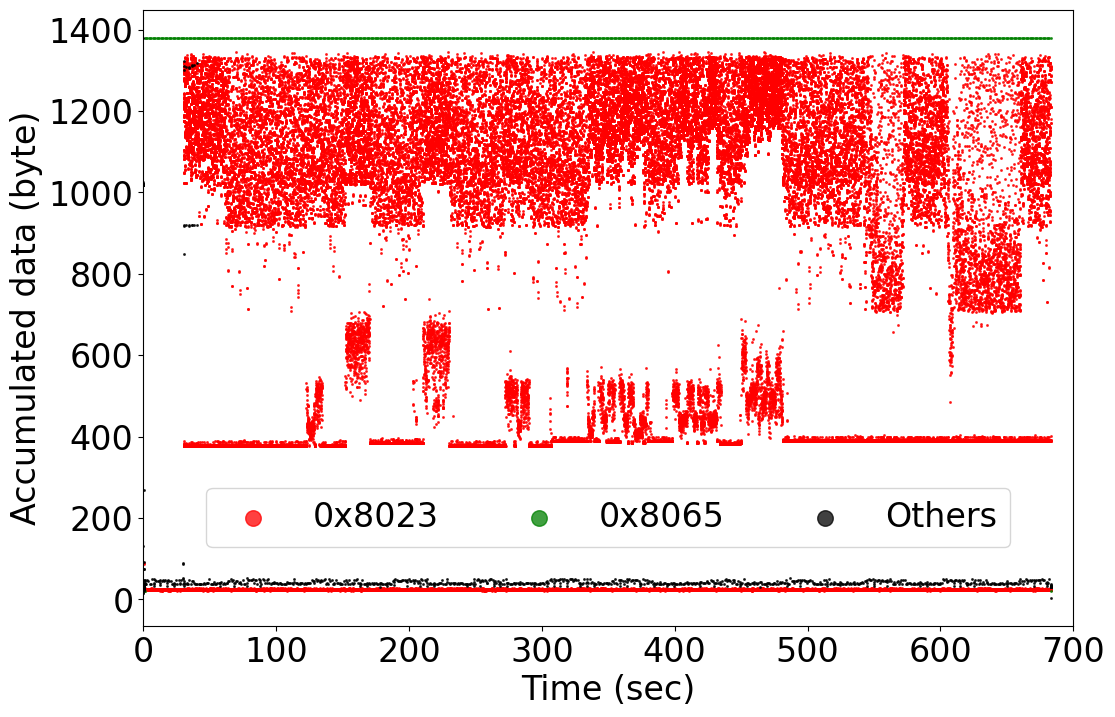

In [4]:
# list 0: 80:23; list 1: 80:65; list 2: other

list_lst_time_plot = [[],[],[]]
list_lst_pkt_plot = [[],[],[]]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:23"]:
        lst_ind = 0
    elif i[cols["data.type"]] in ["80:65"]:
        lst_ind = 1
    else:
        lst_ind = 2
        
    list_lst_time_plot[lst_ind].append(i[cols["frame.time_epoch"]])
    list_lst_pkt_plot[lst_ind].append(int(i[cols["data.len"]]))
    

colors = ['r', 'g', 'k']

labels = ['0x8023', '0x8065', "Others"]
    
markers = ['.', 'o', 'x']
    
_, ax = plt.subplots(figsize=(12, 8))

for i in range(3):
    # Create the plot object
    

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
    ax.scatter(list_lst_time_plot[i], list_lst_pkt_plot[i], s = 5, color = colors[i], label = labels[i], 
               alpha = 0.75, marker='.')


# ax.scatter(lst_time_sim, lst_size_accum, s = 5, color = 'b', label = 'Sim', alpha = 0.75, marker='o')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 24)
ax.set_ylabel("Accumulated data (byte)", fontsize = 24)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
# if x_xlim[0]<x_xlim[1]:
ax.set_xlim(0, 700)
ax.legend(fontsize = 24, bbox_to_anchor=(0.5, 0.1), loc='lower center', ncol=3, markerscale=10,)





    

### Overview of the DL traffic associated with XR content rendered remotely

There are multiple message types that can be distinguished by the first 4 hex digitals at the beginning of application messages.

We keep three most frequent ones that also occupy the majority of the total traffic load. 


The three major frame types are the frames with prefix of ["80:65", "80:23", "80:00"]. Hereafter, we will have them being examined individually.

## Type-specific analysis


First, we want to identify the one(s) with stable distributions that don't vary very much across different operation states.

### Case 1. 80:65

This type of messages was spotted from the start to the end during the measurement. It serves in the whole session.

689
689
Figure saved as  Packet TransmissionsData Type_80:65


<Figure size 640x480 with 0 Axes>

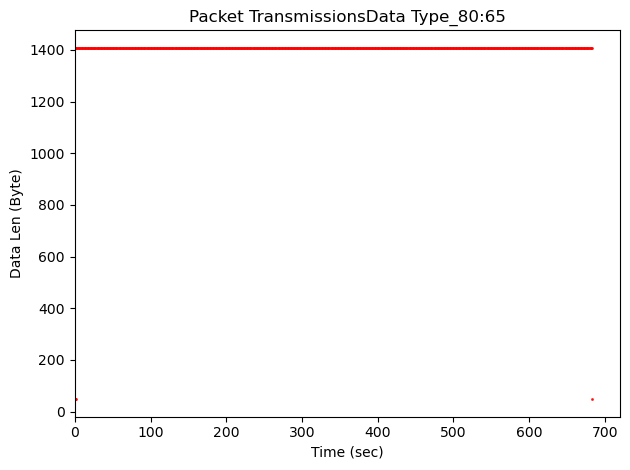

In [5]:
ana_mat_lean = []

lst_display_data_type = ["80:65"]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:65"]:
#     if i[cols["data.type"]] in ["80:65", "80:66", "80:64", "80:61", "80:68"]:
#     if i[cols["data.type"]] in ["80:65", "80:23", "80:00"]:
#     if i[cols["data.type"]] in ["80:23"] and i[cols["data.data"]][6:11] == "00:00":
        ana_mat_lean.append(i.copy())
        
len(ana_mat_lean)

timeline = []
len_list = []

for i in ana_mat_lean:
    #print(i[:])
#     if i[cols['stream_id']]==stream_id:
    timeline.append(i[cols['frame.time_epoch']])
    len_list.append(int(i[cols['ip.len']]))
        
print(len(timeline))
# print(stream_dir_list[stream_id])
print(len(timeline))

# pic_title = "Link: "+stream_dir_list[stream_id]
str_displayed_data_type =""
for i in lst_display_data_type:
    str_displayed_data_type += "_"
    str_displayed_data_type += i
    

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 720#pcap_end_time
scatterplot(timeline, len_list, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data Len (Byte)", title=pic_title, figSave=True, fig_index="")

[0.64, 11.2, 11.04, 11.04, 11.04, 11.04, 11.04, 11.04, 11.04, 11.04]
Figure saved as  Packet TransmissionsData Type_80:65


<Figure size 1200x800 with 0 Axes>

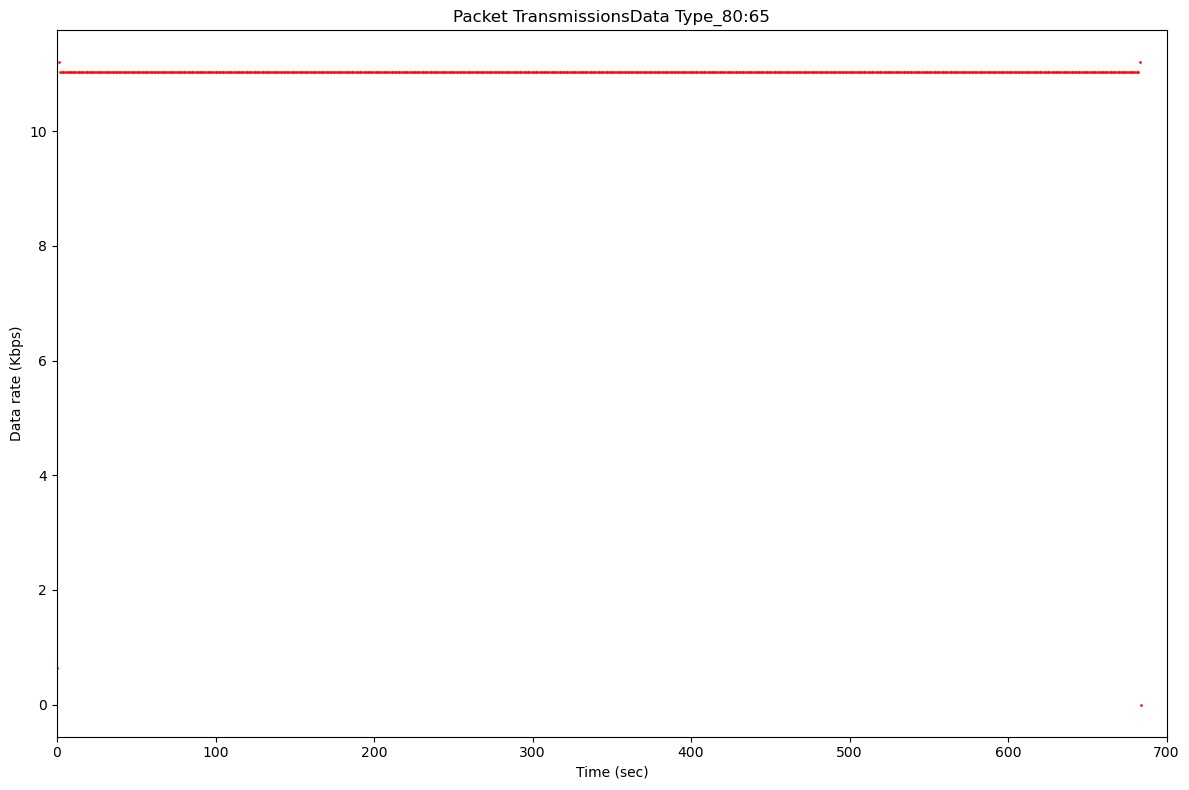

In [6]:
# Throughput of the selected data stream

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(ana_mat_lean[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_lean:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 700#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

688
688
Size > 200 frame counts:  683
Length > 0.8 sec frame counts:  682


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


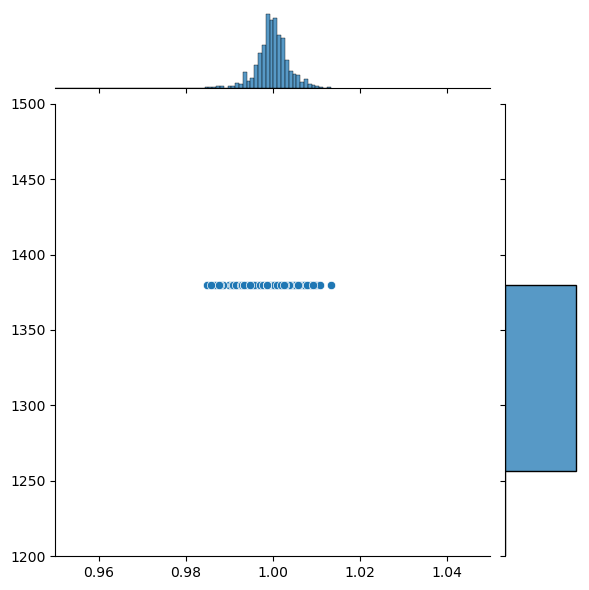

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for j in [0, 1, 2, 3]: # four size state

lst_frame_size = [int(ana_mat_lean[i][cols['data.len']]) for i in range(len(ana_mat_lean[1:]))]
print(len(lst_frame_size))

lst_next_frame_interval = [ana_mat_lean[i+1][cols['frame.time_epoch']]-ana_mat_lean[i][cols['frame.time_epoch']] for i in range(len(ana_mat_lean)-1)]
print(len(lst_next_frame_interval))

print("Size > 200 frame counts: ", len([i for i in lst_frame_size if i > 200]))

print("Length > 0.8 sec frame counts: ", len([i for i in lst_next_frame_interval if i > 0.8]))


# for i in range(len(lst_seg_time)):
#     tmp_time = lst_seg_time[i]
#     tmp_tap_count = lst_seg_tap_count[i]
#     if tmp_tap_count > 2 and tmp_time > 0.02 and tmp_time < 0.09:
#         lst_seg_time_trim.append(tmp_time)
#         lst_seg_tap_count_trim.append(tmp_tap_count)

# # Generate some test data
x = np.array(lst_next_frame_interval)
y = np.array(lst_frame_size)
sns.jointplot(x=x, y=y, xlim=[0.95, 1.05], ylim=[1200, 1500], kind='scatter')
# sns.jointplot(x=x, y=y, kind='scatter')
plt.show()

#### Observation

The above message type has an unique frame size 1380 bytes and inter-frame interval length around 1 sec. It can be viewed as some heart beat signals in DL at 1 Hz. The data rate is around 11+ kbps.

### Case 2. 80:00

This type of messages was also spotted from the start to the end during the measurement. It serves in the whole session.

Interested readers can repeat the steps shown in Case 1 to obtain the results (frame size, data rate, and distributions).

#### Observation

This stream didn't contribute much to the entire data rate since it only added less than 1 kbps in the DL. We will skipp modeling this stream in the traffic model. 

### Case 3. 80:23

This type of messages contain data for the rendered MXR content. Therefore, they are the real meat in this study. 

103844
103844
Figure saved as  Packet TransmissionsData Type_80:23


<Figure size 1200x800 with 0 Axes>

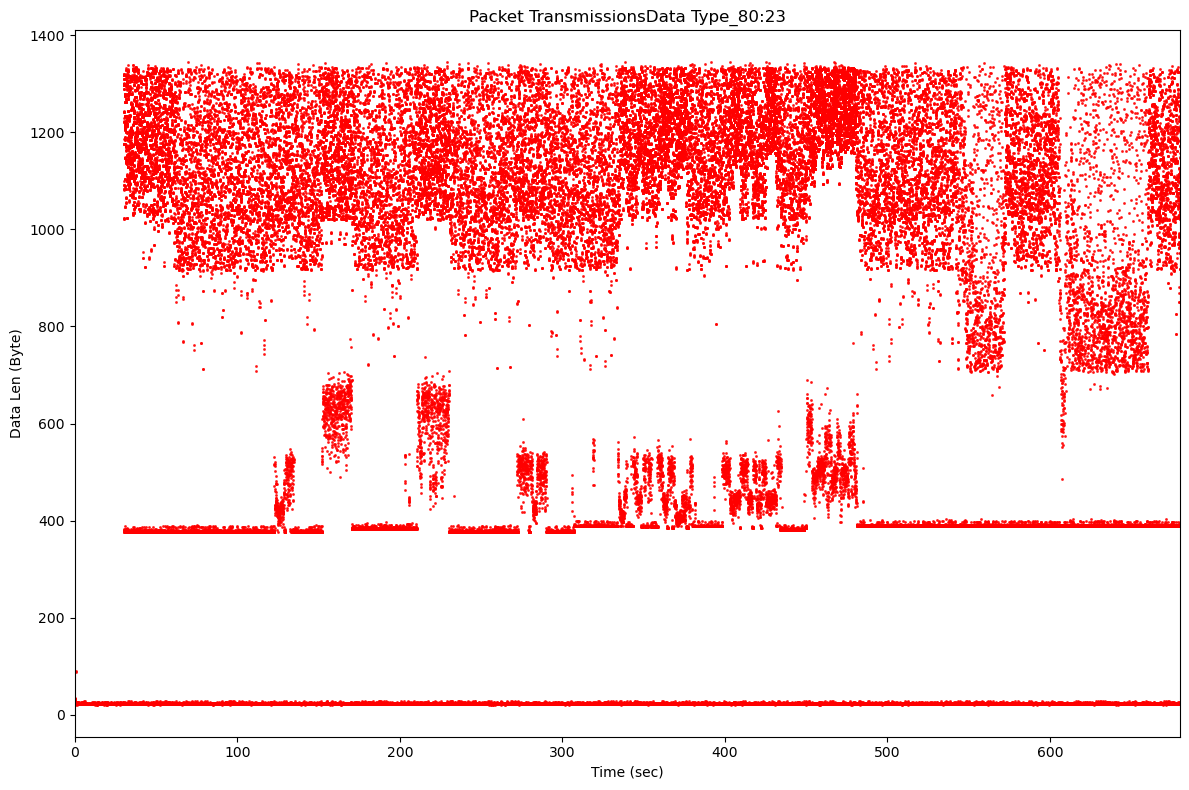

In [8]:
ana_mat_lean = []

lst_display_data_type = ["80:23"]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:23"]:
        ana_mat_lean.append(i.copy())
        
len(ana_mat_lean)

timeline = []
len_list = []

for i in ana_mat_lean:
    #print(i[:])
#     if i[cols['stream_id']]==stream_id:
    timeline.append(i[cols['frame.time_epoch']])
    len_list.append(int(i[cols['data.len']]))
        
print(len(timeline))
# print(stream_dir_list[stream_id])
print(len(timeline))

# pic_title = "Link: "+stream_dir_list[stream_id]
str_displayed_data_type =""
for i in lst_display_data_type:
    str_displayed_data_type += "_"
    str_displayed_data_type += i
    

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = 680  #pcap_end_time
scatterplot(timeline, len_list, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data Len (Byte)", title=pic_title, figSave=True, fig_index="")

[52.24, 1.76, 0.0, 0.0, 3.52, 0.0, 21.68, 5.36, 7.28, 7.92]
Figure saved as  Packet TransmissionsData Type_80:23
236.08 6560.8


<Figure size 1200x800 with 0 Axes>

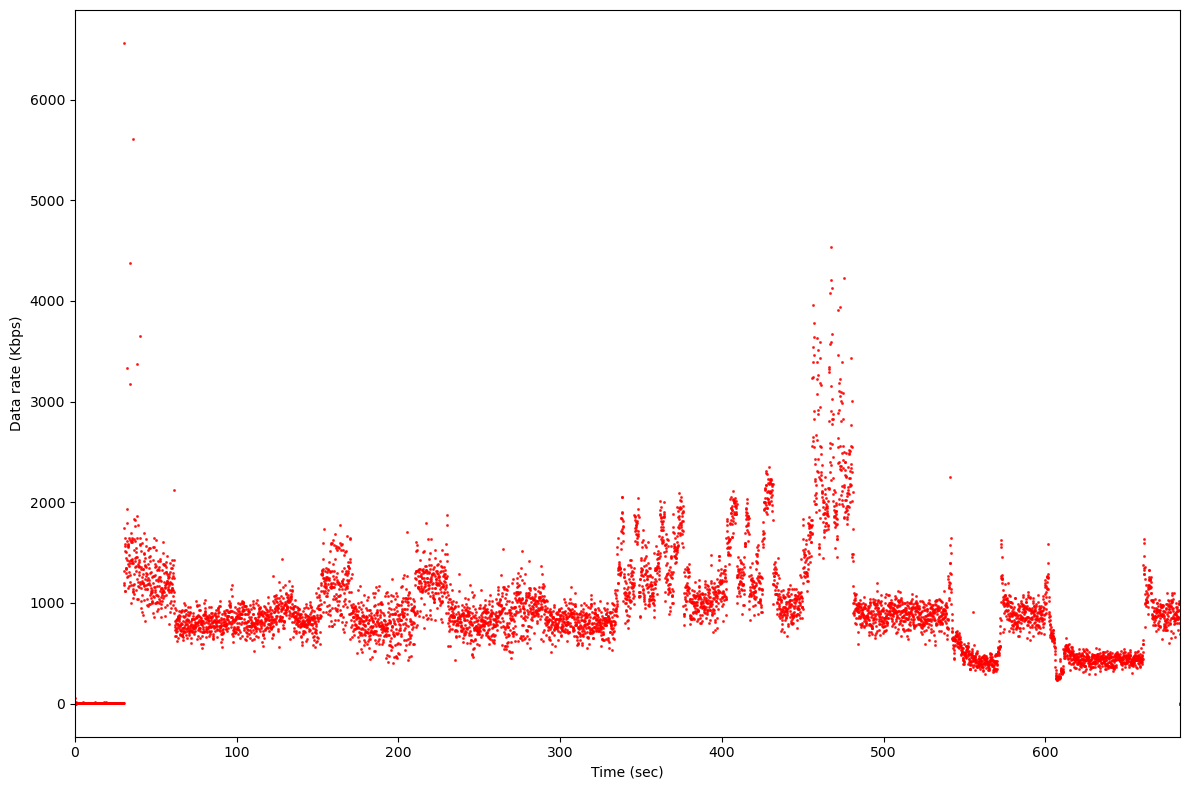

In [9]:
# Throughput of the selected data stream

import math

step = 0.1 #sec

start_time = 0
end_time = math.ceil(ana_mat_lean[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_lean:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0#600
x_max_display = pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title="", figSave=True, fig_index="")


print(min([i for i in lst_rate_kbps if i > 100]), max(lst_rate_kbps))




[52.24, 1.76, 0.0, 0.0, 3.52, 0.0, 21.68, 5.36, 7.28, 7.92]


(0.0, 700.0)

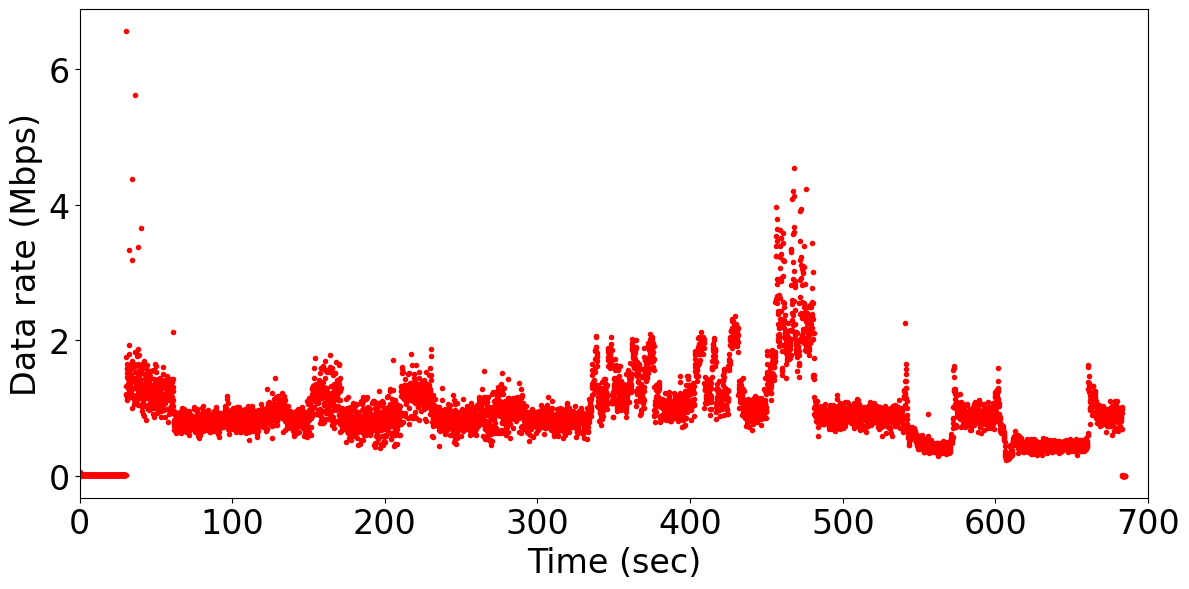

In [10]:
# Throughput of the selected data stream

import math

step = .1 #sec

start_time = 0
end_time = math.ceil(ana_mat_lean[-1][cols["frame.time_epoch"]]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_lean:
    len_tmp = int(i[cols["data.len"]])
    time_tmp = i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])

lst_rate_mbps = [i/1000 for i in lst_rate_kbps]
    
_, ax = plt.subplots(figsize=(12, 6))


ax.scatter(arr_time, lst_rate_mbps, s = 35, color = 'r', 
               alpha = 1, marker='.')




# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 24)
ax.set_ylabel("Data rate (Mbps)", fontsize = 24)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
ax.set_xlim(0, 700)
# if x_xlim[0]<x_xlim[1]:
# ax.set_ylim(0, 4000)
# ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.1), loc='lower center', ncol=3, markerscale=10,)




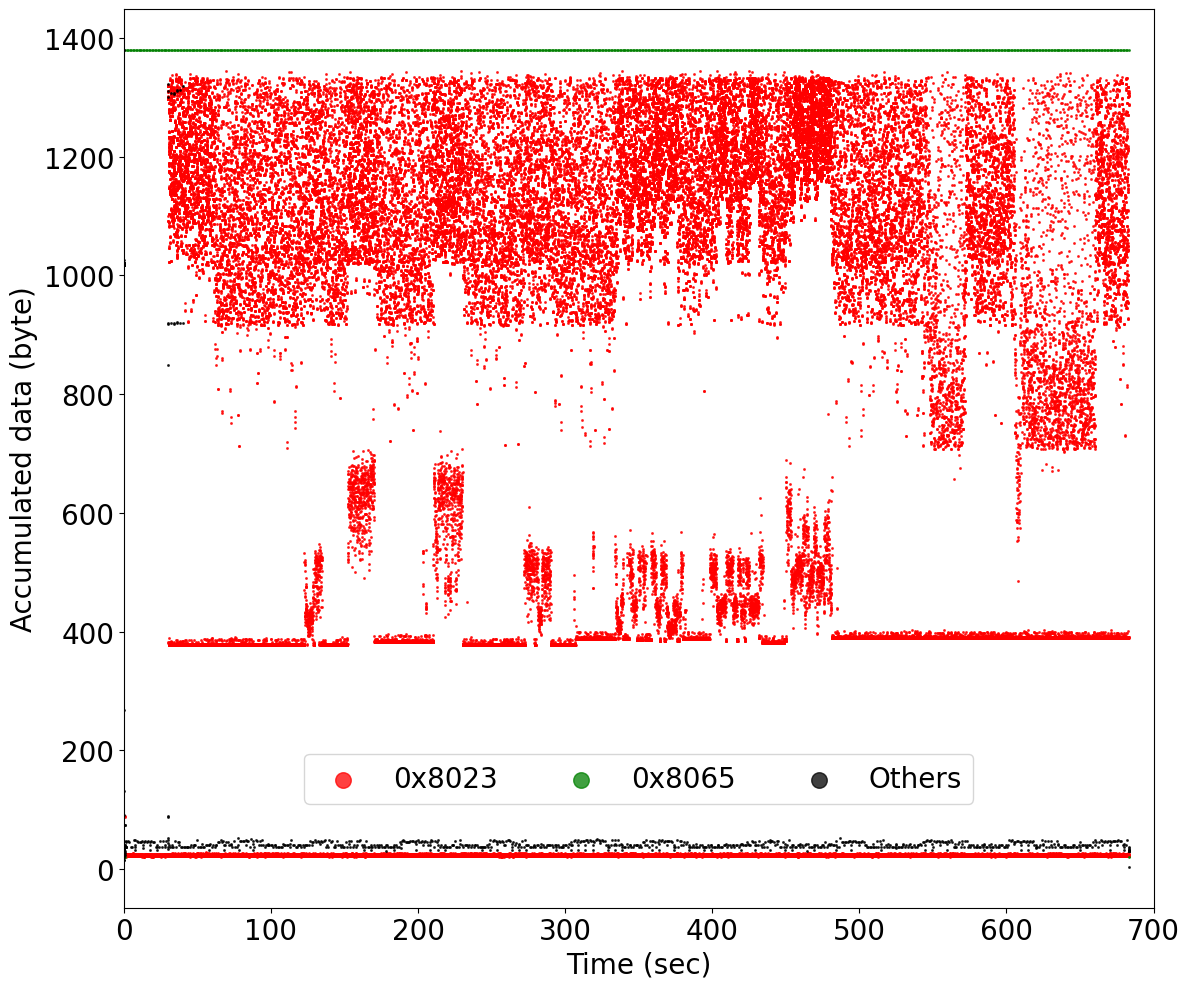

In [11]:
list_lst_time_plot = [[],[],[]]
list_lst_pkt_plot = [[],[],[]]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:23"]:
        lst_ind = 0
    elif i[cols["data.type"]] in ["80:65"]:
        lst_ind = 1
    else:
        lst_ind = 2
        
    list_lst_time_plot[lst_ind].append(i[cols["frame.time_epoch"]])
    list_lst_pkt_plot[lst_ind].append(int(i[cols["data.len"]]))
    

colors = ['r', 'g', 'k']

labels = ['0x8023', '0x8065', "Others"]
    
markers = ['.', 'o', 'x']
    
_, ax = plt.subplots(figsize=(12, 10))

for i in range(3):
    # Create the plot object
    

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
    ax.scatter(list_lst_time_plot[i], list_lst_pkt_plot[i], s = 5, color = colors[i], label = labels[i], 
               alpha = 0.75, marker='.')


# ax.scatter(lst_time_sim, lst_size_accum, s = 5, color = 'b', label = 'Sim', alpha = 0.75, marker='o')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 20)
ax.set_ylabel("Accumulated data (byte)", fontsize = 20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# if x_xlim[0]<x_xlim[1]:
ax.set_xlim(0, 700)
ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.1), loc='lower center', ncol=3, markerscale=10)




103843
103843
Length < 0.08 sec frame counts:  103840


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


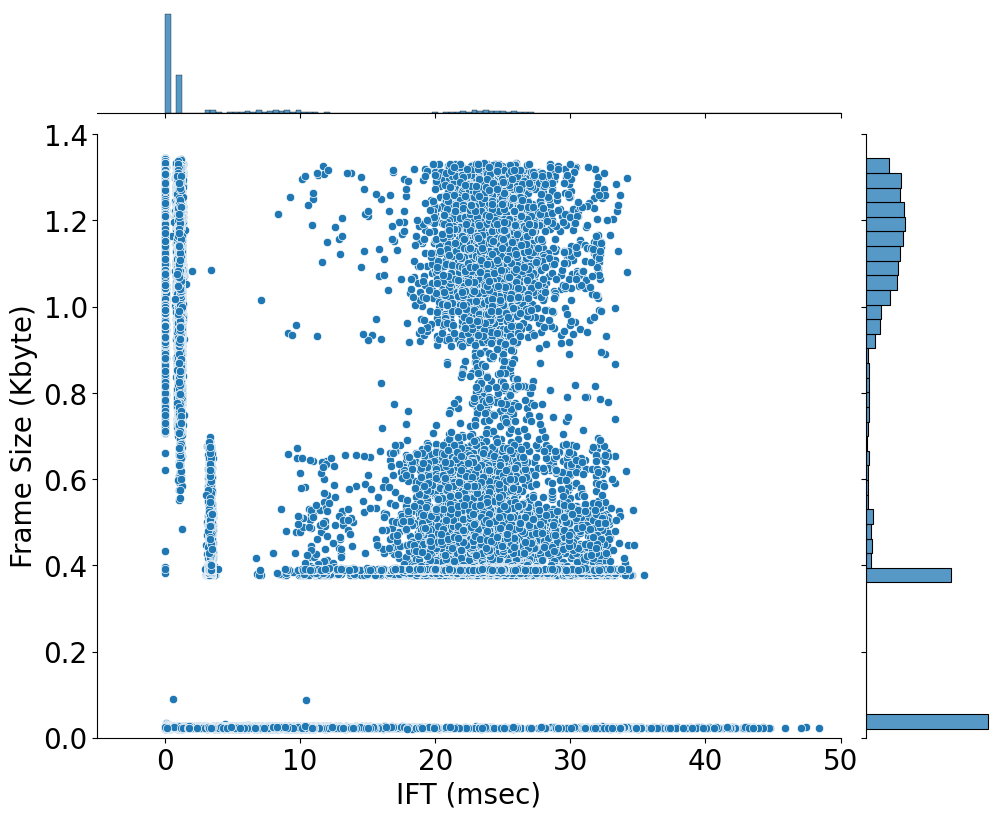

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for j in [0, 1, 2, 3]: # four size state

lst_frame_size = [int(ana_mat_lean[i][cols['data.len']]) for i in range(len(ana_mat_lean[1:]))]
print(len(lst_frame_size))

lst_next_frame_interval = [ana_mat_lean[i+1][cols['frame.time_epoch']]-ana_mat_lean[i][cols['frame.time_epoch']] for i in range(len(ana_mat_lean)-1)]
print(len(lst_next_frame_interval))

# print("Size < 100 frame counts: ", len([i for i in lst_frame_size if i < 100]))

# print("Length > 0.8 sec frame counts: ", len([i for i in lst_next_frame_interval if i > 0.8]))
print("Length < 0.08 sec frame counts: ", len([i for i in lst_next_frame_interval if i < 0.08]))

# for i in range(len(lst_seg_time)):
#     tmp_time = lst_seg_time[i]
#     tmp_tap_count = lst_seg_tap_count[i]
#     if tmp_tap_count > 2 and tmp_time > 0.02 and tmp_time < 0.09:
#         lst_seg_time_trim.append(tmp_time)
#         lst_seg_tap_count_trim.append(tmp_tap_count)

# # Generate some test data
x = np.array(lst_next_frame_interval)
y = np.array(lst_frame_size)

x_msec = [i*1000 for i in x]
y_k = [i/1000 for i in y]

# sns.set(rc={
#           'axes.labelsize':18,
#             'figure.figsize':(20.0, 20.0),
#             'xtick.labelsize':18,
#             'ytick.labelsize':18})


h = sns.jointplot(x=x_msec, y=y_k, xlim=[-5, 50], ylim=[0, 1400/1000], kind='scatter')

h.set_axis_labels('IFT (msec)', 'Frame Size (Kbyte)', fontsize=20)


h.fig.set_size_inches((10, 8)) 


# h.ax_joint.set_xticks([i*0.1 for i in range(11)])

# h.ax_joint.legend(ncol=3, loc="lower right", fontsize=14, title='k', title_fontsize=20)

for tick in h.ax_joint.get_xticklabels():        
#     tick.set_rotation(30)
    tick.set_fontsize(20)
    
for tick in h.ax_joint.get_yticklabels():        
#     tick.set_rotation(30)
    tick.set_fontsize(20)


# sns.jointplot(x=x, y=y, kind='scatter')
plt.show()

In [13]:
print("Size < 100 frame counts: ", len([i for i in lst_frame_size if i < 200]))

print("Length < 0.8 sec frame counts: ", len([i for i in lst_next_frame_interval if i < 0.08]))

Size < 100 frame counts:  20542
Length < 0.8 sec frame counts:  103840


#### The following is the burst-based pattern analysis

First, identify all possible bursts in the DL traffic with the message type of "80:23"


In [14]:
# Create a new matrix to store the data for analysis, inherit the columns from the copied one
ana_mat_burst = [] 
for i in ana_mat_lean:
    ana_mat_burst.append(i.copy())
    
# safety check
for i in ana_mat_burst:
    if i[cols["data.type"]] != "80:23":
        print("Alert!! Unrecognized message types: ", i[cols["data.type"]])
        
# 
len_ana_mat_burst = len(ana_mat_burst)

lst_frame_states = ["head", "core", "tail"]

idx_burst_curr = -1
idx_burst_tap_curr = -1

time_last_burst = -1


state_burst_curr = "head"

state_frame_last = "tail"
time_frame_last = 0

max_tap_idx = -1

for i in range(len(ana_mat_burst)):
    i_type_sub = ana_mat_burst[i][cols["data.type.sub"]]
    i_time = ana_mat_burst[i][cols["frame.time_epoch"]]
    i_frame_type_second = ana_mat_burst[i][cols["data.type.second"]]
    i_frame_type_sub = ana_mat_burst[i][cols["data.type.sub"]]
    
    # check the state of the examined frame, i
    if i_frame_type_second == "00:00":
        i_frame_state = "head"
    else:
        if i_frame_type_sub[3:5] == "00":
            i_frame_state = "core"
        elif i_frame_type_sub[3:5] == "02":
            i_frame_state = "tail"
        else:
            print("!!! Alert: unexpected message type: {}, {}".format(i_frame_type_second, i_frame_type_sub))
            
    
    if i_frame_state not in lst_frame_states:
        print("!!! Alert: unexpected frame state: {}".format(i_frame_state))
    
    if state_frame_last not in lst_frame_states:
        print("!!! Alert: unexpected last frame state: {}".format(state_frame_last))
    
    
    if i_frame_state == "head": # head of a new burst, no matter what last frame state, start a new burst
        ### Correction: later data check indicates that the "head" may be sent behind the "core"
        if state_frame_last == "core" and i_time - time_frame_last < 0.005:
            idx_burst_tap_curr += 1 # join the current burst
            print("Head to Core, Frame # :", ana_mat_burst[i][cols["frame.number"]])
        else:            
            idx_burst_curr += 1
            idx_burst_tap_curr = 0
        
    elif i_frame_state == "tail": # tail of a burst
        
        if state_frame_last == "tail": # start a new burst
            idx_burst_curr += 1
            idx_burst_tap_curr = 0
#             print("Tail to Tail, Frame # :", ana_mat_burst[i][cols["frame.number"]])
            
        else: # either a "head" or "core"
            if i_time - time_frame_last > 0.015: # a long interval from the last frame
                idx_burst_curr += 1
                idx_burst_tap_curr = 0
#                 print("{} to Tail, Frame # {}:".format(state_frame_last, ana_mat_burst[i][cols["frame.number"]]))
            else:
                idx_burst_tap_curr += 1 # join the current burst
        
    else: # i_frame_state == "core": 
        if i_time - time_frame_last > 0.020: # a long interval between the "core" frame and the last frame
            idx_burst_curr += 1
            idx_burst_tap_curr = 0
            
        elif state_frame_last == "tail" and i_time - time_frame_last > 0.008:
            idx_burst_curr += 1
            idx_burst_tap_curr = 0
            
        elif state_frame_last == "core" and i_time - time_frame_last > 0.001:
            idx_burst_curr += 1
            idx_burst_tap_curr = 0
            print("long interval between consecutive core messages, current frame {}".format(ana_mat_burst[i][cols["frame.number"]]))
        else:                
            # join the current burst
            idx_burst_tap_curr += 1 # join the current burst

        
        
    # Update the flag
    ana_mat_burst[i][cols["data.seg.idx"]] = idx_burst_curr
    ana_mat_burst[i][cols["data.seg.tap.idx"]] = idx_burst_tap_curr
    ana_mat_burst[i][cols["data.type.name"]] = i_frame_state
    state_frame_last = i_frame_state
    time_frame_last = i_time
    
    if max_tap_idx < idx_burst_tap_curr:
        max_tap_idx = idx_burst_tap_curr
        
#     if max_tap_idx > 20:
#         print(ana_mat_burst[i])
    
    
print("max frame count in a burst: ", max_tap_idx)   
    
    


long interval between consecutive core messages, current frame 1386
long interval between consecutive core messages, current frame 1410
long interval between consecutive core messages, current frame 2266
long interval between consecutive core messages, current frame 2721
Head to Core, Frame # : 12449
Head to Core, Frame # : 28606
Head to Core, Frame # : 33968
Head to Core, Frame # : 56745
Head to Core, Frame # : 81312
Head to Core, Frame # : 85540
max frame count in a burst:  22


Found non-burst frames:  0
The outliers different from the identified three sub-burst frames:  []


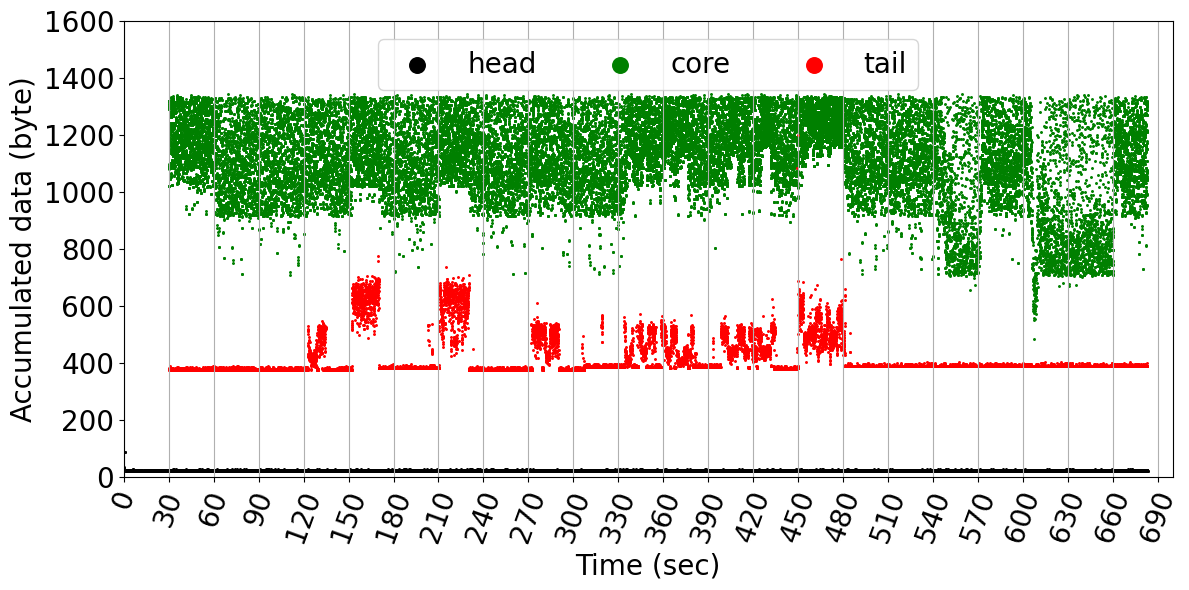

In [15]:
# 80:23 data only
# list 0: head; list 1: core; list 2: tail; list 3: other

list_lst_time_plot_8023 = [[],[],[],[]]
list_lst_pkt_plot_8023 = [[],[],[],[]]


for i in ana_mat_burst:
    if i[cols["data.type.name"]] in ["head"]:
        lst_ind = 0
    elif i[cols["data.type.name"]] in ["core"]:
        lst_ind = 1
    elif i[cols["data.type.name"]] in ["tail"]:
        lst_ind = 2
    else:
        lst_ind = 3
        
    list_lst_time_plot_8023[lst_ind].append(i[cols["frame.time_epoch"]])
    list_lst_pkt_plot_8023[lst_ind].append(int(i[cols["data.len"]]))
    
print("Found non-burst frames: ", len(list_lst_time_plot_8023[3]))    
    
colors = ['k', 'g', 'r', 'b']

labels = ['head', 'core', "tail", "Others"]
    
markers = ['.', 'o', 'x', '.']
    
_, ax = plt.subplots(figsize=(12, 6))

for i in range(3):
    # Create the plot object
    

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
    ax.scatter(list_lst_time_plot_8023[i], list_lst_pkt_plot_8023[i], s = 5, color = colors[i], 
               label = labels[i], alpha = 1, marker='.')


# ax.scatter(lst_time_sim, lst_size_accum, s = 5, color = 'b', label = 'Sim', alpha = 0.75, marker='o')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
# ax.set_xlabel("Time (sec)")
# ax.set_ylabel("Accumulated data (byte)")
# # if x_xlim[0]<x_xlim[1]:
# ax.set_xlim(0, 700)
# ax.legend()



plt.gca().xaxis.grid(True)

ax.set_xlabel("Time (sec)", fontsize = 20)
ax.set_ylabel("Accumulated data (byte)", fontsize = 20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# if x_xlim[0]<x_xlim[1]:
ax.set_xlim(0, 700)
ax.set_ylim(0, 1600)
ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.99), loc='upper center', ncol=3, markerscale=10)
    
    
ax.set_xticks([i*30 for i in range(24)])
plt.xticks(rotation=70)
print('The outliers different from the identified three sub-burst frames: ', list_lst_time_plot_8023[3])

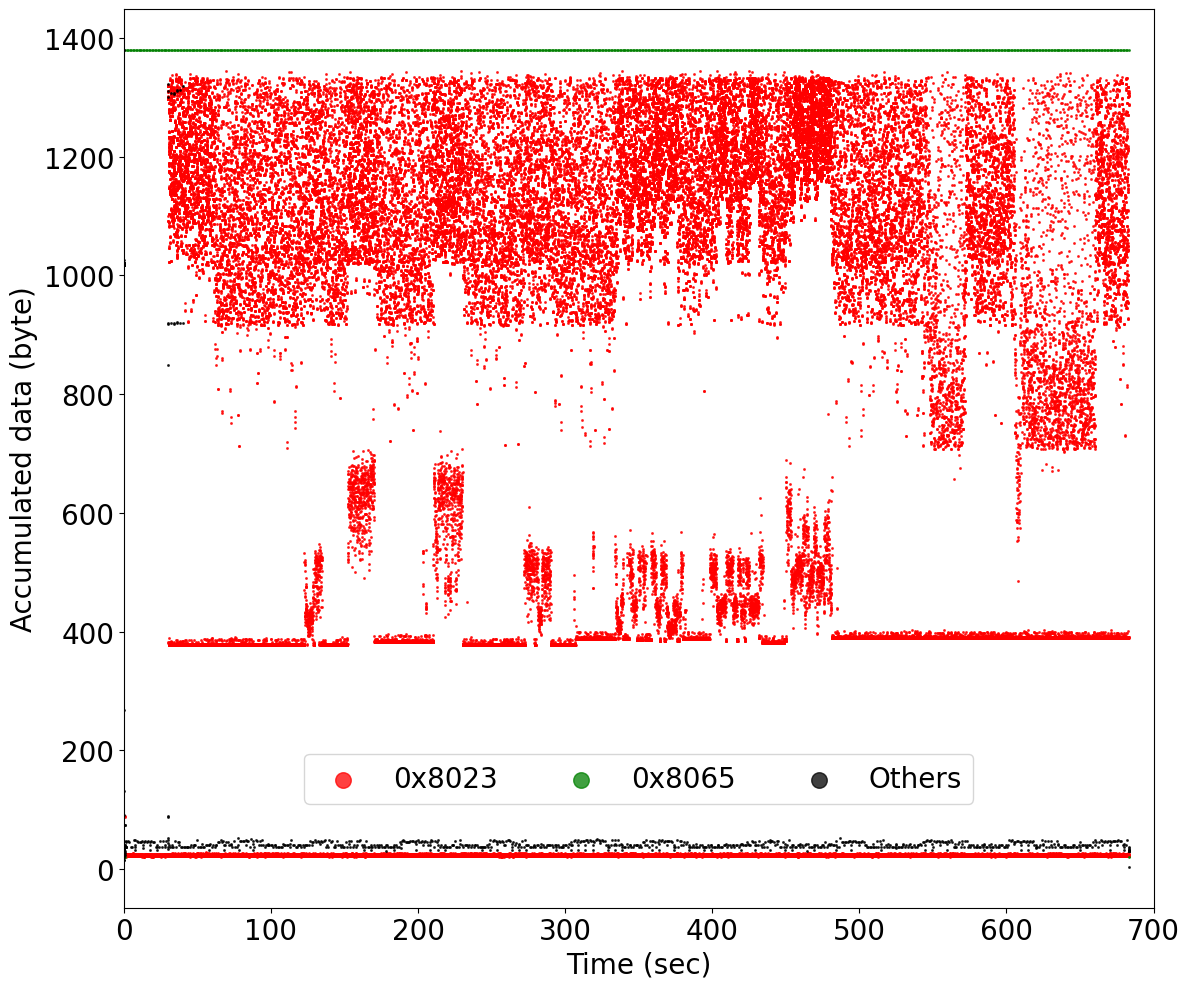

In [16]:
list_lst_time_plot = [[],[],[]]
list_lst_pkt_plot = [[],[],[]]

for i in ana_mat:
    if i[cols["data.type"]] in ["80:23"]:
        lst_ind = 0
    elif i[cols["data.type"]] in ["80:65"]:
        lst_ind = 1
    else:
        lst_ind = 2
        
    list_lst_time_plot[lst_ind].append(i[cols["frame.time_epoch"]])
    list_lst_pkt_plot[lst_ind].append(int(i[cols["data.len"]]))
    

colors = ['r', 'g', 'k']

labels = ['0x8023', '0x8065', "Others"]
    
markers = ['.', 'o', 'x']
    
_, ax = plt.subplots(figsize=(12, 10))

for i in range(3):
    # Create the plot object
    

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
    ax.scatter(list_lst_time_plot[i], list_lst_pkt_plot[i], s = 5, color = colors[i], label = labels[i], 
               alpha = 0.75, marker='.')


# ax.scatter(lst_time_sim, lst_size_accum, s = 5, color = 'b', label = 'Sim', alpha = 0.75, marker='o')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 20)
ax.set_ylabel("Accumulated data (byte)", fontsize = 20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# if x_xlim[0]<x_xlim[1]:
ax.set_xlim(0, 700)
ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.1), loc='lower center', ncol=3, markerscale=10)

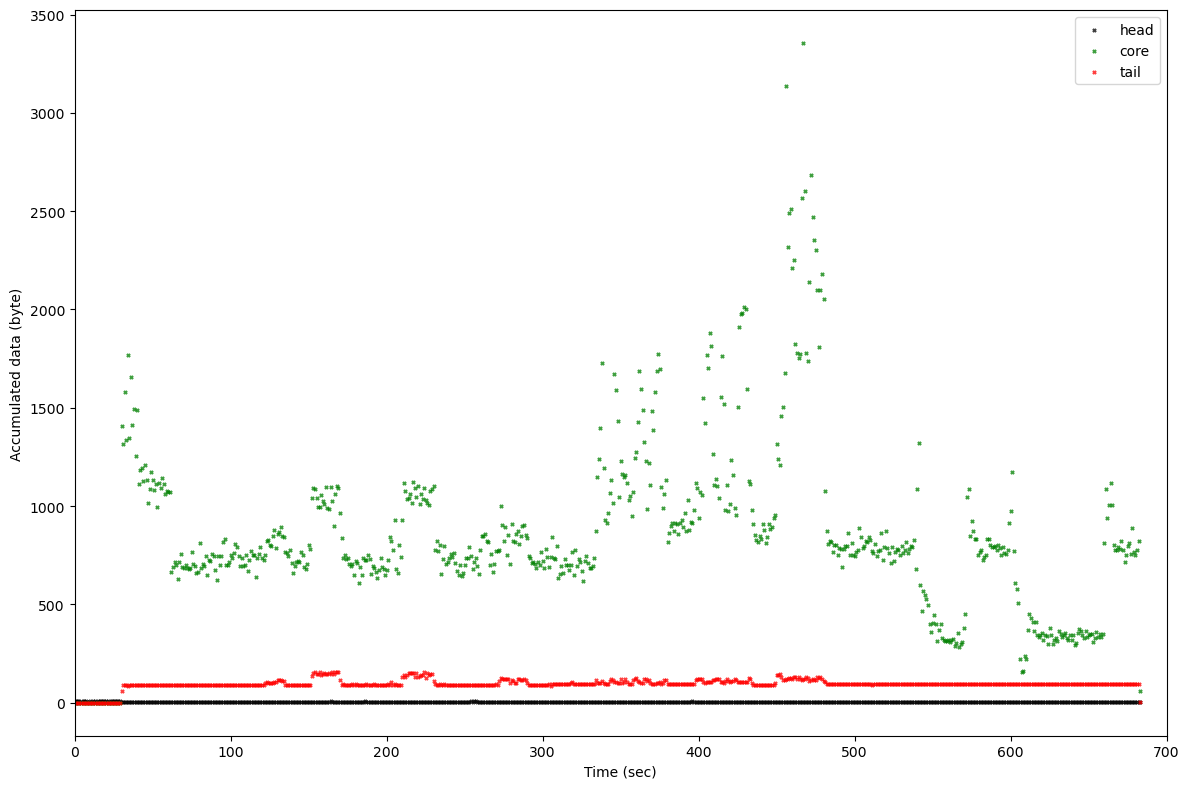

In [17]:
# Throughput of the simulated data stream

# The simulated frame time is in msec.

step = 1 # sec

start_time = 0
end_time = ana_mat_burst[-1][cols["frame.time_epoch"]]

list_of_arr_time = []
for i in range(3):
    arr_time = np.arange(start_time, end_time, step = step)
    list_of_arr_time.append(arr_time)
# arr_time[1]

# for i in arr_time:
#     print(i)
    
list_of_lst_byte = []
for i in range(3):
    lst_byte = [0 for i in range(len(arr_time))]
    list_of_lst_byte.append(lst_byte)


# print(lst_rate)

list_of_lst_rate_kbps = []

import math

for i in range(3):
    for j in range(len(list_lst_time_plot_8023[i])):
        idx = math.ceil(list_lst_time_plot_8023[i][j] / step)
        list_of_lst_byte[i][idx-1] += list_lst_pkt_plot_8023[i][j]
        
    lst_rate_kbps = [k * 8 / step / 1000 for k in list_of_lst_byte[i]]
    
    list_of_lst_rate_kbps.append(lst_rate_kbps)

# for i in lst_sim_time_to_sec:
#     idx = math.ceil(i / step)
#     lst_byte[idx-1] += frame_size
    
# print(lst_byte[300:350])

# lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]





colors = ['k', 'g', 'r', 'b']

labels = ['head', 'core', "tail", "Others"]
    
markers = ['.', 'o', 'x', '.']
    
_, ax = plt.subplots()

for i in range(3):
    # Create the plot object
    

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
    ax.scatter(list_of_arr_time[i], list_of_lst_rate_kbps[i], s = 5, color = colors[i], label = labels[i], alpha = 0.75, marker='x')


# ax.scatter(lst_time_sim, lst_size_accum, s = 5, color = 'b', label = 'Sim', alpha = 0.75, marker='o')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Accumulated data (byte)")
# if x_xlim[0]<x_xlim[1]:
ax.set_xlim(0, 700)
ax.legend()



# # print("After:", lst_rate_kbps[300:350])

# # pic_title = "Link: "+stream_dir_list[stream_id]
# pic_title = "Application Data Rate"
# print('Figure saved as ', pic_title)
# x_min_display = 0
# x_max_display = 800#pcap_end_time
# scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
# #             y_ylim=[0, 30], \
#             x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

In [18]:
lst_tap_freq_count = [0 for i in range(max_tap_idx+1)]

for i in ana_mat_burst:
    lst_tap_freq_count[i[cols["data.seg.tap.idx"]]] += 1
    

for i in range(len(lst_tap_freq_count)-1):
    print("Tap {}: {} counts, with {} ending here".format(i, lst_tap_freq_count[i], lst_tap_freq_count[i]-lst_tap_freq_count[i+1]))




Tap 0: 21321 counts, with 1736 ending here
Tap 1: 19585 counts, with 59 ending here
Tap 2: 19526 counts, with 1212 ending here
Tap 3: 18314 counts, with 4109 ending here
Tap 4: 14205 counts, with 8588 ending here
Tap 5: 5617 counts, with 3230 ending here
Tap 6: 2387 counts, with 1002 ending here
Tap 7: 1385 counts, with 770 ending here
Tap 8: 615 counts, with 315 ending here
Tap 9: 300 counts, with 99 ending here
Tap 10: 201 counts, with 64 ending here
Tap 11: 137 counts, with 49 ending here
Tap 12: 88 counts, with 43 ending here
Tap 13: 45 counts, with 15 ending here
Tap 14: 30 counts, with 8 ending here
Tap 15: 22 counts, with 10 ending here
Tap 16: 12 counts, with 1 ending here
Tap 17: 11 counts, with 0 ending here
Tap 18: 11 counts, with 2 ending here
Tap 19: 9 counts, with 0 ending here
Tap 20: 9 counts, with 0 ending here
Tap 21: 9 counts, with 4 ending here


In [19]:
# check all unique "data.type.sub" and find the population

lst_phase_record = [
    [0, 30, 0], # 0: headset connected, VR Preview not enabled, idling (State 0)
    [30, 60, 1], # 1, VR Preview enabled, no XR displayed (State 1)
    [60, 120, 2], # 2, XR contented displayed (semi-static) (State 2)
    [120, 150, 3], # 3, user input sensed (one hand in view) (State 3)
    [150, 180, 4], # 4, user input sensed (two hands in view) (State 4)
    [180, 210, 2], # 5, back to State 2
    [210, 240, 4], # 6, repeat State 4
    [240, 270, 2], # 7, back to State 2
    [270, 300, 3], # 8, Repeat State 3
    [300, 330, 2], # 9, back to State 2
    [330, 450, 5], # 10, user input (one hand, manipulate XR content) (State 5)
    [450, 480, 6], # 11, user input (two hands, manipulate XR content) (State 6)
    [480, 540, 2], # 12, back to State 2headset connected, VR Preview not enabled, idling
    [540, 570, 7], # 13, XR content change in the view (head rotation) (State 7)
    [570, 600, 2], # 14, back to State 2
    [600, 660, 7], # 15, XR content change in the view (head rotation) (State 7)
    [660, 680, 2] # 16, back to State 2
]

dict_op_state_def ={}
dict_op_state_def[0] = "State 0: idle link, headset connected, VR Preview not enabled"
dict_op_state_def[1] = "State 1: VR Preview enabled, no XR content overlayed"
dict_op_state_def[2] = "State 2: XR contented overlayed (semi-static)"
dict_op_state_def[3] = "State 3: user input sensed (one hand in view)"
dict_op_state_def[4] = "State 4: user input sensed (two hands in view)"
dict_op_state_def[5] = "State 5: user input (one hand, manipulate XR content)"
dict_op_state_def[6] = "State 6: user input (two hands, manipulate XR content)"
dict_op_state_def[7] = "State 7: XR content change in the view (head rotation)"

In [20]:
# This timeline was calibrated with UL traffic pattern since the states were defined per user input events
lst_phase_record = [
    [0.5, 30, 0], # Phase 0: headset connected, VR Preview not enabled, idling (State 0)
    [30.5, 60, 1], # Phase 1, VR Preview enabled, no XR displayed (State 1)
    [60, 110, 2], # Phase 2, XR contented displayed (semi-static) (State 2)
    [123, 134.5, 3], # Phase 3, user input sensed (one hand in view) (State 3)
    [136, 151, 2], # Phase 4, back to State 2
    [152.5, 170, 4], # Phase 5, user input sensed (two hands in view) (State 4)
    [175, 186, 2], # Phase 6, back to State 2
    # between, mixed State 2 and 3
    [191, 201, 2], # Phase 7, back to State 2
    # between, [201, 211], mixed State 2 and 3
    [211, 230, 4], # 6, repeat State 4
    # [230, 236] # mixed State 2 and 3
    [236, 251, 2], # 7, back to State 2
    [255, 259, 2], # 8, State 2
    [261, 271, 2], # 9, State 2
    [273, 290, 3], # 10, Repeat State 3, ! Note that [279, 281] @ State 2
    [291, 330, 2], # 11, back to State 2 (slightly mixed with State 3)
    [330, 450, 5], # 12, user input (one hand, manipulate XR content) (State 5)
    [450, 480, 6], # 13, user input (two hands, manipulate XR content) (State 6)
    [482, 540, 2], # 14, back to State 2headset connected, VR Preview not enabled, idling
    [540, 570, 7], # 15, XR content change in the view (head rotation) (State 7)
    [570, 600, 2], # 16, back to State 2
    [600, 660, 7], # 17, XR content change in the view (head rotation) (State 7)
    [660, 680, 2] # 18, back to State 2
]

In [21]:
mat_seg_interval = []

last_seg_start_time = ana_mat_burst[0][cols["frame.time_epoch"]]
# last_seg_idx = ana_mat_burst[0][cols["data.seg.idx"]]

for i in ana_mat_burst[1:]:
    if i[cols["data.seg.tap.idx"]] == 0:
        curr_seg_start_time = i[cols["frame.time_epoch"]]
        last_seg_duration = curr_seg_start_time - last_seg_start_time
        
        mat_seg_interval.append([last_seg_start_time, last_seg_duration])
        
        last_seg_start_time = curr_seg_start_time
        
len(mat_seg_interval)
        

21320

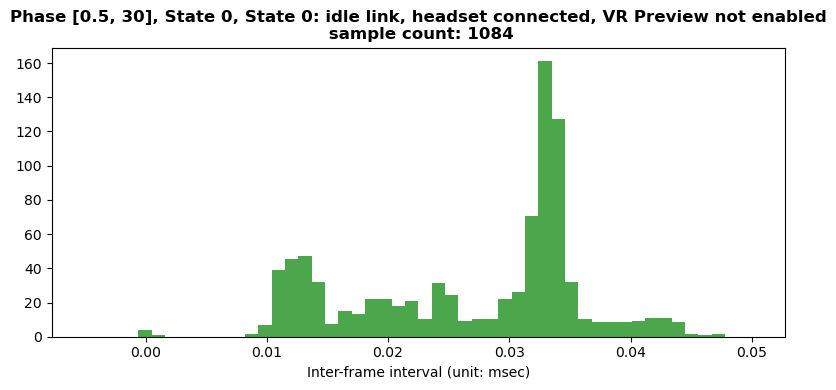

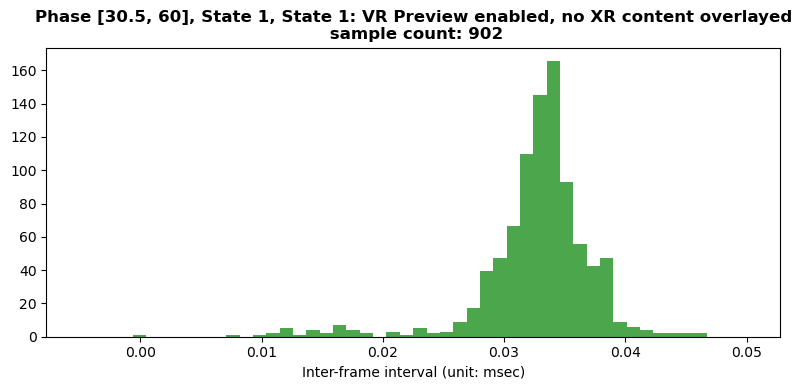

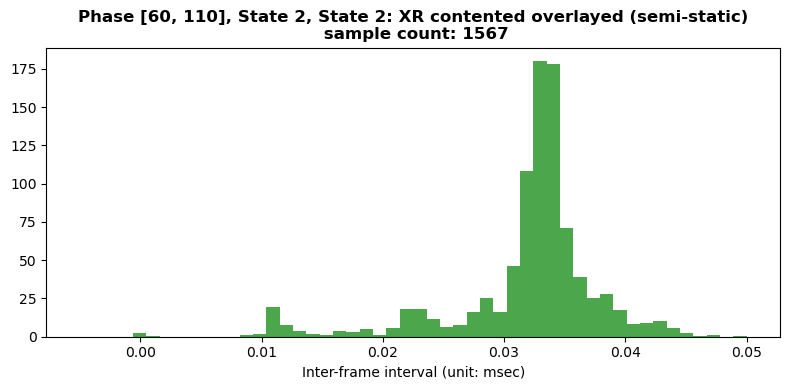

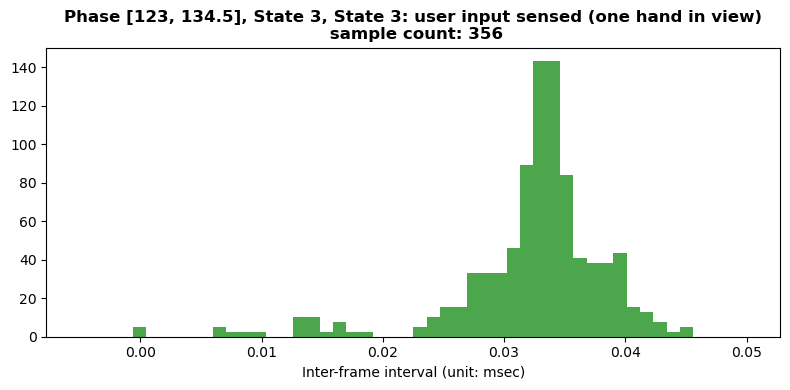

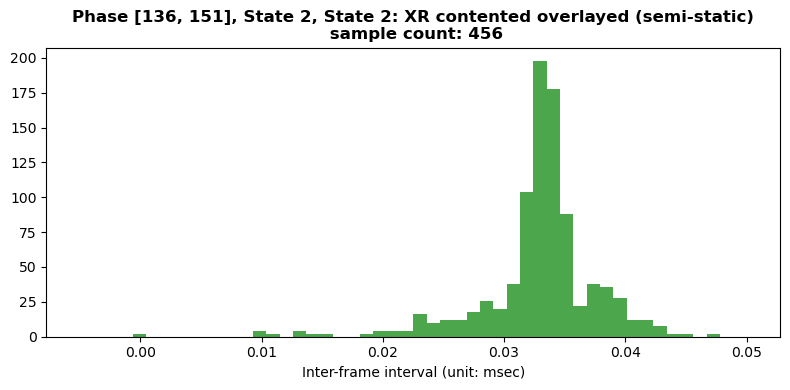

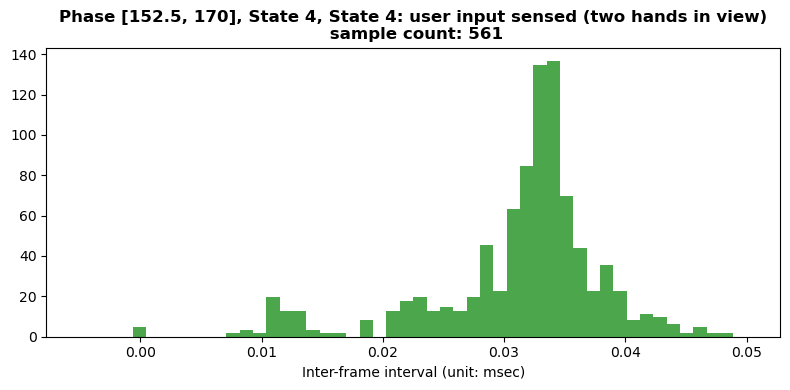

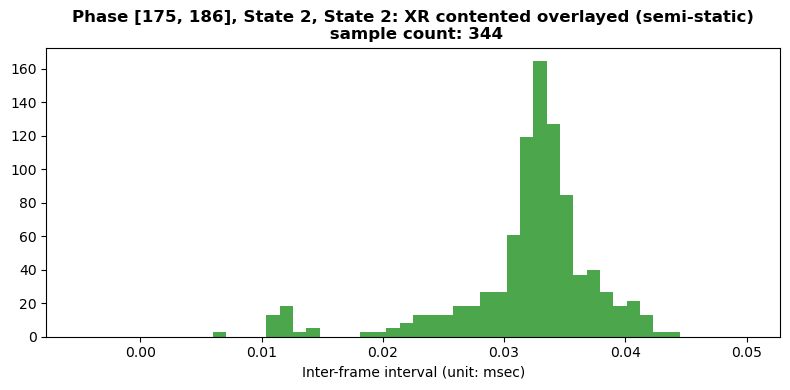

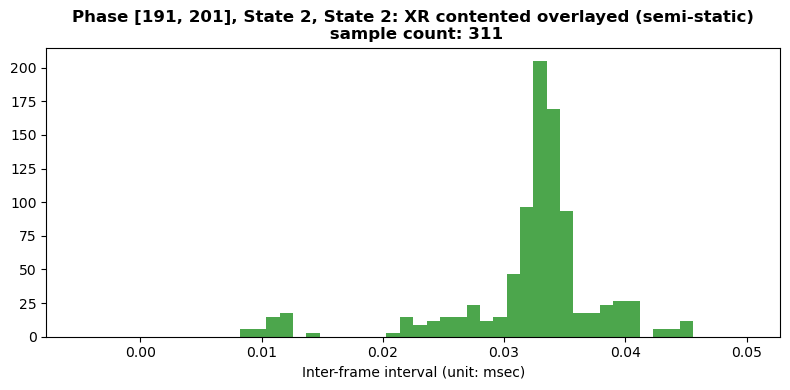

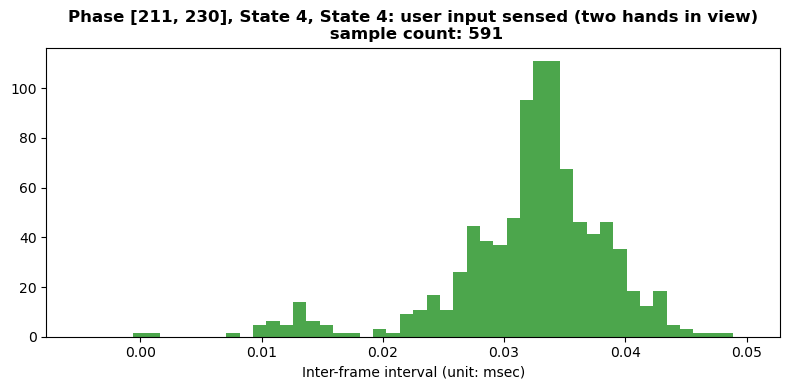

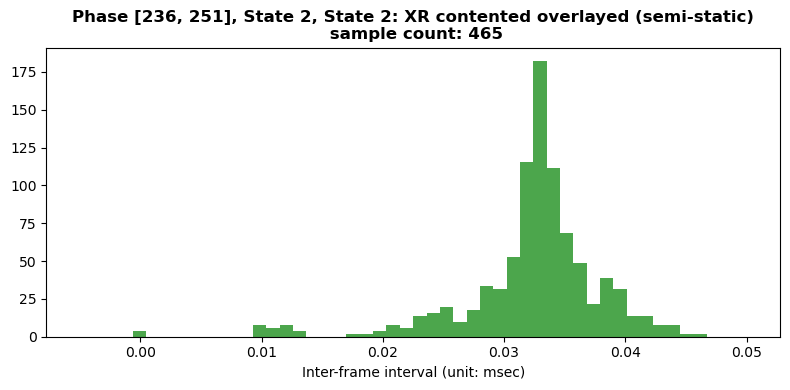

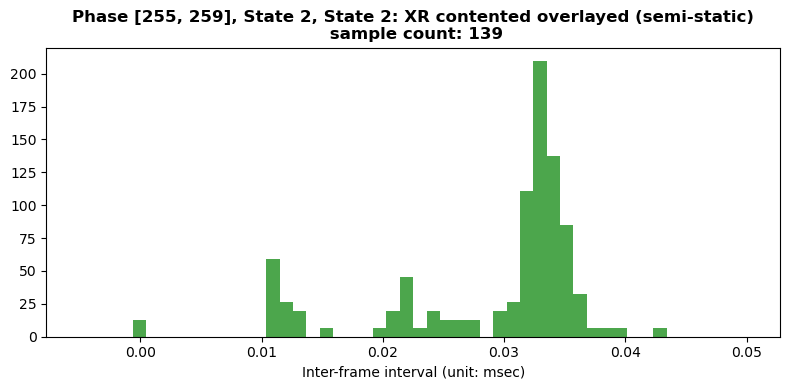

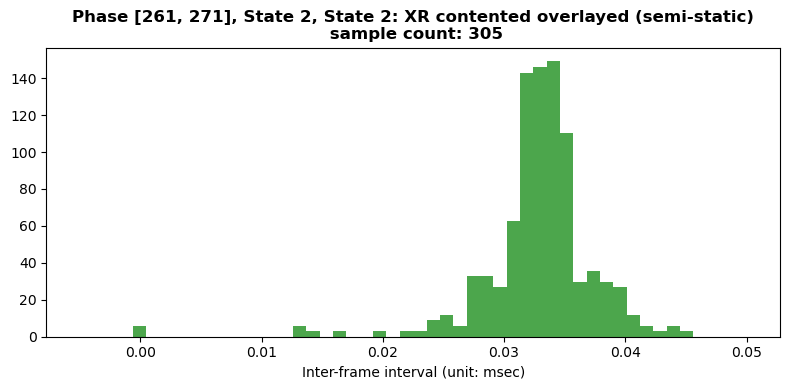

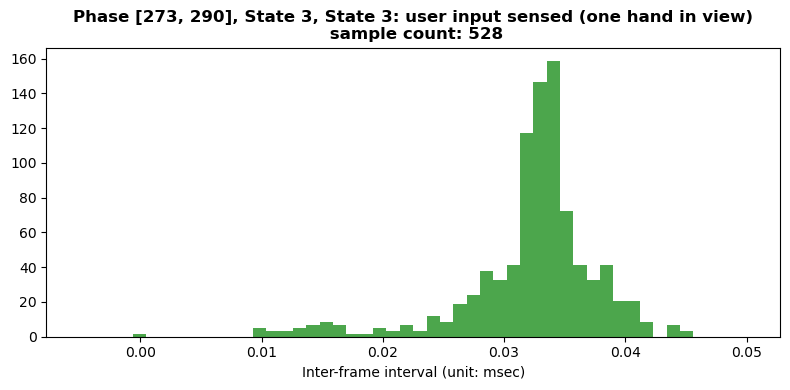

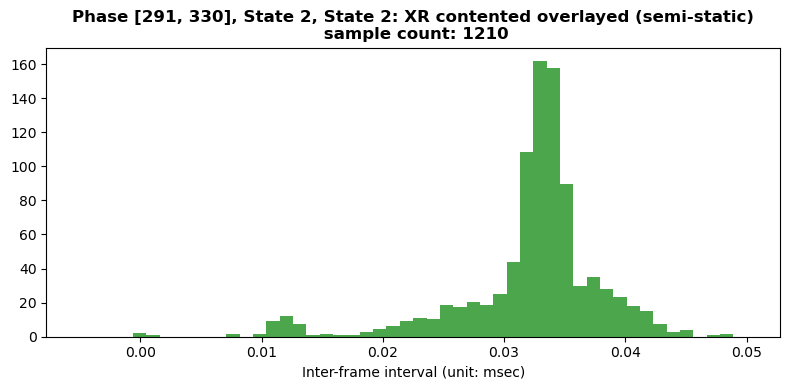

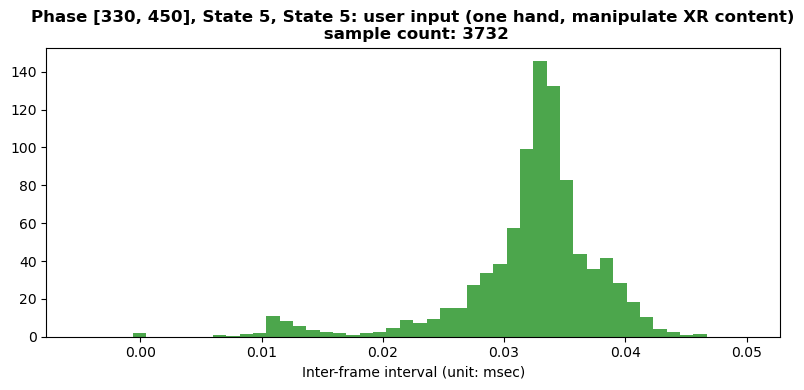

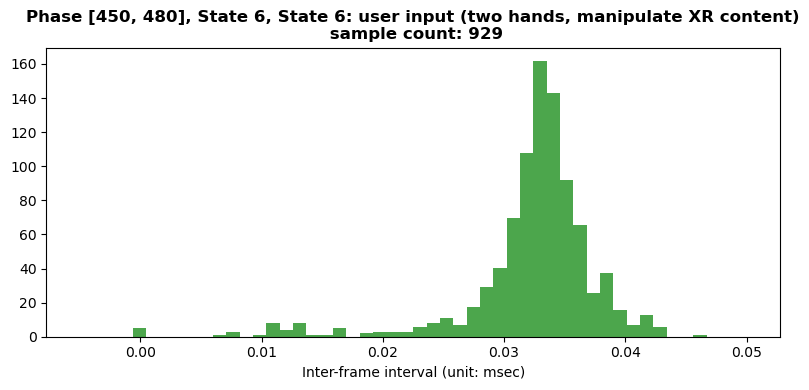

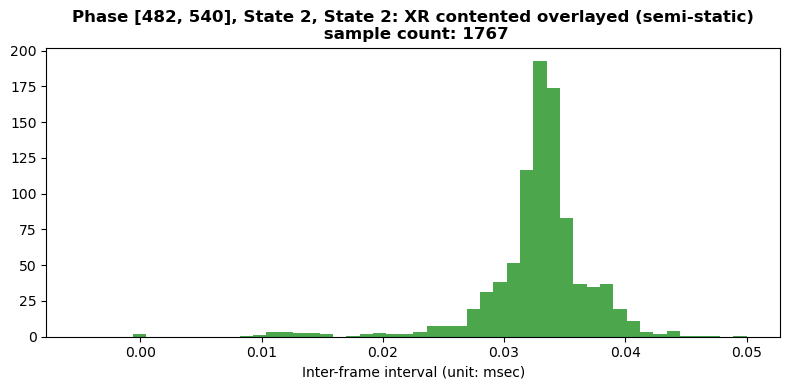

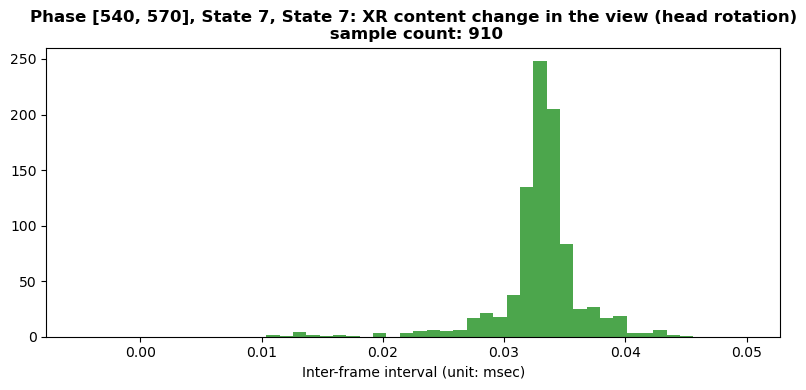

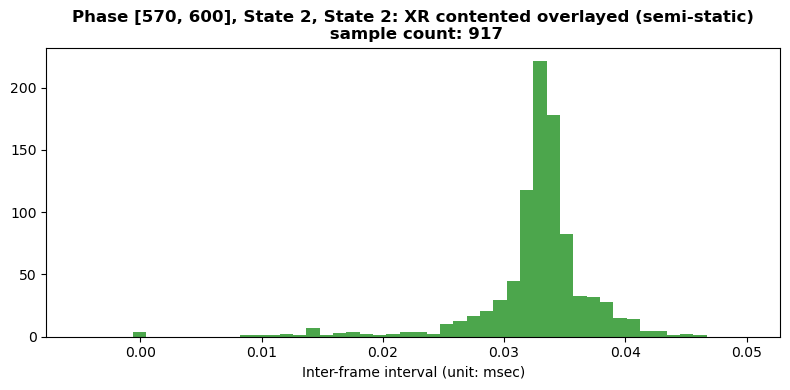

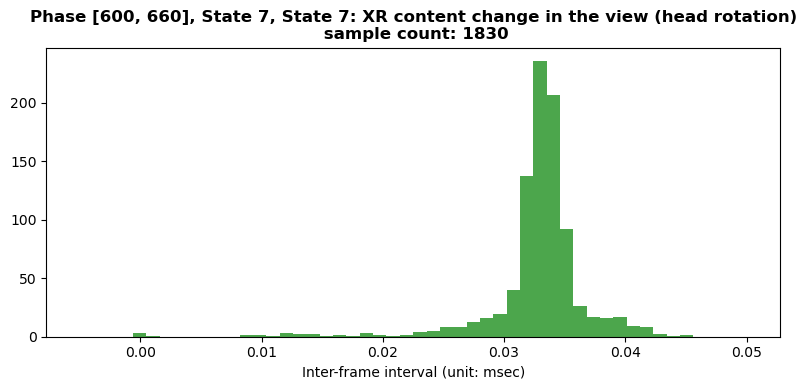

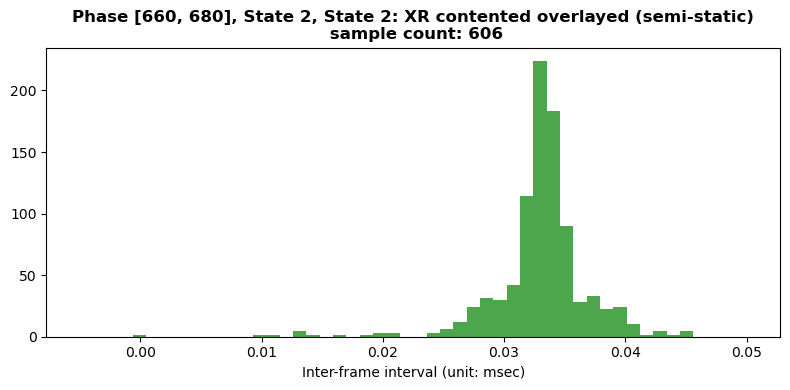

In [22]:
import matplotlib.pyplot as plt
import numpy as np

for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    lst_seg_interval_per_phase = []
    for i in mat_seg_interval:
        if i[0] > phase_end_time:
            break # end the loop
            
        if i[0] >= phase_start_time:
            lst_seg_interval_per_phase.append(i[1])
            


    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = 50

    ## Plot the histogram of the i-th tags in segments

    # x_seq = [i for i in tag_lists[0] if i > 16000]
    # x_seq = [i for i in tag_lists[1] if i > 16000]
    # x_seq = [i for i in tag_lists[2] if i > 16000]
    # x_seq = [i for i in tag_lists[4] if i > 16000]
    #x_seq = [i for i in tag_lists[3]]
    # x_seq = [i for i in tag_lists[2]]        
    # print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


    # plot the histogram
    n, bins, patches = ax.hist(lst_seg_interval_per_phase, num_bins, 
                               range=[-0.005, 0.05],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    # plot the cumulative histogram
    # n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
    #                            cumulative=True, label='Empirical')


    plt.xlabel('Inter-frame interval (unit: msec)')
    # plt.ylabel('Y-Axis')
    
    title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
                                                                           phase_state, phase_state_term, \
                                                                          len(lst_seg_interval_per_phase))

    plt.title(title_print,
              fontweight = "bold")

    plt.show()
            
    

In [23]:
import matplotlib.pyplot as plt
import numpy as np

for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    lst_tap_freq_count = [0 for i in range(max_tap_idx+1)]
    
    for i in ana_mat_burst:
        if i[cols["frame.time_epoch"]] > phase_end_time:
            break # end the loop
        
        if i[cols["frame.time_epoch"]] > phase_start_time:
            lst_tap_freq_count[i[cols["data.seg.tap.idx"]]] += 1
    
    
    lst_tap_index = [i for i in range(len(lst_tap_freq_count))]
    
    
    title = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
                                                                            phase_state, phase_state_term, \
                                                                            len(lst_seg_interval_per_phase))
    print(">>>>>>>>>>>>>>>>>>>>>>>>\n", title)
    for i in range(len(lst_tap_index)):
        print("Tap {}, count {}".format(lst_tap_index[i], lst_tap_freq_count[i]))
    
#     pic_

#     x_min_display = lst_tap_index[0]
#     x_max_display = lst_tap_index[-1]
#     scatterplot(lst_tap_index, lst_tap_freq_count, x_xlim=[x_min_display, x_max_display], \
#     #             y_ylim=[0, 30], \
#                 x_label="Tap", y_label="Count", title=pic_title, figSave=True, fig_index="")
            

>>>>>>>>>>>>>>>>>>>>>>>>
 Phase [0.5, 30], State 0, State 0: idle link, headset connected, VR Preview not enabled
 sample count: 606
Tap 0, count 1084
Tap 1, count 0
Tap 2, count 0
Tap 3, count 0
Tap 4, count 0
Tap 5, count 0
Tap 6, count 0
Tap 7, count 0
Tap 8, count 0
Tap 9, count 0
Tap 10, count 0
Tap 11, count 0
Tap 12, count 0
Tap 13, count 0
Tap 14, count 0
Tap 15, count 0
Tap 16, count 0
Tap 17, count 0
Tap 18, count 0
Tap 19, count 0
Tap 20, count 0
Tap 21, count 0
Tap 22, count 0
>>>>>>>>>>>>>>>>>>>>>>>>
 Phase [30.5, 60], State 1, State 1: VR Preview enabled, no XR content overlayed
 sample count: 606
Tap 0, count 902
Tap 1, count 886
Tap 2, count 886
Tap 3, count 884
Tap 4, count 870
Tap 5, count 676
Tap 6, count 312
Tap 7, count 62
Tap 8, count 19
Tap 9, count 7
Tap 10, count 7
Tap 11, count 7
Tap 12, count 7
Tap 13, count 7
Tap 14, count 7
Tap 15, count 7
Tap 16, count 7
Tap 17, count 7
Tap 18, count 7
Tap 19, count 7
Tap 20, count 7
Tap 21, count 7
Tap 22, count 5
>>>>>>>

In [24]:
lst_tap_freq_count = [0 for i in range(max_tap_idx+1)]

for i in ana_mat_burst:
    lst_tap_freq_count[i[cols["data.seg.tap.idx"]]] += 1
    

for i in range(len(lst_tap_freq_count)):
    print("Tap {}: {} counts".format(i, lst_tap_freq_count[i]))
# print(lst_tap_freq_count)

Tap 0: 21321 counts
Tap 1: 19585 counts
Tap 2: 19526 counts
Tap 3: 18314 counts
Tap 4: 14205 counts
Tap 5: 5617 counts
Tap 6: 2387 counts
Tap 7: 1385 counts
Tap 8: 615 counts
Tap 9: 300 counts
Tap 10: 201 counts
Tap 11: 137 counts
Tap 12: 88 counts
Tap 13: 45 counts
Tap 14: 30 counts
Tap 15: 22 counts
Tap 16: 12 counts
Tap 17: 11 counts
Tap 18: 11 counts
Tap 19: 9 counts
Tap 20: 9 counts
Tap 21: 9 counts
Tap 22: 5 counts


In [25]:
# create a new matrix to store burst-wise data

ana_mat_burst_stat = []

lst_burst_mat_cols = ["burst.time", \
                      "head.time", "head.time.frame", "head.size", \
                      "core.time", "core.time.frame", "core.frame_num", "core.frame_size", \
                      "tail.time", "tail.time.frame", "tail.size"]

burst_mat_cols = {k: v for v, k in enumerate(lst_burst_mat_cols)}

print(burst_mat_cols)

# new_row_ready = False
# tmp_row = [-1 for i in range(len(lst_burst_mat_cols))]

for i in range(len(ana_mat_burst)):
    
    i_frame_type_name = ana_mat_burst[i][cols["data.type.name"]]
    i_burst_tap_id = ana_mat_burst[i][cols["data.seg.tap.idx"]]
    i_frame_len = int(ana_mat_burst[i][cols["data.len"]])
    i_frame_time = ana_mat_burst[i][cols["frame.time_epoch"]]
    i_frame_time_number = ana_mat_burst[i][cols["frame.number"]]
    
    if i == 0: # first row
        tmp_row = [-1 for i in range(len(lst_burst_mat_cols))]
    else:
        if i_burst_tap_id == 0: # a new burst
            # save the previous burst row record
            ana_mat_burst_stat.append(tmp_row.copy())
            # reset the row 
            tmp_row = [-1 for i in range(len(lst_burst_mat_cols))]
            
        
    if i_frame_type_name == "head":
        tmp_row[burst_mat_cols["burst.time"]] = i_frame_time
        tmp_row[burst_mat_cols["head.time"]] = i_frame_time
        tmp_row[burst_mat_cols["head.time.frame"]] = i_frame_time_number
        tmp_row[burst_mat_cols["head.size"]] = i_frame_len

    elif i_frame_type_name == "core":
        if i_burst_tap_id == 0: # first frame in the burst
            tmp_row[burst_mat_cols["burst.time"]] = i_frame_time

        if tmp_row[burst_mat_cols["core.time"]] < 0: # first body frame
            tmp_row[burst_mat_cols["core.time"]] = i_frame_time
            tmp_row[burst_mat_cols["core.time.frame"]] = i_frame_time_number
            tmp_row[burst_mat_cols["core.frame_num"]] = 1
            tmp_row[burst_mat_cols["core.frame_size"]] = i_frame_len
        else: # not the first body frame
            tmp_row[burst_mat_cols["core.frame_num"]] += 1
            tmp_row[burst_mat_cols["core.frame_size"]] += i_frame_len

    elif i_frame_type_name == "tail":
        if i_burst_tap_id == 0: # first frame in the burst
            tmp_row[burst_mat_cols["burst.time"]] = i_frame_time

        tmp_row[burst_mat_cols["tail.time"]] = i_frame_time
        tmp_row[burst_mat_cols["tail.time.frame"]] = i_frame_time_number
        tmp_row[burst_mat_cols["tail.size"]] = i_frame_len

    else:
        print("Alert: unexpected frame type: ", i_frame_type_name)
            

        
            

print("Total burst count: ", len(ana_mat_burst_stat))

lst_head_count = [1 for i in ana_mat_burst_stat if i[burst_mat_cols["head.size"]]>0]
lst_core_count = [1 for i in ana_mat_burst_stat if i[burst_mat_cols["core.frame_size"]]>0]
lst_tail_count = [1 for i in ana_mat_burst_stat if i[burst_mat_cols["tail.size"]]>0]
print(len(lst_head_count), len(lst_core_count), len(lst_tail_count))



{'burst.time': 0, 'head.time': 1, 'head.time.frame': 2, 'head.size': 3, 'core.time': 4, 'core.time.frame': 5, 'core.frame_num': 6, 'core.frame_size': 7, 'tail.time': 8, 'tail.time.frame': 9, 'tail.size': 10}
Total burst count:  21320
20539 19585 19575


### Observation

An observation was made here that the interval between any two core frame clusters follows a distribution centered around 33 msec, which indicates the frame update rate is at 30 fps.

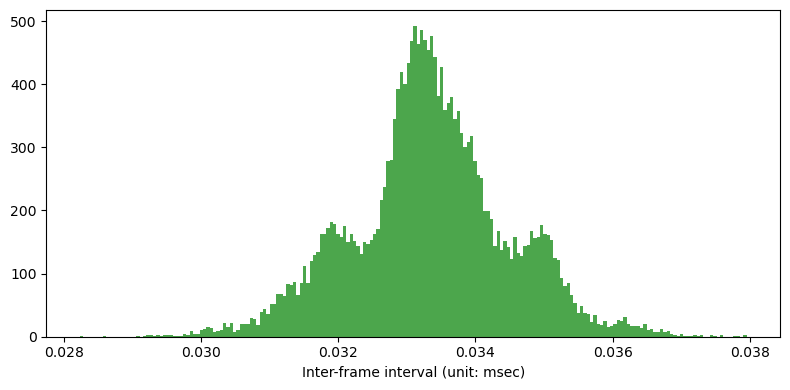

min: 0.028234004974365234, max: 0.03795194625854492
Outliers (interval) count:  0


In [26]:
lst_burst_start_time = []

for i in ana_mat_burst_stat:
    i_lst_start_time = []
    
    if min(i[burst_mat_cols["head.time"]], i[burst_mat_cols["core.time"]], i[burst_mat_cols["tail.time"]])>0:
        i_burst_time = i[burst_mat_cols["core.time"]]
        lst_burst_start_time.append(i_burst_time)
    
lst_burst_interval = [lst_burst_start_time[i+1]-lst_burst_start_time[i] for i in range(len(lst_burst_start_time)-1)]

lst_burst_interval = [i for i in lst_burst_interval if i > 0.028 and i < 0.038]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 200

# plot the histogram
n, bins, patches = ax.hist(lst_burst_interval, num_bins, 
#                            range=[-0.005, 0.05],
                            density = 1,
                            color ='green',
                            alpha = 0.7)


plt.xlabel('Inter-frame interval (unit: msec)')

plt.show()

print('min: {}, max: {}'.format(min(lst_burst_interval), max(lst_burst_interval)))
print("Outliers (interval) count: ", len([i for i in lst_burst_interval if i < 0.028 or i > 0.038]))

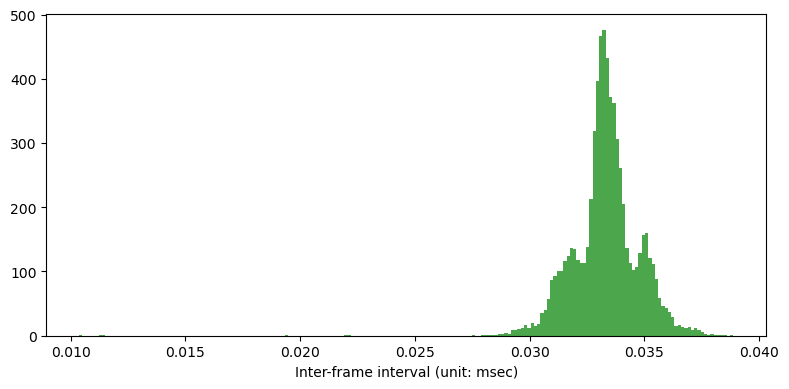

min: 0.010365009307861328, max: 0.03887820243835449
Outliers (interval) count:  25


In [27]:
lst_burst_start_time = []

for i in ana_mat_burst_stat:
    i_lst_start_time = []
    
    if i[burst_mat_cols["core.time"]]>0:
        i_lst_start_time.append(i[burst_mat_cols["core.time"]]) 
        
    if i[burst_mat_cols["tail.time"]]>0:
        i_lst_start_time.append(i[burst_mat_cols["tail.time"]])
        
    if len(i_lst_start_time) == 0:
#         print(i[burst_mat_cols["core.time"]], i[burst_mat_cols["tail.time"]])
#         print(i)
        continue
        
    i_burst_time = min(i_lst_start_time)
    
    lst_burst_start_time.append(i_burst_time)
    
lst_burst_interval = [lst_burst_start_time[i+1]-lst_burst_start_time[i] for i in range(len(lst_burst_start_time)-1)]



fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 200

# plot the histogram
n, bins, patches = ax.hist(lst_burst_interval, num_bins, 
#                            range=[-0.005, 0.05],
                            density = 1,
                            color ='green',
                            alpha = 0.7)


plt.xlabel('Inter-frame interval (unit: msec)')

plt.show()

print('min: {}, max: {}'.format(min(lst_burst_interval), max(lst_burst_interval)))
print("Outliers (interval) count: ", len([i for i in lst_burst_interval if i < 0.028 or i > 0.038]))

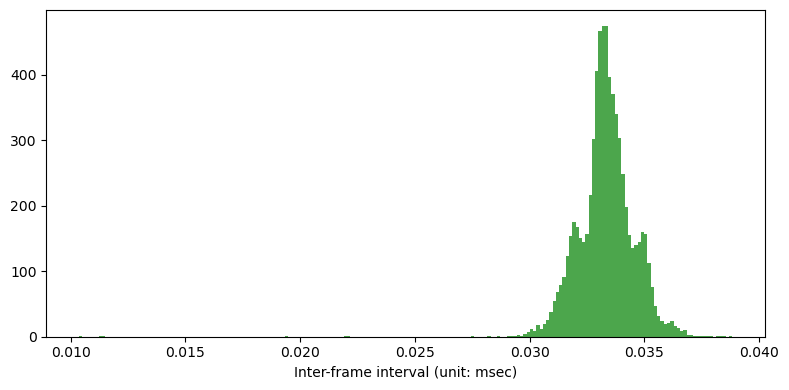

min: 0.010365009307861328, max: 0.03882789611816406
Outliers (interval) count:  13


In [28]:
lst_core_start_time = [i[burst_mat_cols["core.time"]] for i in ana_mat_burst_stat if i[burst_mat_cols["core.time"]]>0]
lst_core_size = [i[burst_mat_cols["core.frame_size"]] for i in ana_mat_burst_stat if i[burst_mat_cols["core.time"]]>0]
lst_core_interval = [lst_core_start_time[i+1]-lst_core_start_time[i] for i in range(len(lst_core_start_time)-1)]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 200




# plot the histogram
n, bins, patches = ax.hist(lst_core_interval, num_bins, 
#                            range=[-0.005, 0.05],
                            density = 1,
                            color ='green',
                            alpha = 0.7)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')


plt.xlabel('Inter-frame interval (unit: msec)')
# plt.ylabel('Y-Axis')

# title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
#                                                                        phase_state, phase_state_term, \
#                                                                       len(lst_core_start_time))

# plt.title(title_print,
#           fontweight = "bold")

plt.show()

print('min: {}, max: {}'.format(min(lst_core_interval), max(lst_core_interval)))
print("Outliers (interval) count: ", len([i for i in lst_core_interval if i < 0.028 or i > 0.038]))

In [29]:
len(lst_core_interval) /1000

19.584

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


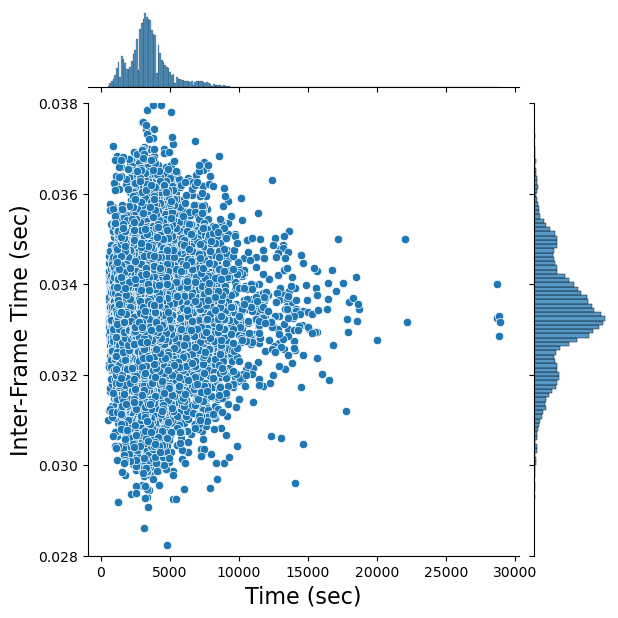

In [30]:
h=sns.jointplot(x=lst_core_size[1:], y=lst_core_interval, ylim=[0.028, 0.038], kind='scatter')
# h.ax_marg_x.grid('on')
#     h.ax_joint.set_yticks([10, 21, 37, 48])
# h.set_yticklabels(h.get_yticks(), size = 15)
h.set_axis_labels('Time (sec)', 'Inter-Frame Time (sec)', fontsize=16)
# sns.jointplot(x=x, y=y, kind='scatter')
plt.show()

In [31]:
burst_mat_cols

{'burst.time': 0,
 'head.time': 1,
 'head.time.frame': 2,
 'head.size': 3,
 'core.time': 4,
 'core.time.frame': 5,
 'core.frame_num': 6,
 'core.frame_size': 7,
 'tail.time': 8,
 'tail.time.frame': 9,
 'tail.size': 10}

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


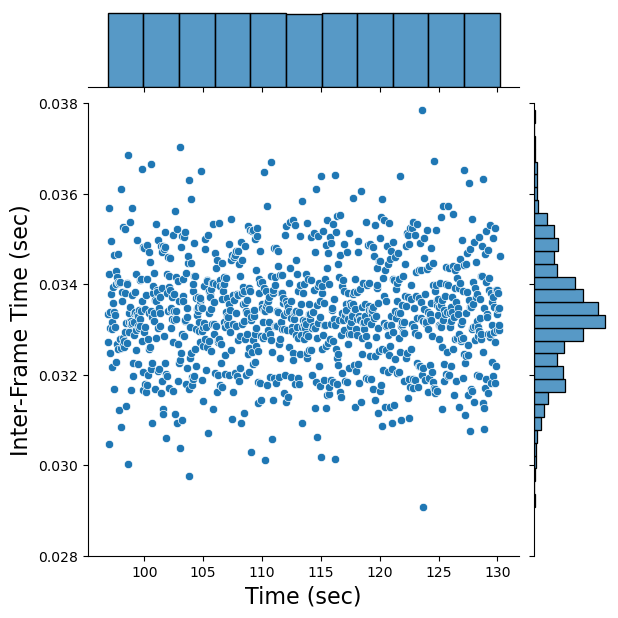

= 0.03334498405456543, 22, 3, 3891, 377
= 0.0327150821685791, -1, 2, 2565, 387
> 0.03423285484313965, 22, 3, 3743, 377
> 0.035677194595336914, 22, 4, 4344, 377
< 0.030475854873657227, 23, 4, 4985, 377
= 0.03339409828186035, 24, 4, 4599, 379
= 0.03302192687988281, 22, 3, 3718, 377
< 0.03248000144958496, -1, 3, 3721, 379
> 0.03378796577453613, 23, 3, 3869, 377
> 0.03495311737060547, 25, 3, 3075, 382
< 0.03216290473937988, 22, 4, 4604, 377
= 0.03316092491149902, 24, 4, 5173, 379
= 0.033007144927978516, 22, 4, 4736, 377
> 0.03358101844787598, -1, 3, 3419, 379
> 0.033928871154785156, 22, 2, 2578, 377
> 0.03464102745056152, 22, 4, 4821, 380
< 0.0316920280456543, 23, 3, 3315, 377
= 0.03337693214416504, 25, 4, 4568, 379
= 0.03305816650390625, 22, 4, 4808, 377
= 0.033310890197753906, 25, 5, 6084, 379
> 0.03399395942687988, 22, 4, 4721, 377
> 0.03429913520812988, 23, 4, 4240, 377
< 0.03227591514587402, 25, 4, 4376, 379
= 0.03268098831176758, 22, 4, 5115, 389
> 0.03416800498962402, 23, 4, 4092, 3

In [32]:
i = 2
i_lst_core_interval = lst_core_interval[1000*i : 1000*(i+1)]
i_lst_core_start_time = lst_core_start_time[1000*i : 1000*(i+1)]
h=sns.jointplot(x=i_lst_core_start_time, y=i_lst_core_interval, ylim=[0.028, 0.038], kind='scatter')
# h.ax_marg_x.grid('on')
#     h.ax_joint.set_yticks([10, 21, 37, 48])
# h.set_yticklabels(h.get_yticks(), size = 15)
h.set_axis_labels('Time (sec)', 'Inter-Frame Time (sec)', fontsize=16)
# sns.jointplot(x=x, y=y, kind='scatter')
plt.show()

interval_lower = 0.0325
interval_upper = 0.0335


for j in range(1000):
    j_interval = lst_core_interval[2000+j]
    
    j_head_size = ana_mat_burst_stat[2000+j+1][burst_mat_cols["head.size"]]
    j_core_num = ana_mat_burst_stat[2000+j+1][burst_mat_cols["core.frame_num"]]
    j_core_size = ana_mat_burst_stat[2000+j+1][burst_mat_cols["core.frame_size"]]
    j_tail_size = ana_mat_burst_stat[2000+j+1][burst_mat_cols["tail.size"]]
    
    
    if j_interval > interval_lower and j_interval < interval_upper:
        print("= {}, {}, {}, {}, {}".format(j_interval, j_head_size, j_core_num, j_core_size, j_tail_size))
    elif j_interval < interval_lower:
        print("< {}, {}, {}, {}, {}".format(j_interval, j_head_size, j_core_num, j_core_size, j_tail_size))
    else:
        print("> {}, {}, {}, {}, {}".format(j_interval, j_head_size, j_core_num, j_core_size, j_tail_size))
 



print("")




Text(0, 0.5, 'Data rate (Kbps)')

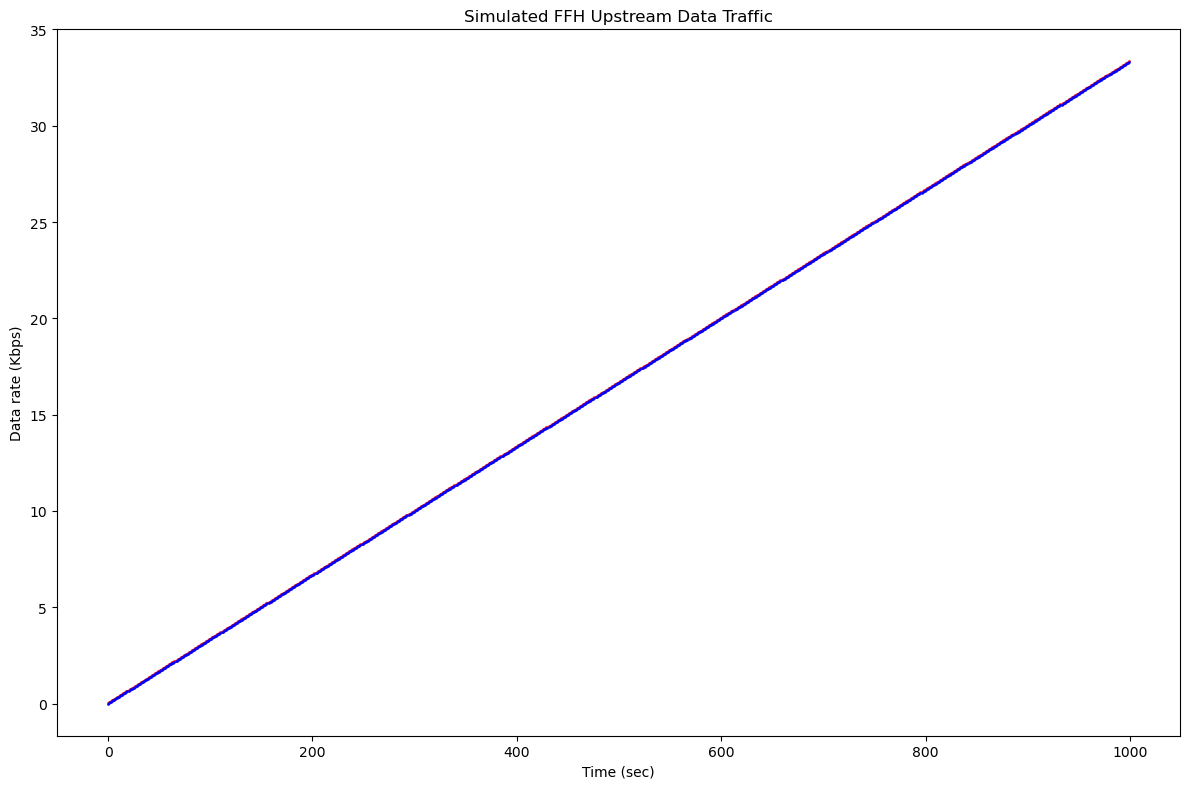

In [33]:
lst_i = [i for i in range(1000)]
lst_std = [0.03333*i for i in range(1000)]
lst_core_interval_accum = []
j_sum = 0
for j in range(1000):
    j_sum += lst_core_interval[2000+j]
    lst_core_interval_accum.append(j_sum)
    
_, ax = plt.subplots()
ax.scatter(lst_i, lst_core_interval_accum, s = 5, color = 'r', alpha = 0.75, marker='.')
ax.scatter(lst_i, lst_std, s = 5, color = 'b', alpha = 0.75, marker='.')
ax.set_title("Simulated FFH Upstream Data Traffic")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Data rate (Kbps)")
# x_xlim = [300, 460]
# ax.set_xlim(x_xlim[0], x_xlim[1])      


Text(0, 0.5, 'Data rate (Kbps)')

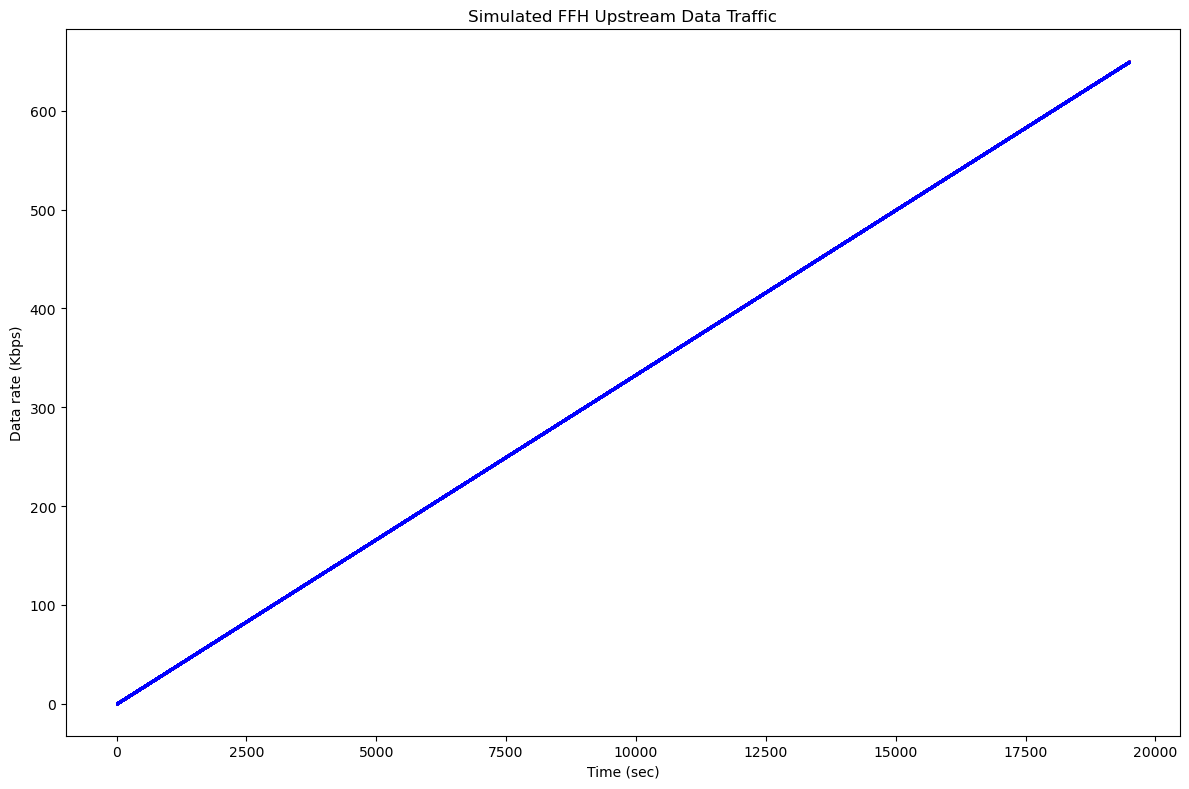

In [34]:
lst_i = [i for i in range(19500)]
lst_std = [0.03333*i for i in range(19500)]
lst_core_interval_accum = []
j_sum = 0
for j in range(19500):
    j_sum += lst_core_interval[j]
    lst_core_interval_accum.append(j_sum)
    
_, ax = plt.subplots()
ax.scatter(lst_i, lst_core_interval_accum, s = 5, color = 'r', alpha = 0.75, marker='.')
ax.scatter(lst_i, lst_std, s = 5, color = 'b', alpha = 0.75, marker='.')
ax.set_title("Simulated FFH Upstream Data Traffic")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Data rate (Kbps)")
# x_xlim = [300, 460]
# ax.set_xlim(x_xlim[0], x_xlim[1])      

0 1000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


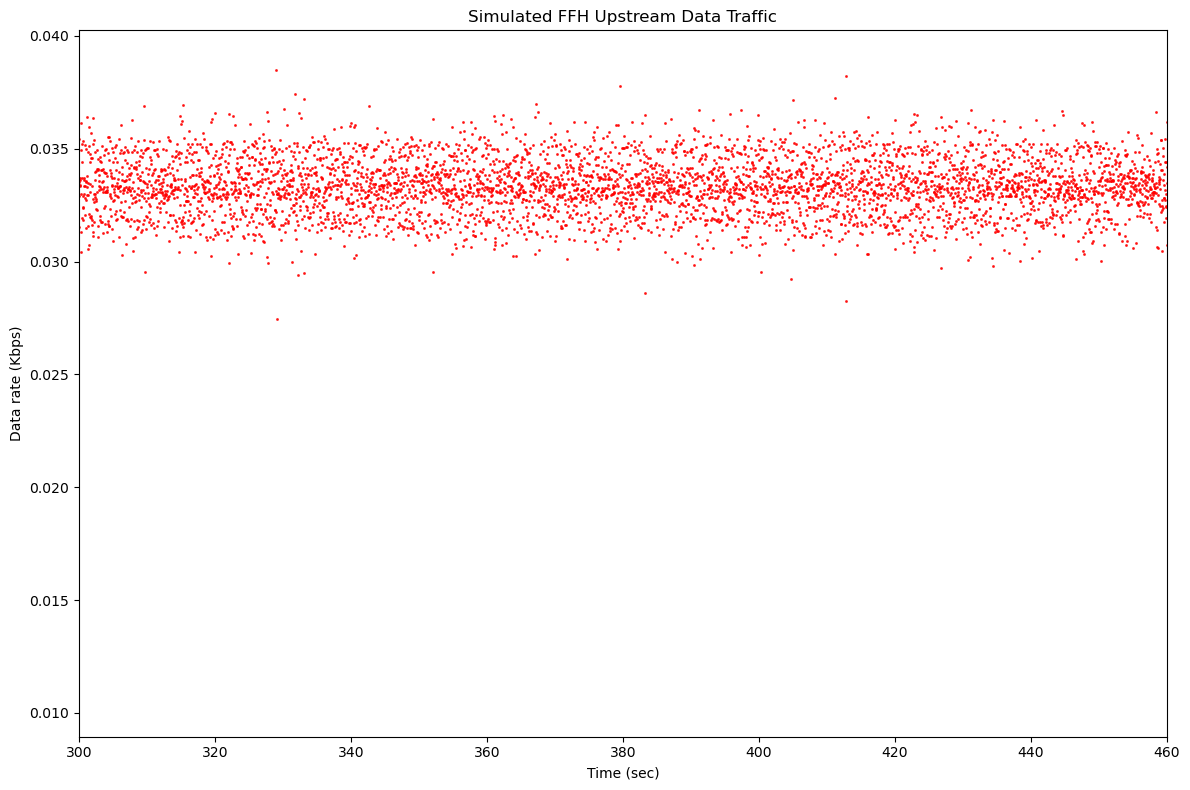

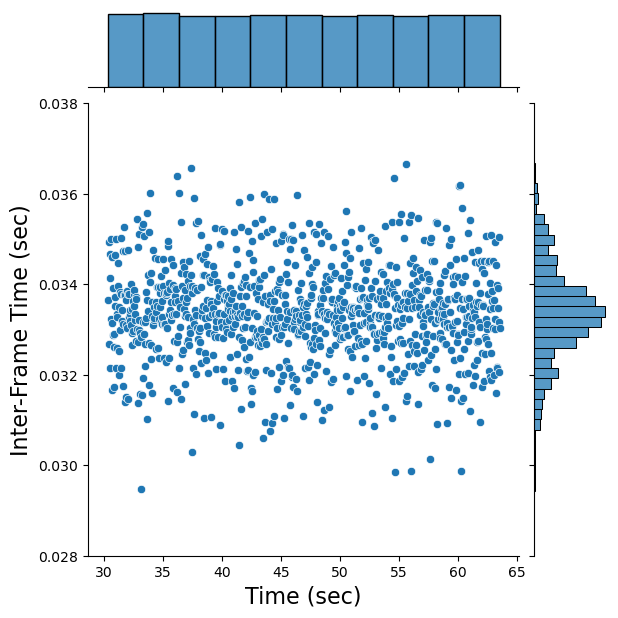

1000 2000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


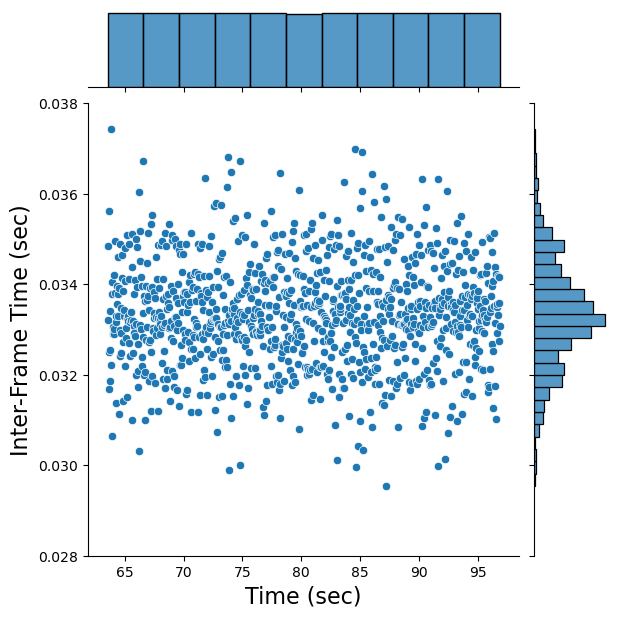

2000 3000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


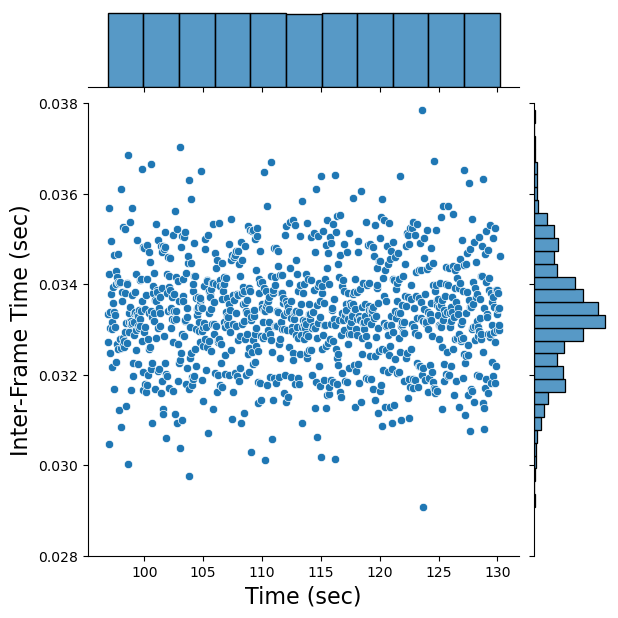

3000 4000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


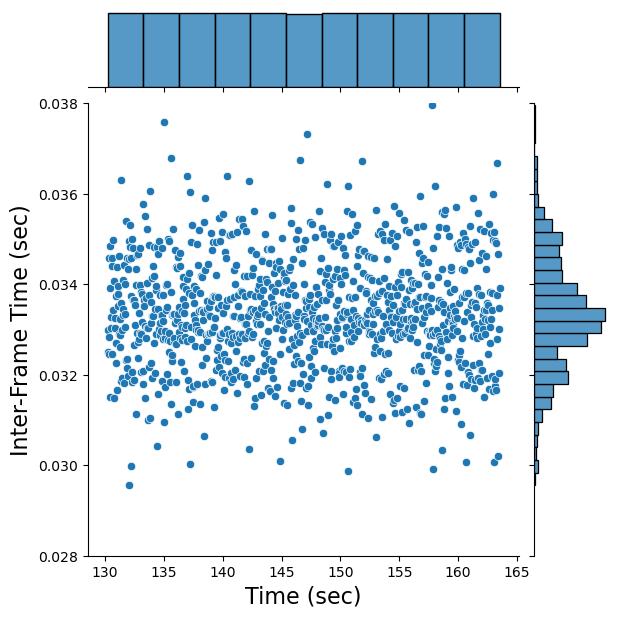

4000 5000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


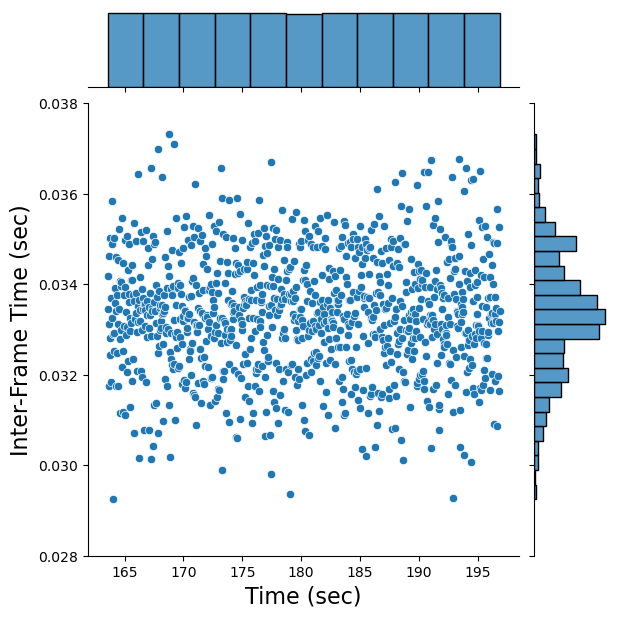

5000 6000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


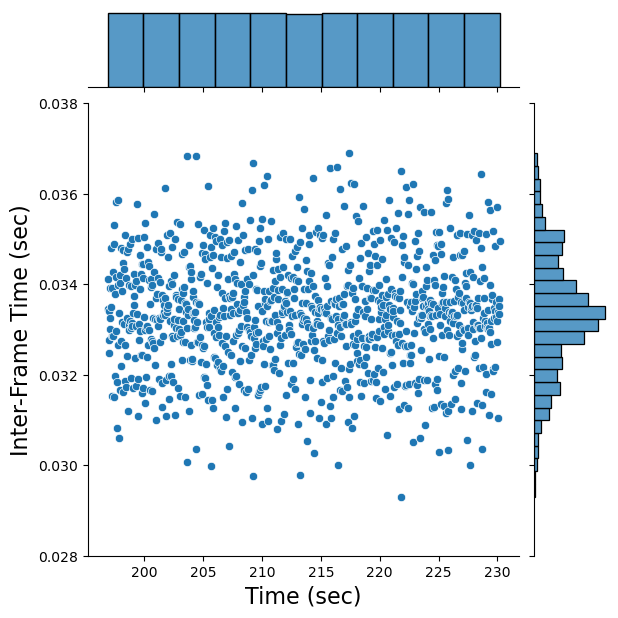

6000 7000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


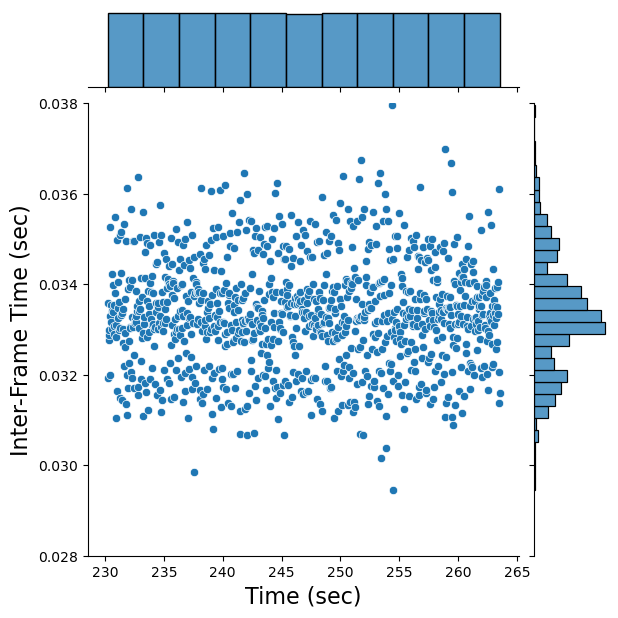

7000 8000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


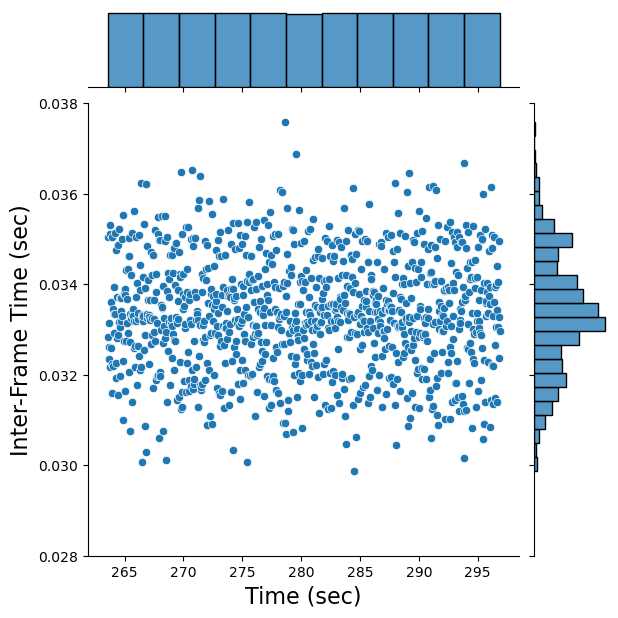

8000 9000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


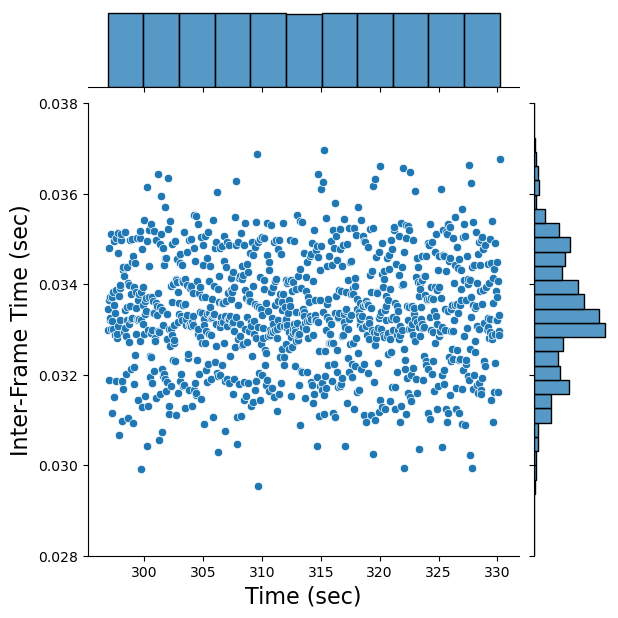

9000 10000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


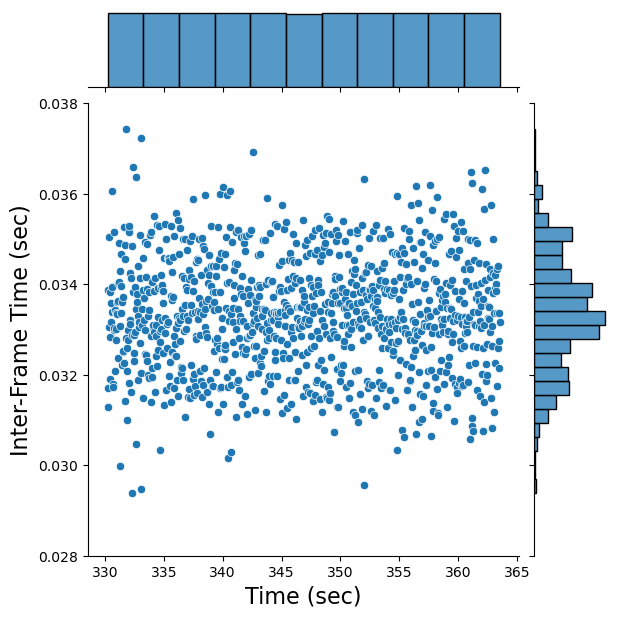

10000 11000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


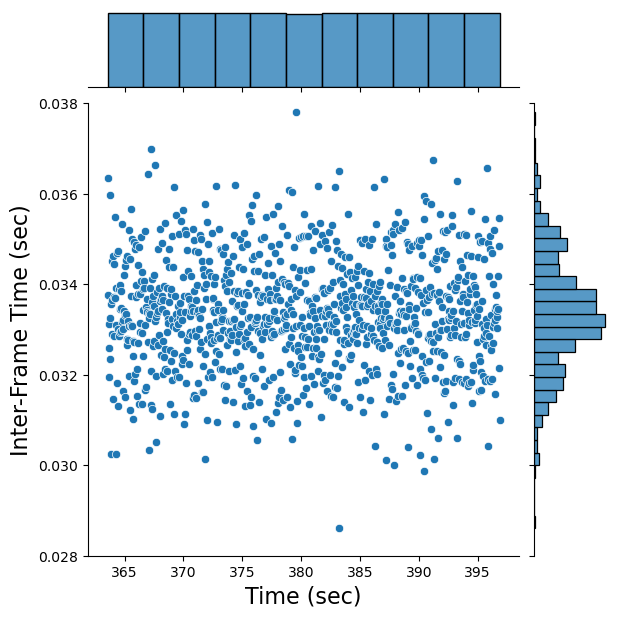

11000 12000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


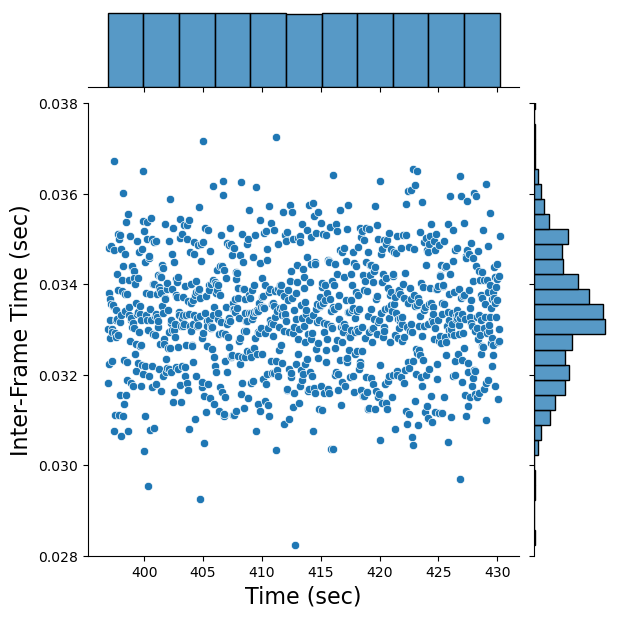

12000 13000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


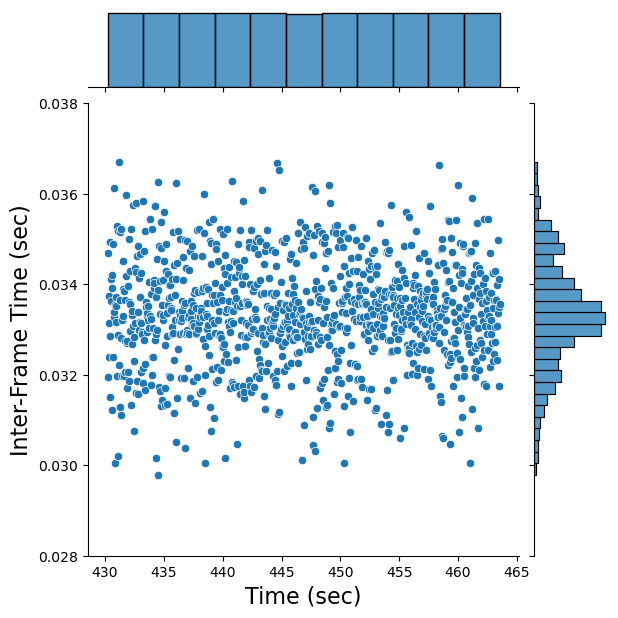

13000 14000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


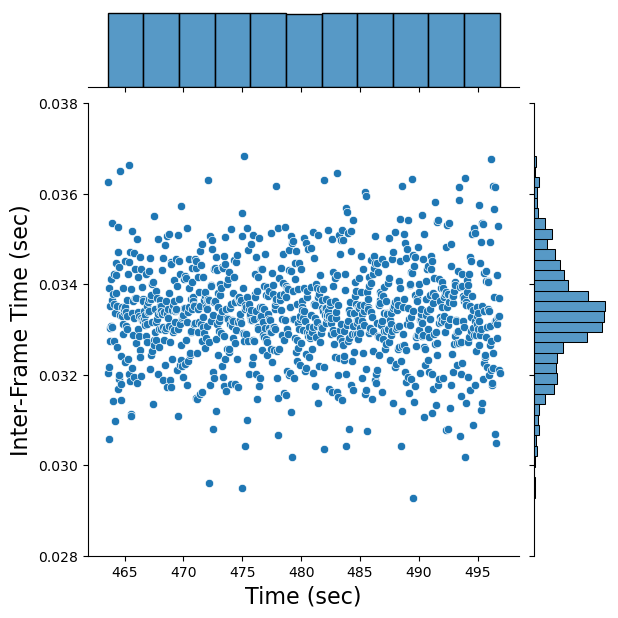

14000 15000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


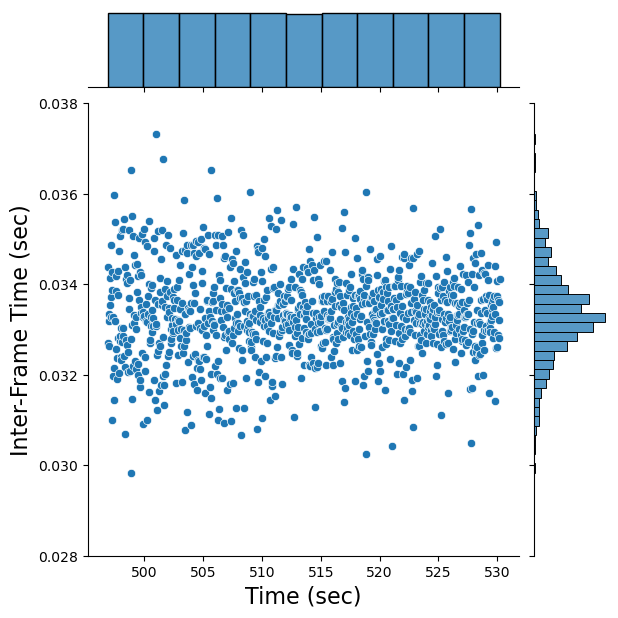

15000 16000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


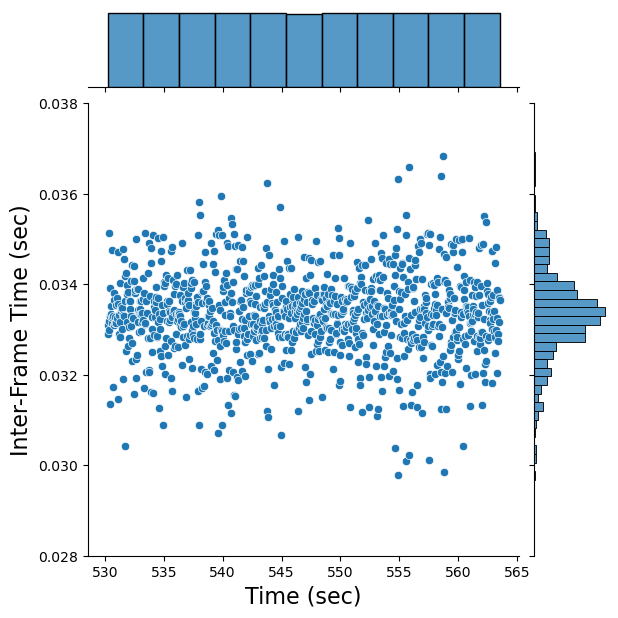

16000 17000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


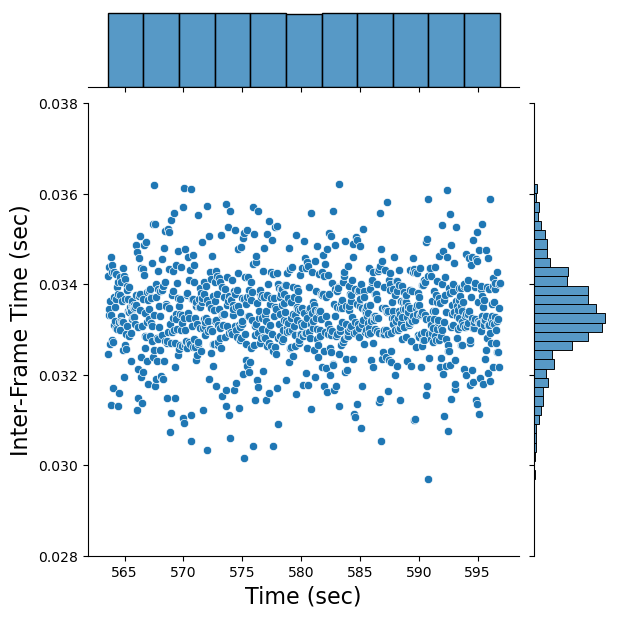

17000 18000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


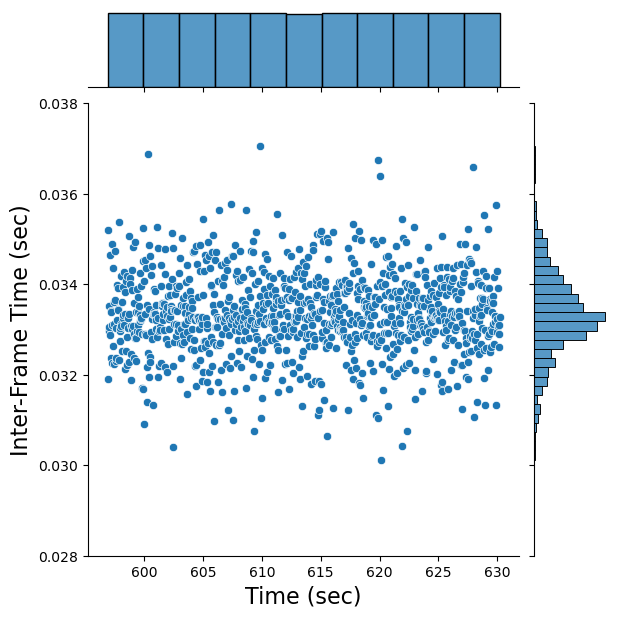

18000 19000


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


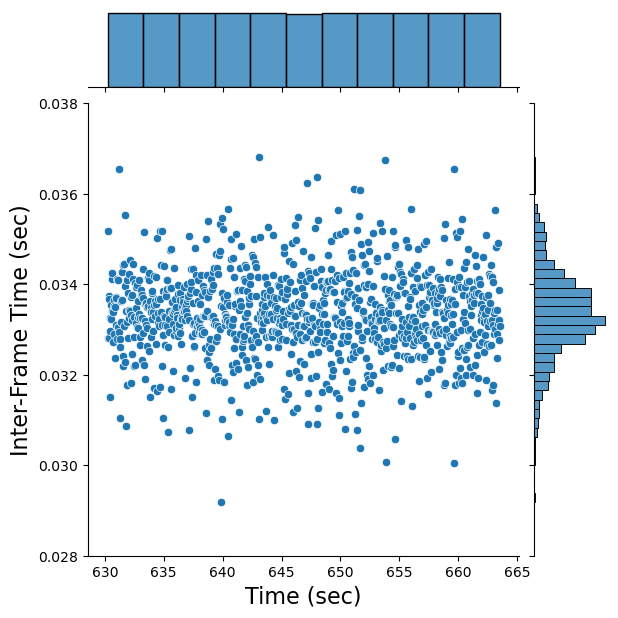

In [35]:
_, ax = plt.subplots()
ax.scatter(lst_core_start_time[:-1], lst_core_interval, s = 5, color = 'r', alpha = 0.75, marker='.')
ax.set_title("Simulated FFH Upstream Data Traffic")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Data rate (Kbps)")
x_xlim = [300, 460]
ax.set_xlim(x_xlim[0], x_xlim[1])  
# ax.set_ylim(0, 30) 

## Check if time matters

for i in range(19):
    print(1000*i, 1000*(i+1))
    i_lst_core_interval = lst_core_interval[1000*i : 1000*(i+1)]
    i_lst_core_start_time = lst_core_start_time[1000*i : 1000*(i+1)]
    h=sns.jointplot(x=i_lst_core_start_time, y=i_lst_core_interval, ylim=[0.028, 0.038], kind='scatter')
    # h.ax_marg_x.grid('on')
#     h.ax_joint.set_yticks([10, 21, 37, 48])
    # h.set_yticklabels(h.get_yticks(), size = 15)
    h.set_axis_labels('Time (sec)', 'Inter-Frame Time (sec)', fontsize=16)
    # sns.jointplot(x=x, y=y, kind='scatter')
    plt.show()
    # h.set_yticklabels(b.get_yticks(), size = 15)


# x = np.array(lst_next_frame_time)
# y = np.array(lst_frame_size)

# sns.set(font_scale=1)



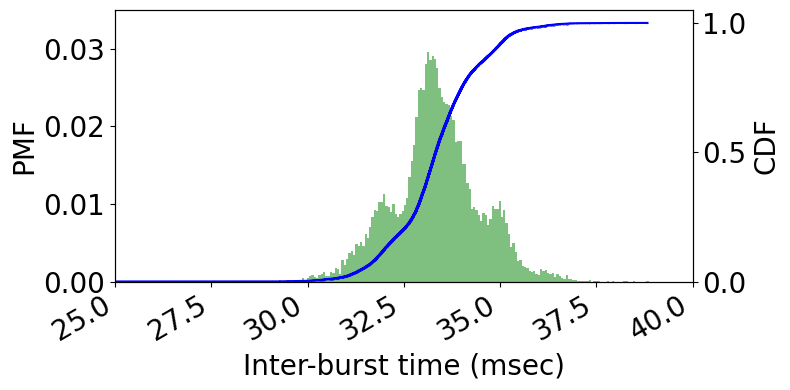

In [36]:
## Plot the PMF and CDF in one plot and show the results in msec
## Ref: https://python-graph-gallery.com/line-chart-dual-y-axis-with-matplotlib/

## 0. Get the msec version data

lst_ibt_msec = [i*1000 for i in lst_core_interval]


## 1. Obtain CDF of the IFT in msec

data_sorted = np.sort(lst_ibt_msec)

# calculate the proportional values of samples
p = 1. * np.arange(len(lst_ibt_msec)) / (len(lst_ibt_msec) - 1)

# Save the CDF and the range for future model implementations
interval_range = data_sorted
interval_cdf = p

# 2. Plot two cures in one plot with their own y axis

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()


# Plot PMF
num_bins = 200

### PMF-like Y axix, ref: https://stackoverflow.com/questions/38650550/cant-get-y-axis-on-matplotlib-histogram-to-display-probabilities
n, bins, patches = ax1.hist(lst_ibt_msec, num_bins,
                           range=[28, 40],
#                             histtype='step',
                            weights=np.ones_like(lst_ibt_msec) / len(lst_ibt_msec),
                            density = False,
                            color ='green',
                            alpha = 0.5)

ax1.set_xlabel("Inter-burst time (msec)", fontsize = 20)
ax1.set_ylabel("PMF", color='k', fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.set_ylim([0, 0.035])
# ax1.tick_params(axis="y", labelcolor=COLOR_TEMPERATURE)

# Plot CDF
ax2.plot(interval_range, interval_cdf, marker='.', markersize=0.1, color='b', alpha=1)
ax2.set_ylabel("CDF", color='k', fontsize=20)
# ax2.tick_params(axis="y", labelcolor=COLOR_PRICE)
ax2.set_ylim([0, 1.05])
ax2.set_xlim([25, 40])
ax2.tick_params(axis='y', labelsize=20)

# fig.suptitle("Temperature down, price up", fontsize=20)
fig.autofmt_xdate()




<Figure size 1200x800 with 0 Axes>

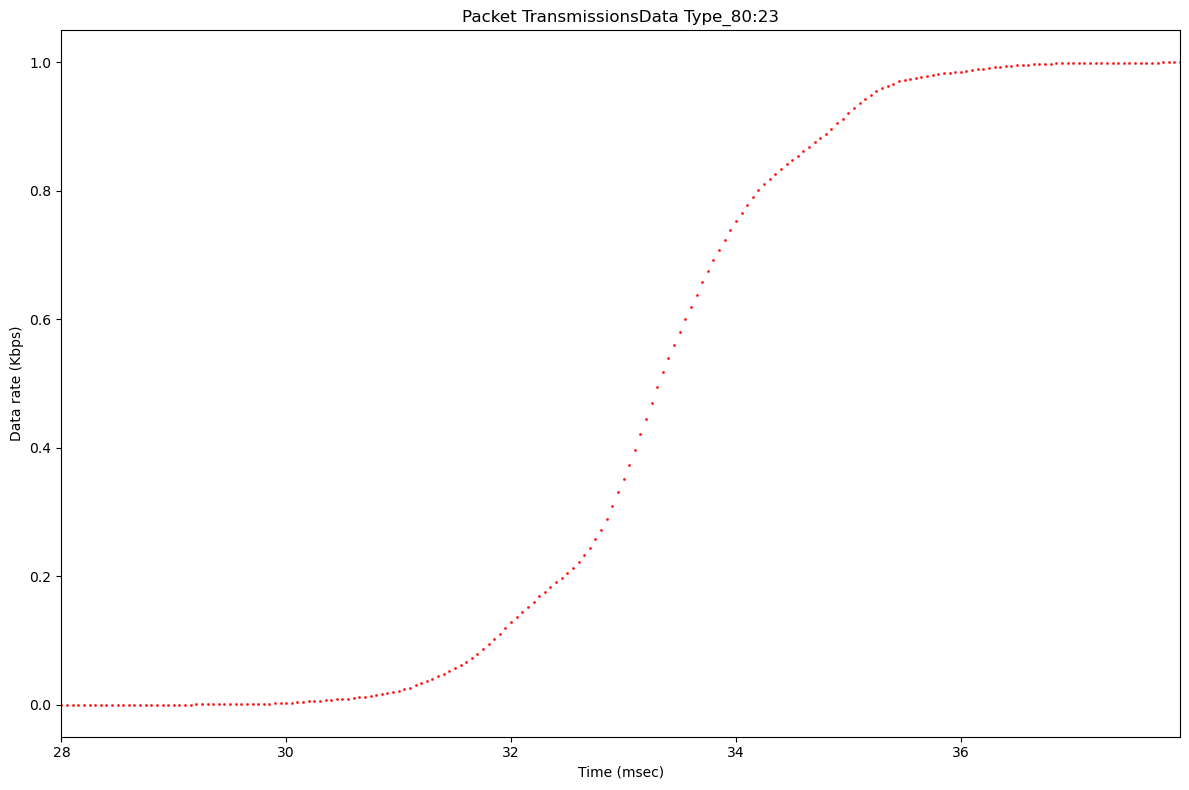

In [37]:
# Plot using ECDF function from statsmodels
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(lst_ibt_msec)

test_vals = [28+i/20 for i in range(200)]
test_cdf = [ecdf(i) for i in test_vals]


x_min_display = min(test_vals)
x_max_display = max(test_vals)
scatterplot(test_vals, test_cdf, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (msec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

29.779911041259766 36.89098358154297
Save the data in the file:  rfh_ds_ibt_msec_cdf.csv
column names:  {'ibt': 0, 'cdf': 1}


<Figure size 1200x800 with 0 Axes>

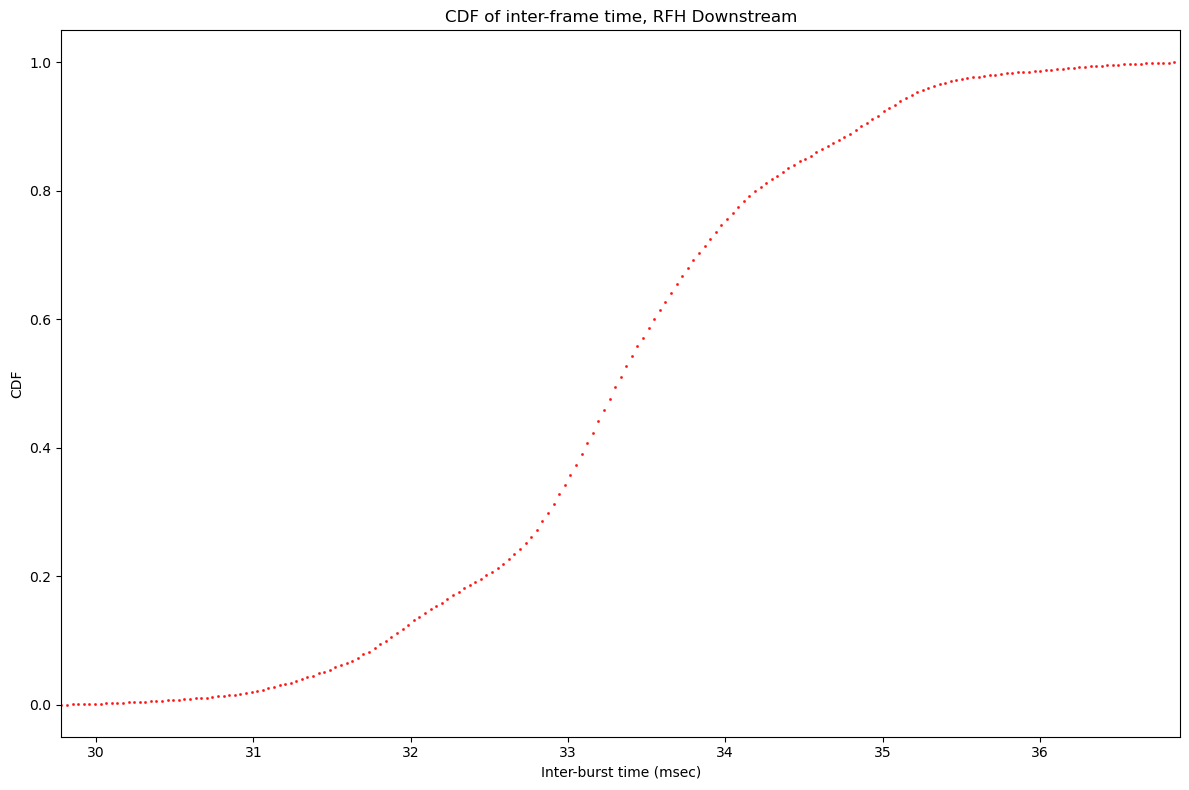

In [38]:
from statsmodels.distributions.empirical_distribution import ECDF

outlier_threshold_ = 3.0
outlier_count_ = 0
mean_var = np.mean(lst_ibt_msec)
std_var = np.std(lst_ibt_msec)

lst_ibt_msec_filtered = [i for i in lst_ibt_msec 
                        if abs(i-mean_var)/std_var <= outlier_threshold_]

data_sorted = np.sort(lst_ibt_msec_filtered) 


func_ecdf = ECDF(data_sorted)

num_sample = 200
min_sample = min(data_sorted)
max_sample = max(data_sorted)
step_sample = (max_sample - min_sample) / num_sample

lst_ibt_msec_export = [i*step_sample + min_sample for i in range(num_sample)]

lst_ibt_cdf_export = [func_ecdf(i) for i in lst_ibt_msec_export]

pic_title = "CDF of inter-frame time, RFH Downstream"
scatterplot(lst_ibt_msec_export, lst_ibt_cdf_export, x_xlim=[min_sample, max_sample], 
            x_label="Inter-burst time (msec)", y_label="CDF", title=pic_title, figSave=True)

print(min_sample, max_sample)
#############################################
## Export the data into CSV
write_file_path = "rfh_ds_ibt_msec_cdf.csv" 
write_header_row = ["ibt", "cdf"]
cols_wrt = {k: v for v, k in enumerate(write_header_row)}

tmp_mat = [[lst_ibt_msec_export[i], lst_ibt_cdf_export[i]] for i in range(len(lst_ibt_cdf_export))]
if len(lst_ibt_msec_export) > 0:
    with open(write_file_path, mode='w', newline='') as wr_file:
        csv_writer = csv.writer(wr_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(write_header_row)
        csv_writer.writerows(tmp_mat)
    #os.remove(csv_file_path)
    #os.rename(write_file_path, csv_file_path)
    
print("Save the data in the file: ", write_file_path)

print("column names: ", cols_wrt)

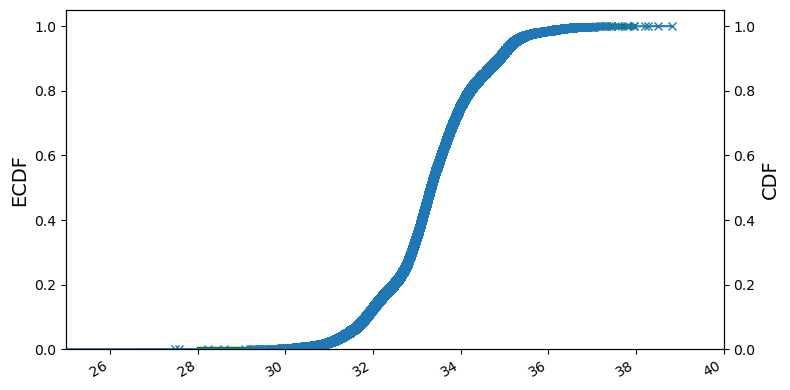

In [39]:
## Plot the PMF and CDF in one plot and show the results in msec
## Ref: https://python-graph-gallery.com/line-chart-dual-y-axis-with-matplotlib/

## 0. Get the msec version data




## 1. Obtain CDF of the IFT in msec

data_sorted = np.sort(lst_ibt_msec)

# calculate the proportional values of samples
p = 1. * np.arange(len(lst_ibt_msec)) / (len(lst_ibt_msec) - 1)

# Save the CDF and the range for future model implementations
interval_range = data_sorted
interval_cdf = p

# 2. Plot two cures in one plot with their own y axis

fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()


# # Plot CDF of samples
# num_bins = 100

# ### PMF-like Y axix, ref: https://stackoverflow.com/questions/38650550/cant-get-y-axis-on-matplotlib-histogram-to-display-probabilities
# n, bins, patches = ax1.hist(lst_ibt_msec, num_bins,
#                            range=[25, 40],
#                             histtype='step',
#                             weights=np.ones_like(lst_ibt_msec) / len(lst_ibt_msec),
#                             density = False,
#                             color ='green',
#                             alpha = 0.7)

# ax1.set_xlabel("Inter-burst time (msec)", fontsize = 14)
# ax1.set_ylabel("PMF", color='k', fontsize=14)
# ax1.set_ylim([0, 0.10])
# # ax1.tick_params(axis="y", labelcolor=COLOR_TEMPERATURE)

ax1.plot(test_vals, test_cdf, color = 'g', marker='.')
ax1.set_ylabel("ECDF", color='k', fontsize=14)
# ax2.tick_params(axis="y", labelcolor=COLOR_PRICE)
ax1.set_ylim([0, 1.05])
ax1.set_xlim([25, 40])

# Plot CDF of samples
ax2.plot(interval_range, interval_cdf, marker='x')
ax2.set_ylabel("CDF", color='k', fontsize=14)
# ax2.tick_params(axis="y", labelcolor=COLOR_PRICE)
ax2.set_ylim([0, 1.05])
ax2.set_xlim([25, 40])


# fig.suptitle("Temperature down, price up", fontsize=20)
fig.autofmt_xdate()

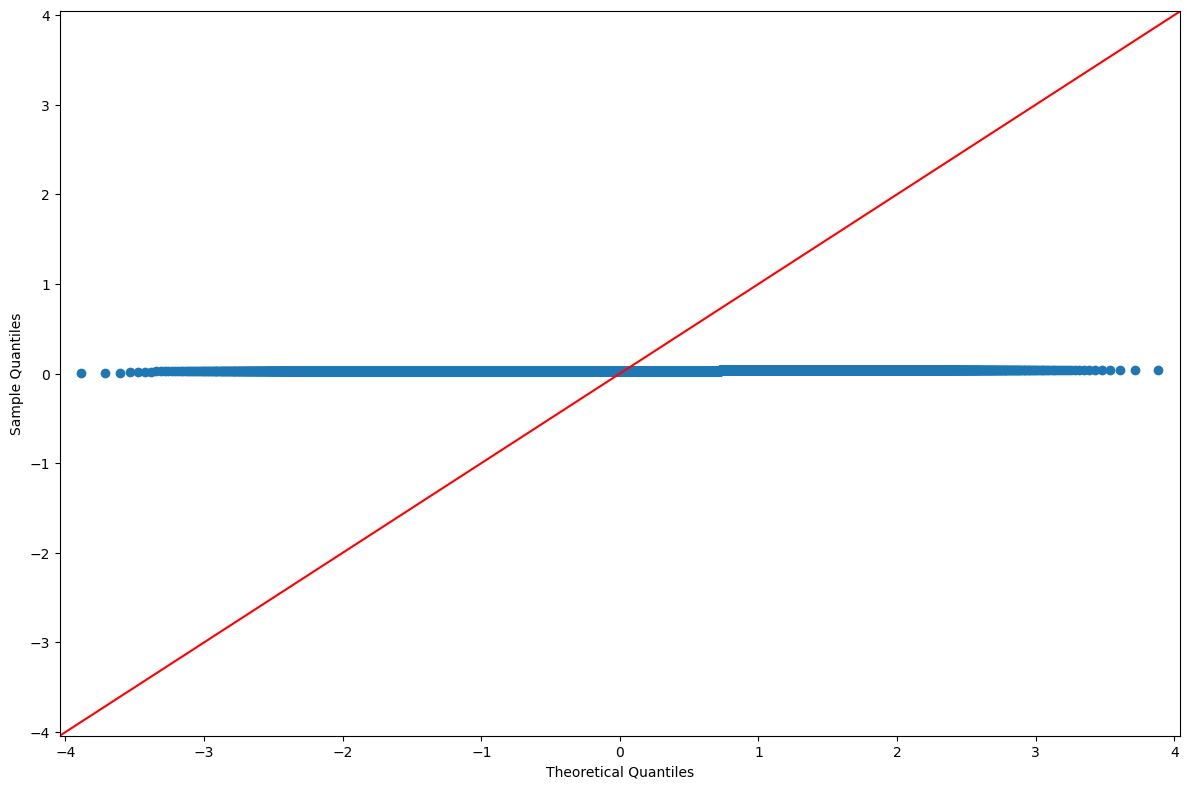

0.033329943365423505 0.0011878937542073819


In [40]:
import statsmodels.api as sm

data = np.array(lst_core_interval)

fig = sm.qqplot(data, line='45')
plt.show()

#The Q-Q plot indicates the inter-burst time is not normally distributed.

from scipy.stats import norm

mu, std = norm.fit(lst_core_interval)

print(mu, std)

### Observation 2

The head frame is usually ahead of the served core frame cluster and the internal between them follows a distribution shown below.

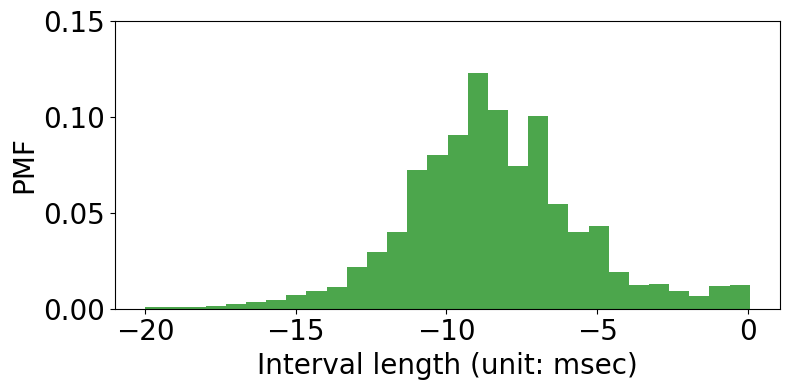

In [41]:
# header to the start of core frames

lst_head_to_core_time = []  # store the time from the head to the core start frame in the same burst

# Note that there are many burst without core frames but only head exists, the list below store these frames
lst_head_abnormal = []

for i in ana_mat_burst_stat:
    i_head_time = i[burst_mat_cols["head.time"]]
    i_core_start_time = i[burst_mat_cols["core.time"]]
    if i_head_time > 0 and i_core_start_time > 0:
        lst_head_to_core_time.append(i_head_time - i_core_start_time)
        
    if i_head_time > 0 and i_core_start_time < 0:
        lst_head_abnormal.append([i[burst_mat_cols["head.time"]], i[burst_mat_cols["head.time.frame"]]])
        
len(lst_head_to_core_time)

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 30

## Plot the histogram of the i-th tags in segments

# x_seq = [i for i in tag_lists[0] if i > 16000]
# x_seq = [i for i in tag_lists[1] if i > 16000]
# x_seq = [i for i in tag_lists[2] if i > 16000]
# x_seq = [i for i in tag_lists[4] if i > 16000]
#x_seq = [i for i in tag_lists[3]]
# x_seq = [i for i in tag_lists[2]]        
# print("selected vs total: ", len(x_seq)/len(tag_lists[4]))

lst_head_to_core_time_msec = [i*1000 for i in lst_head_to_core_time]

# plot the histogram
n, bins, patches = ax.hist(lst_head_to_core_time_msec, num_bins, 
                           weights=np.ones_like(lst_head_to_core_time_msec) / len(lst_head_to_core_time_msec),
#                            range=[-0.005, 0.05],
                            density = False,
                            color ='green',
                            alpha = 0.7)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')

ax.set_xlabel('Interval length (unit: msec)', fontsize = 20)
ax.set_ylabel("PMF", color='k', fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.set_ylim([0, 0.15])

plt.show()

In [42]:
len(lst_head_abnormal)



1735

### Observation 3

The tail frame can be before or after the core frame with the interval length less than 4 msec.

19575


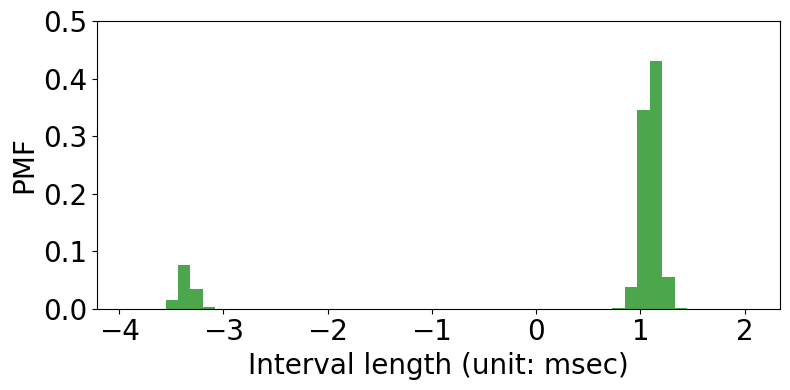

In [43]:
# Tail to the start of core frames

lst_tail_to_core_time = []
lst_tail_to_core_time_abnormal = []

for i in ana_mat_burst_stat:
    i_tail_time = i[burst_mat_cols["tail.time"]]
    i_core_start_time = i[burst_mat_cols["core.time"]]
    if i_tail_time > 0 and i_core_start_time > 0:
        lst_tail_to_core_time.append(i_tail_time - i_core_start_time)
        if i_tail_time - i_core_start_time < 0:
            lst_tail_to_core_time_abnormal.append(i[burst_mat_cols["tail.time.frame"]])
        
print(len(lst_tail_to_core_time))

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 50

## Plot the histogram of the i-th tags in segments

lst_tail_to_core_time_msec = [i*1000 for i in lst_tail_to_core_time]


# plot the histogram
n, bins, patches = ax.hist(lst_tail_to_core_time_msec, num_bins, 
                          weights=np.ones_like(lst_tail_to_core_time_msec) / len(lst_tail_to_core_time_msec),
#                            range=[-0.005, 0.05],
                            density = False,
                            color ='green',
                            alpha = 0.7)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')

ax.set_xlabel('Interval length (unit: msec)', fontsize = 20)
ax.set_ylabel("PMF", color='k', fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.set_ylim([0, 0.5])



plt.show()

In [44]:
# lst_tail_to_core_time_abnormal
len(lst_tail_to_core_time_abnormal)

2547

In [45]:
# The abnormal cases when the burst only contains core frames
for i in ana_mat_burst_stat:
    if i[burst_mat_cols["tail.time"]] < 0 \
    and i[burst_mat_cols["head.time"]] < 0:
        print(i[burst_mat_cols["core.time.frame"]])

1375
1386
1410
2266
2721


### Observation 4

Combined burst size (with core and tail)

Not consider head here. If head is taken into account, the head (max size being 30 bytes) may contribute to additional (30 * 8 * 30 / 1000) ~ 7 kbps traffic load at most. If every burst has one head, it is the stable part. The more interesting part is the varying core and tail frames.

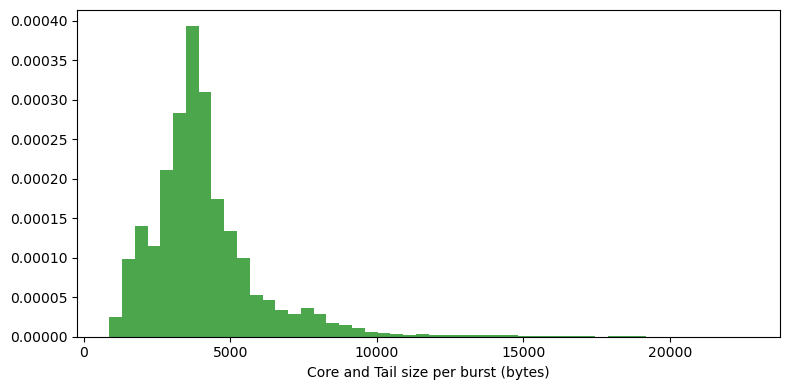

In [46]:
lst_core_and_tail_size = []
for i in ana_mat_burst_stat:
    if i[burst_mat_cols["tail.time"]] > 0 \
    and i[burst_mat_cols["core.time"]] > 0:
        lst_core_and_tail_size.append(i[burst_mat_cols["tail.size"]] + i[burst_mat_cols["core.frame_size"]])
#         print(i[burst_mat_cols["core.time.frame"]])


fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 50

## Plot the histogram of the i-th tags in segments

# x_seq = [i for i in tag_lists[0] if i > 16000]
# x_seq = [i for i in tag_lists[1] if i > 16000]
# x_seq = [i for i in tag_lists[2] if i > 16000]
# x_seq = [i for i in tag_lists[4] if i > 16000]
#x_seq = [i for i in tag_lists[3]]
# x_seq = [i for i in tag_lists[2]]        
# print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


# plot the histogram
n, bins, patches = ax.hist(lst_core_and_tail_size, num_bins, 
#                            range=[-0.005, 0.05],
                            density = 1,
                            color ='green',
                            alpha = 0.7)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')


plt.xlabel('Core and Tail size per burst (bytes)')
# plt.ylabel('Y-Axis')

# title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
#                                                                        phase_state, phase_state_term, \
#                                                                       len(lst_core_start_time))

# plt.title(title_print,
#           fontweight = "bold")

plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


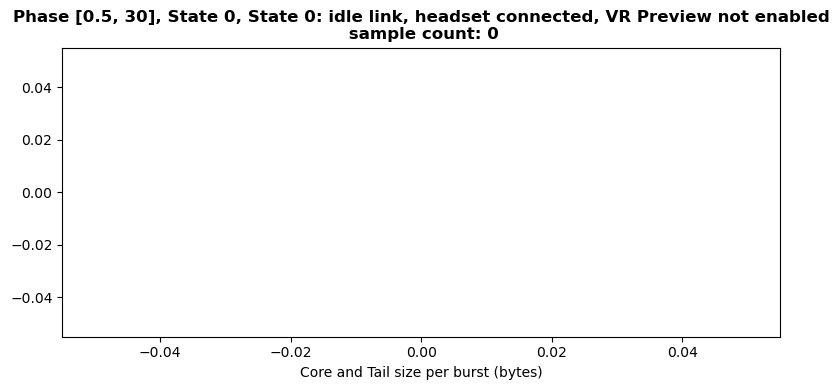

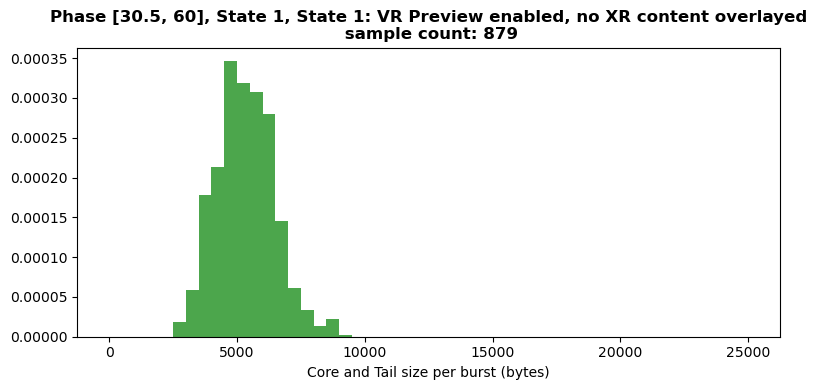

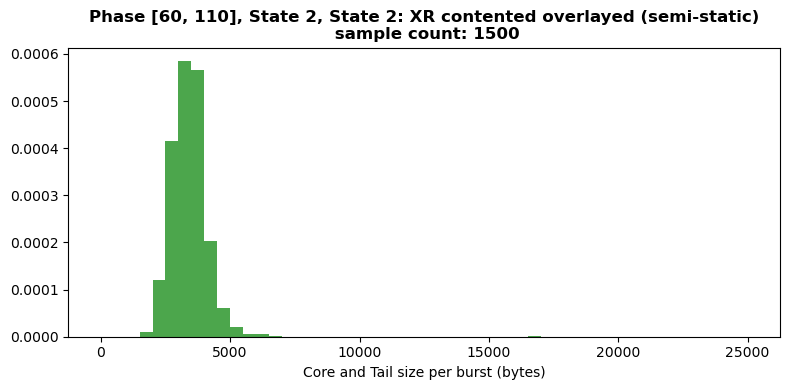

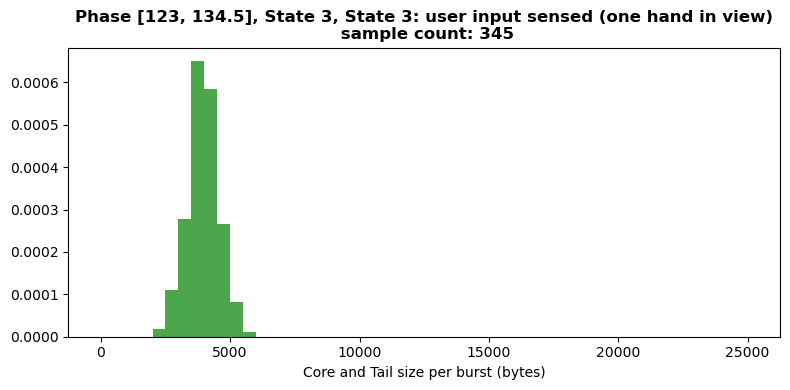

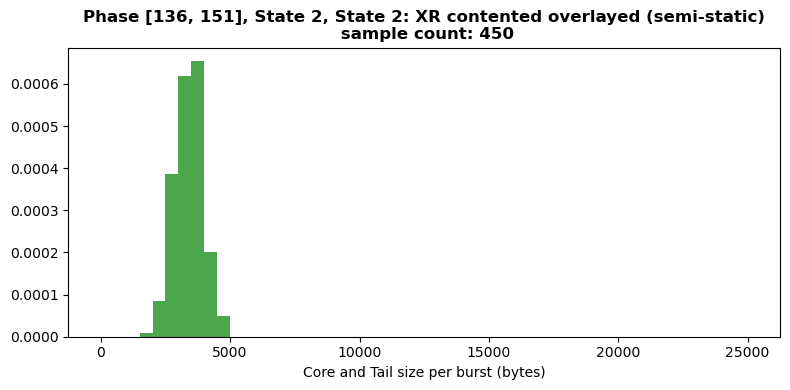

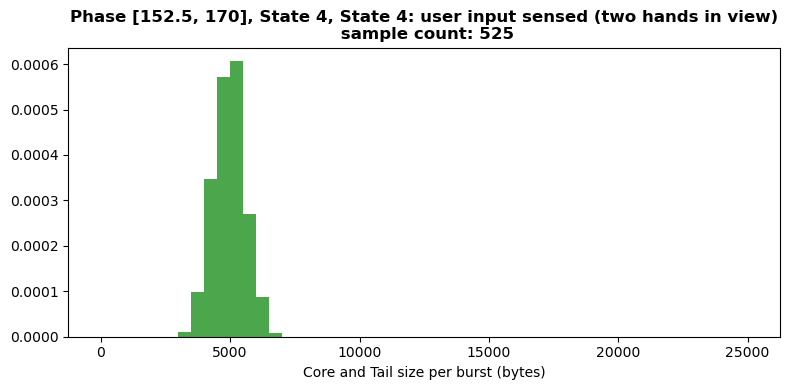

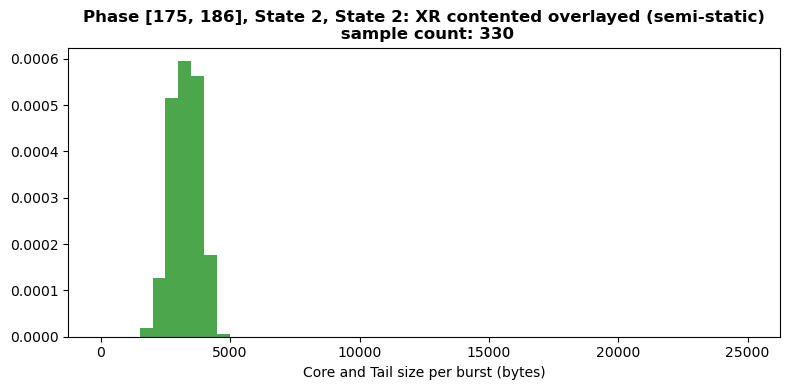

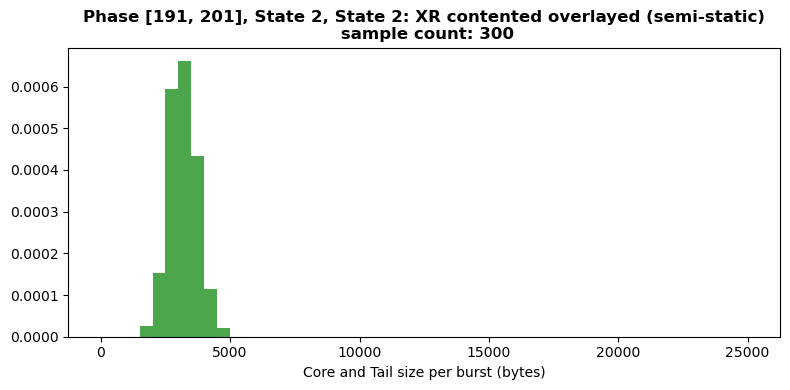

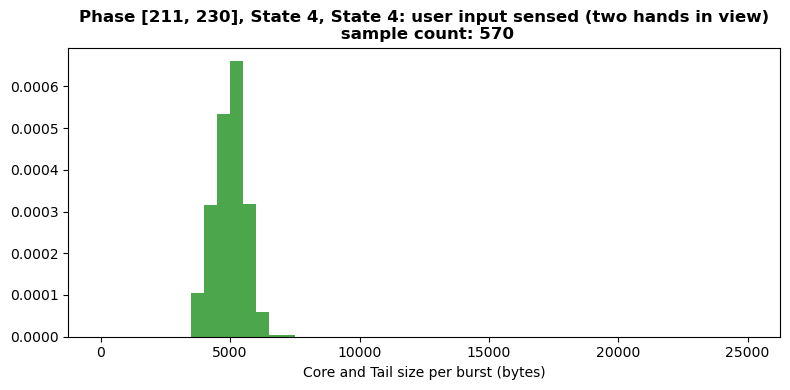

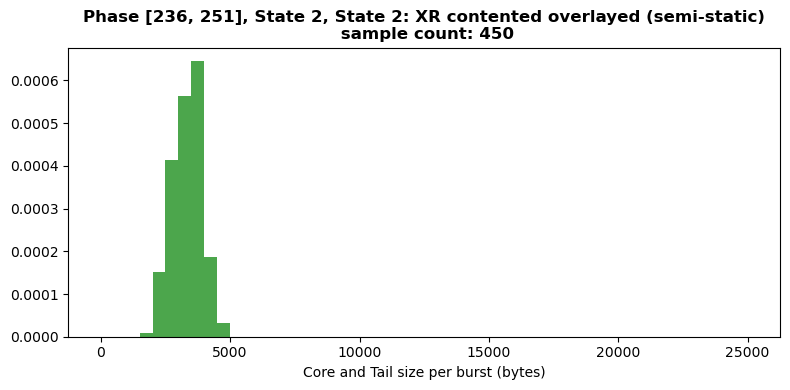

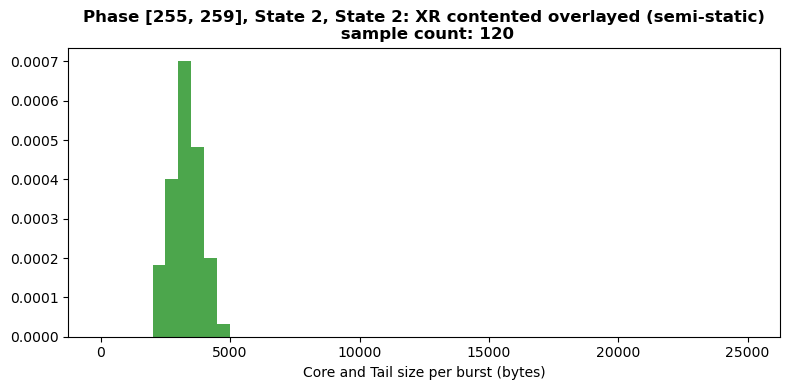

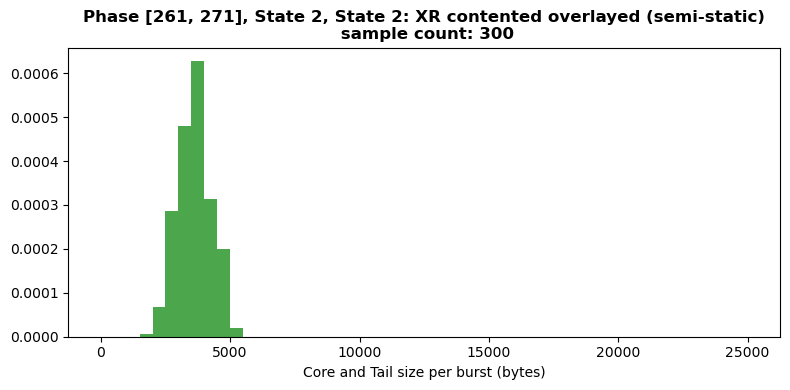

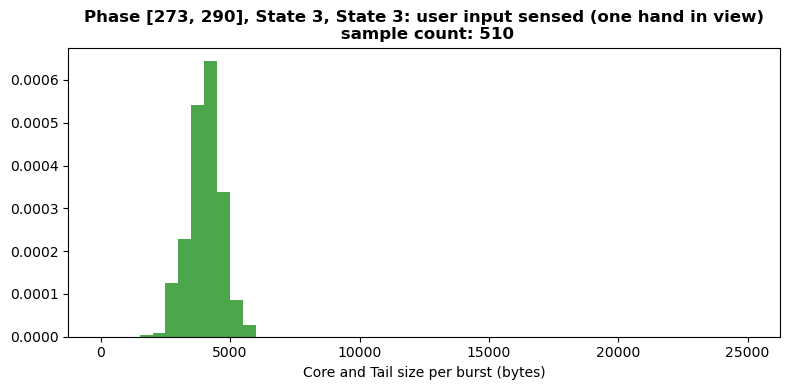

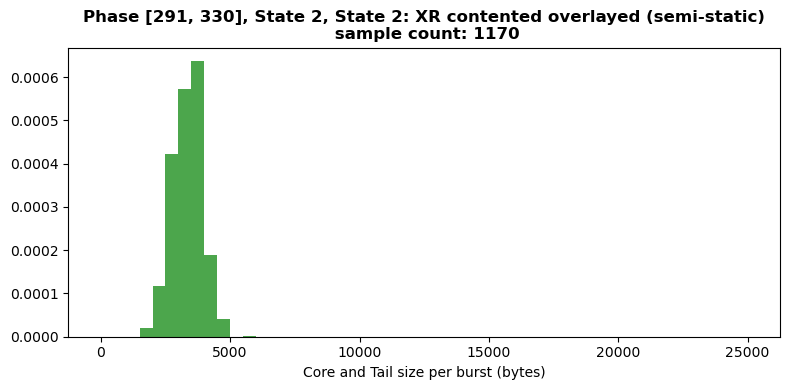

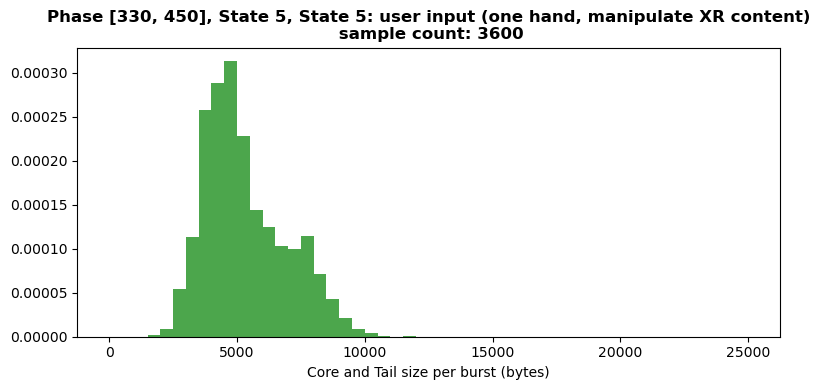

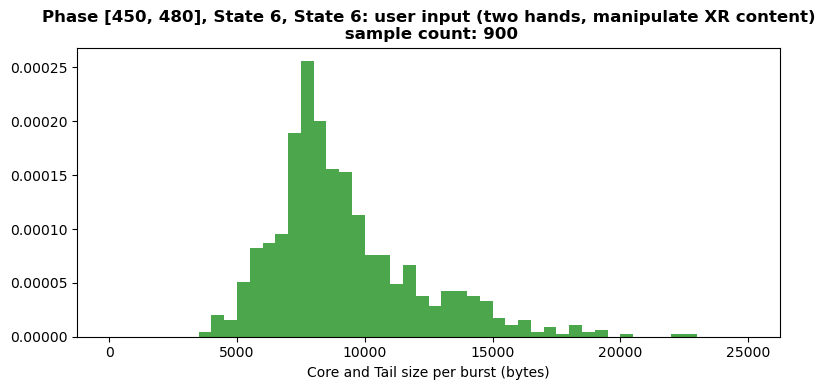

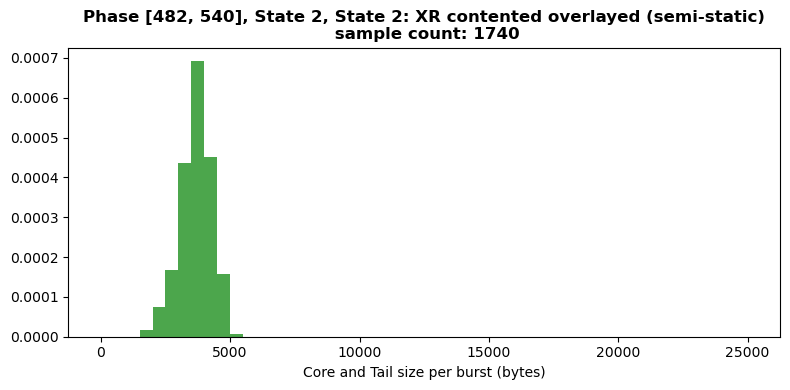

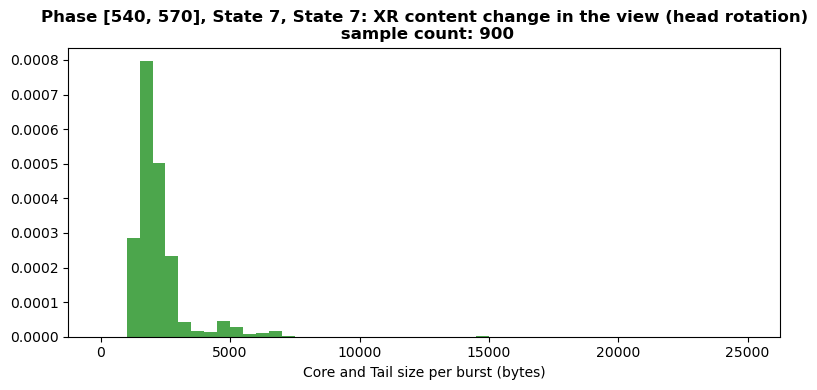

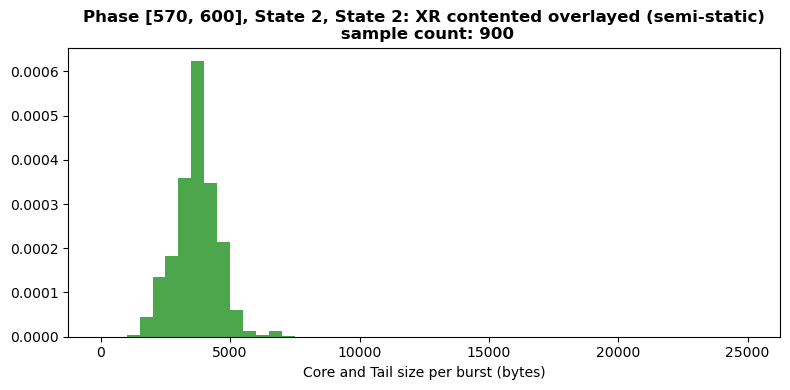

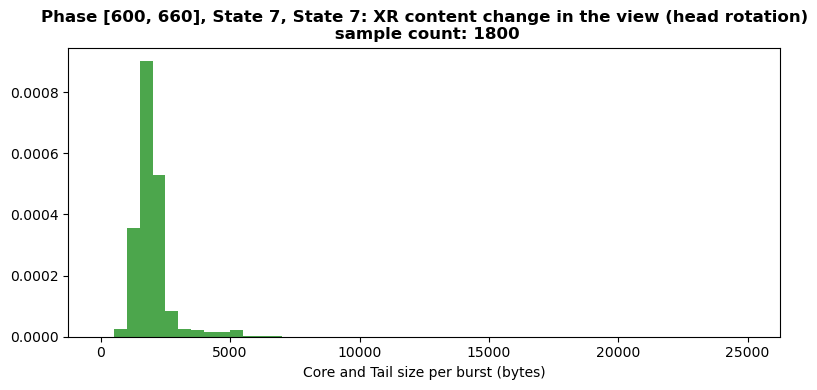

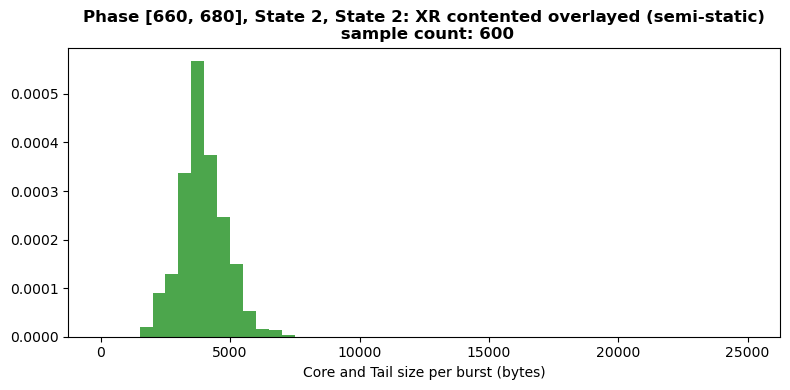

In [47]:
# Core + Tail size (Version 2, phase wise)


for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    ana_mat_burst_state_phased = []
    
    for j in ana_mat_burst_stat:
        if j[burst_mat_cols["burst.time"]] > phase_end_time:
            break
        if j[burst_mat_cols["burst.time"]] > phase_start_time:
            ana_mat_burst_state_phased.append(j.copy())

            
    lst_core_and_tail_size = []
    for i in ana_mat_burst_state_phased:
        if i[burst_mat_cols["tail.time"]] > 0 \
        and i[burst_mat_cols["core.time"]] > 0:
            lst_core_and_tail_size.append(i[burst_mat_cols["tail.size"]] + i[burst_mat_cols["core.frame_size"]])
    #         print(i[burst_mat_cols["core.time.frame"]])


    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = 50

    ## Plot the histogram of the i-th tags in segments

    # x_seq = [i for i in tag_lists[0] if i > 16000]
    # x_seq = [i for i in tag_lists[1] if i > 16000]
    # x_seq = [i for i in tag_lists[2] if i > 16000]
    # x_seq = [i for i in tag_lists[4] if i > 16000]
    #x_seq = [i for i in tag_lists[3]]
    # x_seq = [i for i in tag_lists[2]]        
    # print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


    # plot the histogram
    n, bins, patches = ax.hist(lst_core_and_tail_size, num_bins, 
                               range=[-0.005, 25000],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    # plot the cumulative histogram
    # n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
    #                            cumulative=True, label='Empirical')


    plt.xlabel('Core and Tail size per burst (bytes)')
    # plt.ylabel('Y-Axis')

    title_print = "Phase [{}, {}], State {}, {}\n sample count: {}".format(phase_start_time, phase_end_time, \
                                                                           phase_state, phase_state_term, \
                                                                          len(lst_core_and_tail_size))

    plt.title(title_print,
              fontweight = "bold")

    plt.show()

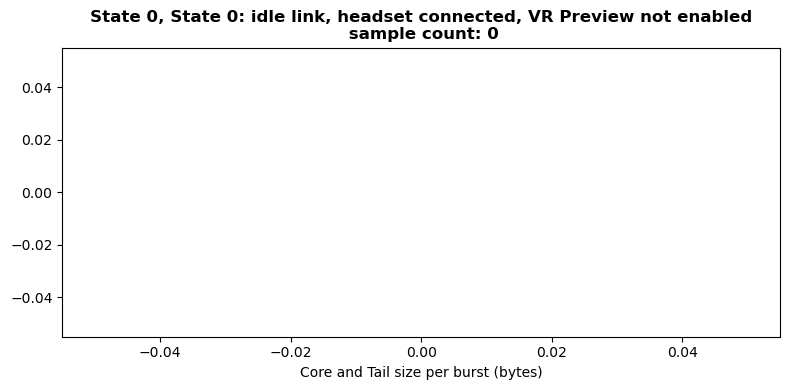

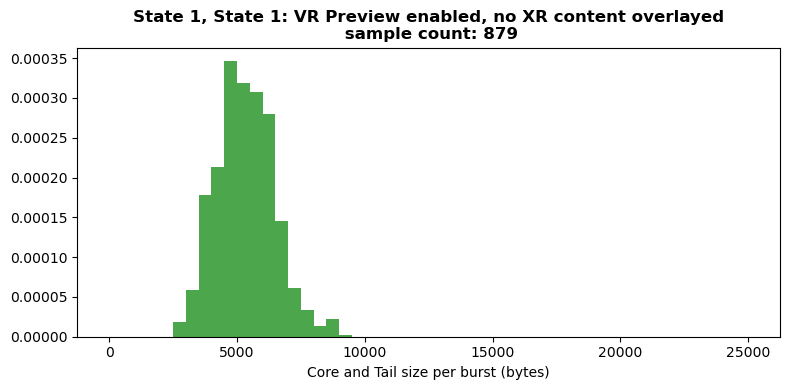

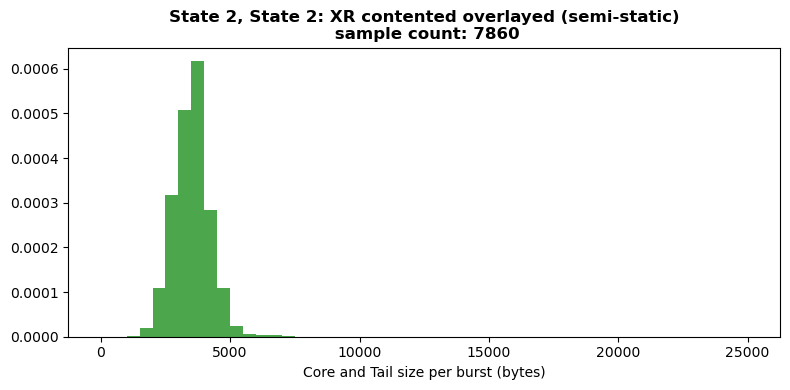

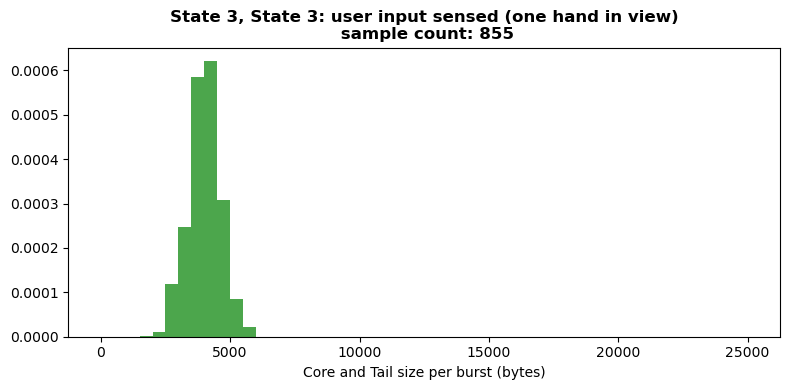

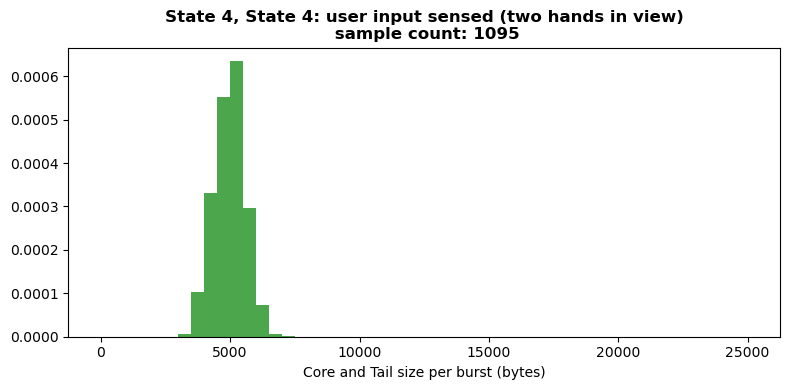

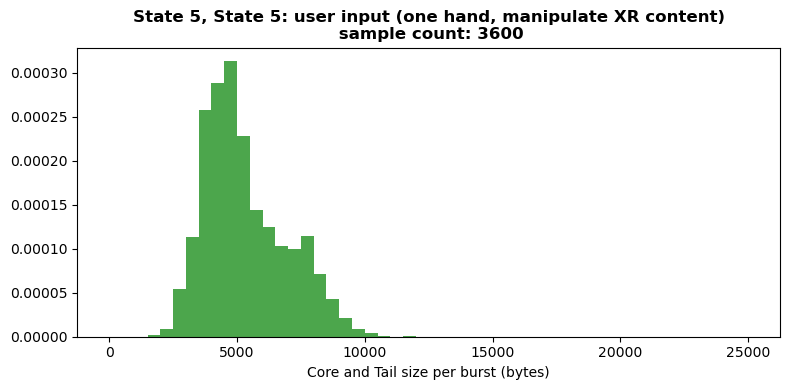

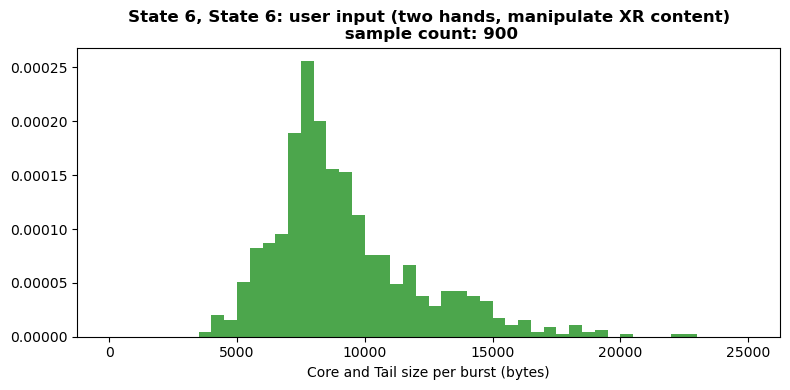

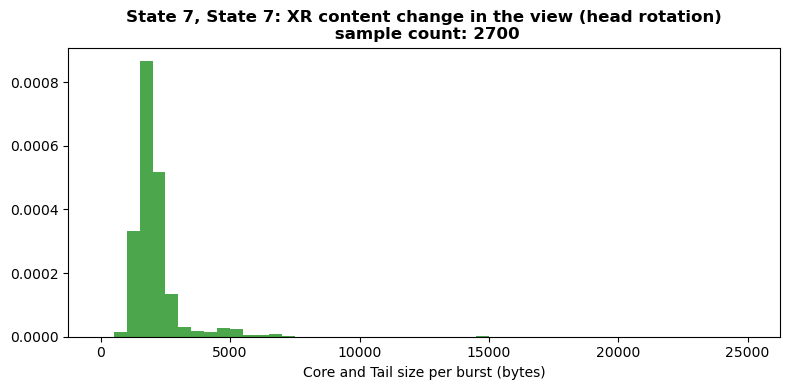

In [48]:
# Core + Tail size (Version 3, state-phase wise)

list_of_lst_core_tail_sum_size = [[] for i in dict_op_state_def]


for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    ana_mat_burst_state_phased = []
    
    for j in ana_mat_burst_stat:
        if j[burst_mat_cols["burst.time"]] > phase_end_time:
            break
        if j[burst_mat_cols["burst.time"]] > phase_start_time:
            ana_mat_burst_state_phased.append(j.copy())

            
    lst_core_and_tail_size = []
    for i in ana_mat_burst_state_phased:
        if i[burst_mat_cols["tail.time"]] > 0 \
        and i[burst_mat_cols["core.time"]] > 0:
            list_of_lst_core_tail_sum_size[phase_state].append(i[burst_mat_cols["tail.size"]] + i[burst_mat_cols["core.frame_size"]])
    #         print(i[burst_mat_cols["core.time.frame"]])

for phase_state in range(len(dict_op_state_def)):
    phase_state_term = dict_op_state_def[phase_state]

    fig, ax = plt.subplots(figsize=(8, 4))

    num_bins = 50

    ## Plot the histogram of the i-th tags in segments

    # x_seq = [i for i in tag_lists[0] if i > 16000]
    # x_seq = [i for i in tag_lists[1] if i > 16000]
    # x_seq = [i for i in tag_lists[2] if i > 16000]
    # x_seq = [i for i in tag_lists[4] if i > 16000]
    #x_seq = [i for i in tag_lists[3]]
    # x_seq = [i for i in tag_lists[2]]        
    # print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


    # plot the histogram
    n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[phase_state], num_bins, 
                               range=[-0.005, 25000],
                                density = 1,
                                color ='green',
                                alpha = 0.7)

    #plot the cumulative histogram
#     n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[phase_state], num_bins, density=True, histtype='step',
#                                cumulative=True, label='Empirical')


    plt.xlabel('Core and Tail size per burst (bytes)')
    # plt.ylabel('Y-Axis')

    title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
                                                                          len(list_of_lst_core_tail_sum_size[phase_state]))

    plt.title(title_print,
              fontweight = "bold")

    plt.show()

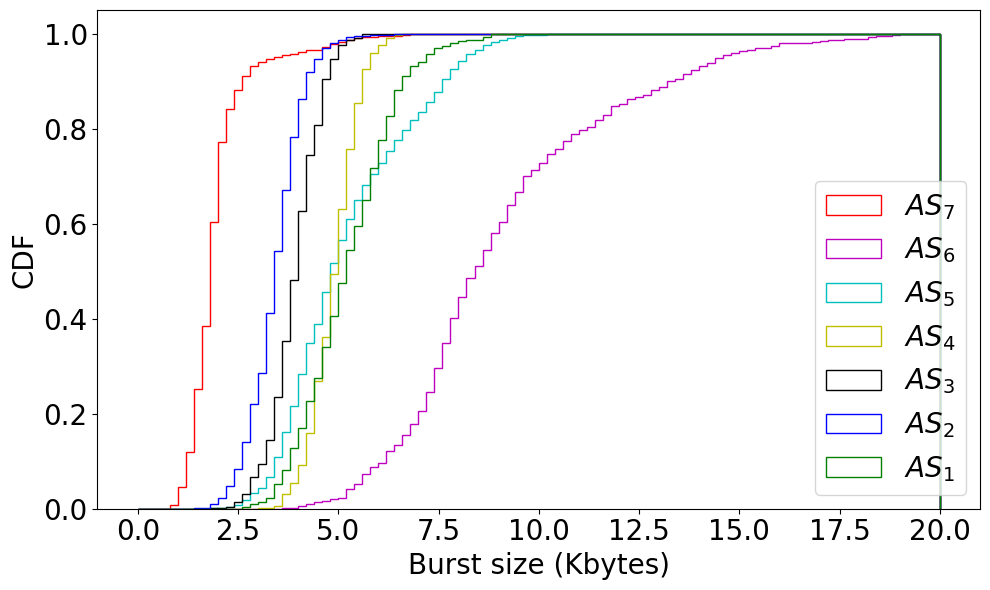

In [49]:
# Core + Tail size (Version 3, state-phase wise)

list_of_lst_core_tail_sum_size = [[] for i in dict_op_state_def]


for k in lst_phase_record:
    phase_start_time = k[0]
    phase_end_time = k[1]
    phase_state = k[2]
    phase_state_term = dict_op_state_def[phase_state]
    
    ana_mat_burst_state_phased = []
    
    for j in ana_mat_burst_stat:
        if j[burst_mat_cols["burst.time"]] > phase_end_time:
            break
        if j[burst_mat_cols["burst.time"]] > phase_start_time:
            ana_mat_burst_state_phased.append(j.copy())

            
    lst_core_and_tail_size = []
    for i in ana_mat_burst_state_phased:
        if i[burst_mat_cols["tail.time"]] > 0 \
        and i[burst_mat_cols["core.time"]] > 0:
            list_of_lst_core_tail_sum_size[phase_state].append(i[burst_mat_cols["tail.size"]] + i[burst_mat_cols["core.frame_size"]])
    #         print(i[burst_mat_cols["core.time.frame"]])
    
    
color_vec = ['w', 'g', 'b', 'k', 'y', 'c', 'm', 'r']

# for phase_state in range(len(dict_op_state_def)):
#     phase_state_term = dict_op_state_def[phase_state]

fig, ax = plt.subplots(figsize=(10, 6))

num_bins = 100

## Plot the histogram of the i-th tags in segments

# x_seq = [i for i in tag_lists[0] if i > 16000]
# x_seq = [i for i in tag_lists[1] if i > 16000]
# x_seq = [i for i in tag_lists[2] if i > 16000]
# x_seq = [i for i in tag_lists[4] if i > 16000]
#x_seq = [i for i in tag_lists[3]]
# x_seq = [i for i in tag_lists[2]]        
# print("selected vs total: ", len(x_seq)/len(tag_lists[4]))


list_of_lst_core_tail_sum_size_kbyte = []

for i in list_of_lst_core_tail_sum_size:
    i_as_lst = [j/1000 for j in i]
    list_of_lst_core_tail_sum_size_kbyte.append(i_as_lst)
        


# plot the histogram
n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size_kbyte, num_bins, 
                           range=[-0.005, 20], 
                            density = 1, histtype='step', 
                            color =color_vec,
                           label = ["", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                           cumulative=True,
                            alpha = 1)


#     n, bins, patches = ax.hist(list_of_lst_next_frame_interval, num_bins,
#                            range=[0.006, 0.012],
#                             density = 1, histtype='step', 
#                             color =color_vec,
#                            label = ["$AS_0$", "$AS_1$", "$s_2$", "$s_3$"],
#                             alpha = 0.7)

#plot the cumulative histogram
#     n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[phase_state], num_bins, density=True, histtype='step',
#                                cumulative=True, label='Empirical')


plt.xlabel('Burst size (Kbytes)', fontsize=20)
plt.ylabel('CDF', fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# ax1.set_ylim([0, 0.06])
# plt.ylabel('Y-Axis')

# title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
#                                                                       len(list_of_lst_core_tail_sum_size[phase_state]))

# plt.title(title_print,
#           fontweight = "bold")
plt.legend(loc='lower right', fontsize=20) #(loc='upper right') 
plt.show()
    
    
    
   

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


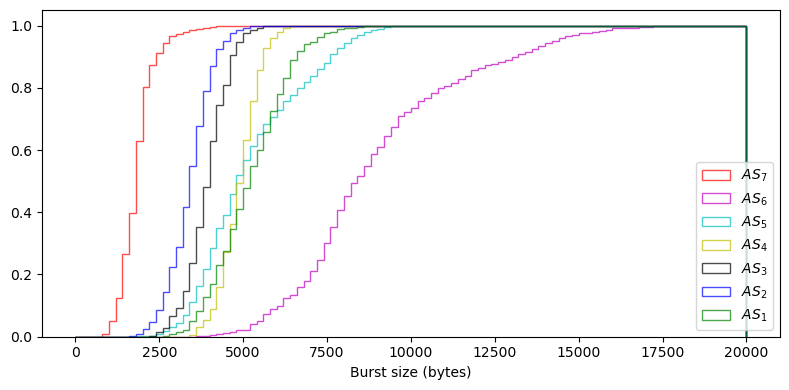

Save the data in the file:  rfh_ds_burst_size_cdf.csv
column names:  {'app_state': 0, 'burst_size': 1, 'cdf': 2}


In [50]:
list_of_lst_core_tail_sum_size_filtered = []

outlier_threshold = 3.0

for i in range(len(list_of_lst_core_tail_sum_size)):
    i_lst_size = list_of_lst_core_tail_sum_size[i]
    i_size_mean = np.mean(i_lst_size)
    i_size_std = np.std(i_lst_size)
    i_lst_size_filtered = [j for j in i_lst_size 
                          if abs(j-i_size_mean)/i_size_std <= outlier_threshold]
    list_of_lst_core_tail_sum_size_filtered.append(i_lst_size_filtered)
    
    
color_vec = ['w', 'g', 'b', 'k', 'y', 'c', 'm', 'r']

# for phase_state in range(len(dict_op_state_def)):
#     phase_state_term = dict_op_state_def[phase_state]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 100

# plot the histogram
n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size_filtered, num_bins, 
                           range=[-0.005, 20000], 
                            density = 1, histtype='step', 
                            color =color_vec,
                           label = ["", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                           cumulative=True,
                            alpha = 0.7)


plt.xlabel('Burst size (bytes)')
# plt.ylabel('Y-Axis')

# title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
#                                                                       len(list_of_lst_core_tail_sum_size[phase_state]))

# plt.title(title_print,
#           fontweight = "bold")
plt.legend(loc='lower right') #(loc='upper right') 
plt.show()



#############################################
## Export the data into CSV
write_file_path = "rfh_ds_burst_size_cdf.csv" 
write_header_row = ["app_state", "burst_size", "cdf"]
cols_wrt = {k: v for v, k in enumerate(write_header_row)}


from statsmodels.distributions.empirical_distribution import ECDF



mat_burst_size_export = []

for i in range(len(list_of_lst_core_tail_sum_size_filtered)):
    i_sub_lst = list_of_lst_core_tail_sum_size_filtered[i]
    
    if i_sub_lst == []:
        continue
    
    data_sorted = np.sort(i_sub_lst)
    
    func_ecdf = ECDF(data_sorted)
    
    num_sample = 200
    min_sample = min(data_sorted)
    max_sample = max(data_sorted)
    step_sample = (max_sample - min_sample) / num_sample

    i_sub_lst_export = [i*step_sample + min_sample for i in range(num_sample)]

    i_sub_lst_cdf_export = [func_ecdf(i) for i in i_sub_lst_export]
    
    
    for j in range(len(i_sub_lst_export)):
        mat_burst_size_export.append([i, i_sub_lst_export[j], i_sub_lst_cdf_export[j]])

        


if len(mat_burst_size_export) > 0:
    with open(write_file_path, mode='w', newline='') as wr_file:
        csv_writer = csv.writer(wr_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(write_header_row)
        csv_writer.writerows(mat_burst_size_export)
    #os.remove(csv_file_path)
    #os.rename(write_file_path, csv_file_path)
    
print("Save the data in the file: ", write_file_path)

print("column names: ", cols_wrt)
    

   app_state  burst_size       cdf
0          1    2716.000  0.001145
1          1    2746.005  0.002291
2          1    2776.010  0.002291
3          1    2806.015  0.003436
4          1    2836.020  0.004582
5          1    2866.025  0.004582
6          1    2896.030  0.004582
7          1    2926.035  0.004582
8          1    2956.040  0.008018
9          1    2986.045  0.008018
      app_state  burst_size       cdf
1390          7     4368.10  0.997700
1391          7     4386.49  0.998467
1392          7     4404.88  0.998467
1393          7     4423.27  0.998467
1394          7     4441.66  0.998467
1395          7     4460.05  0.998467
1396          7     4478.44  0.998467
1397          7     4496.83  0.998850
1398          7     4515.22  0.998850
1399          7     4533.61  0.999233
1
2
3
4
5
6
7


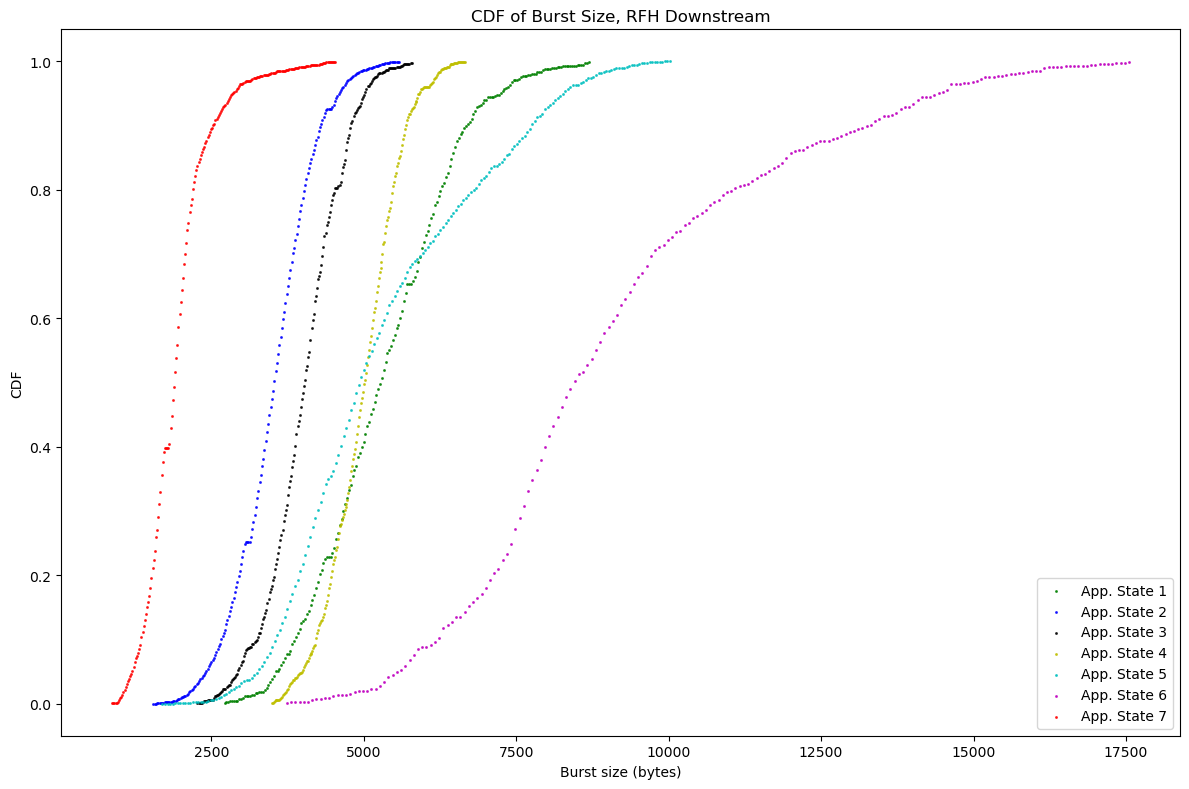

In [51]:
df_rfh_ds_burst_size = pd.read_csv('rfh_ds_burst_size_cdf.csv', delimiter=";")

print(df_rfh_ds_burst_size.head(10))

print(df_rfh_ds_burst_size.tail(10))


list_of_lst_burst_size = []


groups = df_rfh_ds_burst_size.groupby('app_state')

# groups

_, ax = plt.subplots()
color_vec = ['w', 'g', 'b', 'k', 'y', 'c', 'm', 'r']
for app_state, group in groups:
    print(app_state)
    
    list_of_lst_burst_size.append(group.burst_size)
    
    ax.scatter(group.burst_size, group.cdf, s = 5, color = color_vec[app_state], alpha = 0.75, marker='.', label="App. State "+str(app_state))
    
ax.set_title("CDF of Burst Size, RFH Downstream")
ax.set_xlabel("Burst size (bytes)")
ax.set_ylabel("CDF")
ax.legend()
# x_xlim = [29, 37]
# ax.set_xlim(x_xlim[0], x_xlim[1])    
# ax.set_xticks(np.arange(x_xlim[0], x_xlim[1], np.round_((x_xlim[1]-x_xlim[0])/10)))  
    
    


# fig, ax = plt.subplots(figsize=(8, 4))

# num_bins = 200

# # plot the histogram
# n, bins, patches = ax.hist(list_of_lst_burst_size, num_bins, 
#                            range=[-0.005, 20000], 
#                             density = 1, histtype='step', 
#                             color =color_vec,
#                            label = ["$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
#                            cumulative=True,
#                             alpha = 0.7)


# plt.xlabel('Burst size (bytes)')

# plt.legend(loc='lower right') #(loc='upper right') 
# plt.show()

# lst_ibt_msec = df_rfh_ds_ibt.ibt.tolist()
# lst_ibt_sec = [i/1000 for i in lst_ibt_msec]
# lst_ibt_cdf = df_rfh_ds_ibt.cdf.tolist()

# _, ax = plt.subplots()
# ax.scatter(lst_ibt_msec, lst_ibt_cdf, s = 5, color = 'r', alpha = 0.75, marker='.')
# ax.set_title("CDF of Inter-Burst Time, RFH Downstream")
# ax.set_xlabel("Inter-burst time (msec)")
# ax.set_ylabel("CDF")
# x_xlim = [29, 37]
# ax.set_xlim(x_xlim[0], x_xlim[1])    
# # ax.set_xticks(np.arange(x_xlim[0], x_xlim[1], np.round_((x_xlim[1]-x_xlim[0])/10)))  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


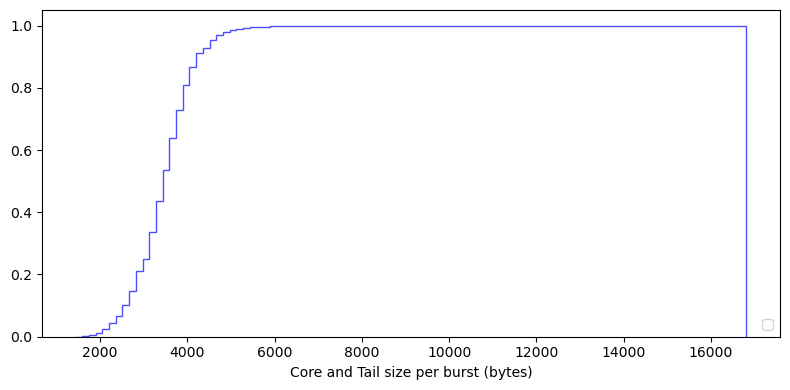

In [52]:
# Core + Tail size (Version 3, state-phase wise)

# list_of_lst_core_tail_sum_size = [[] for i in dict_op_state_def]


# for k in lst_phase_record:
#     phase_start_time = k[0]
#     phase_end_time = k[1]
#     phase_state = k[2]
#     phase_state_term = dict_op_state_def[phase_state]
    
#     ana_mat_burst_state_phased = []
    
#     for j in ana_mat_burst_stat:
#         if j[burst_mat_cols["burst.time"]] > phase_end_time:
#             break
#         if j[burst_mat_cols["burst.time"]] > phase_start_time:
#             ana_mat_burst_state_phased.append(j.copy())

            
#     lst_core_and_tail_size = []
#     for i in ana_mat_burst_state_phased:
#         if i[burst_mat_cols["tail.time"]] > 0 \
#         and i[burst_mat_cols["core.time"]] > 0:
#             list_of_lst_core_tail_sum_size[phase_state].append(i[burst_mat_cols["tail.size"]] + i[burst_mat_cols["core.frame_size"]])
#     #         print(i[burst_mat_cols["core.time.frame"]])
    
    
# color_vec = ['w', 'g', 'b', 'k', 'y', 'c', 'm', 'r']

# for phase_state in range(len(dict_op_state_def)):
#     phase_state_term = dict_op_state_def[phase_state]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 100

## Plot the histogram of the i-th tags in segments

# x_seq = [i for i in tag_lists[0] if i > 16000]
# x_seq = [i for i in tag_lists[1] if i > 16000]
# x_seq = [i for i in tag_lists[2] if i > 16000]
# x_seq = [i for i in tag_lists[4] if i > 16000]
#x_seq = [i for i in tag_lists[3]]
# x_seq = [i for i in tag_lists[2]]        
# print("selected vs total: ", len(x_seq)/len(tag_lists[4]))

plot_index = 2

# plot the histogram
n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[plot_index], num_bins, 
#                            range=[-0.005, 20000], 
#                            range=[1400, 5000], 
                            density = 1, histtype='step', 
                            color =color_vec[plot_index],
#                            label = ["", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                           cumulative=True,
                            alpha = 0.7)


#     n, bins, patches = ax.hist(list_of_lst_next_frame_interval, num_bins,
#                            range=[0.006, 0.012],
#                             density = 1, histtype='step', 
#                             color =color_vec,
#                            label = ["$AS_0$", "$AS_1$", "$s_2$", "$s_3$"],
#                             alpha = 0.7)

#plot the cumulative histogram
#     n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[phase_state], num_bins, density=True, histtype='step',
#                                cumulative=True, label='Empirical')


plt.xlabel('Core and Tail size per burst (bytes)')
# plt.ylabel('Y-Axis')

# title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
#                                                                       len(list_of_lst_core_tail_sum_size[phase_state]))

# plt.title(title_print,
#           fontweight = "bold")
plt.legend(loc='lower right') #(loc='upper right') 
plt.show()
    
    
    
   

In [53]:
# obtain ECDF curve
print("State: {}, min: {}".format(plot_index, min(list_of_lst_core_tail_sum_size[plot_index])))
print("State: {}, max: {}".format(plot_index, max(list_of_lst_core_tail_sum_size[plot_index])))

[i for i in list_of_lst_core_tail_sum_size[plot_index] if i > 7000]

State: 2, min: 1436
State: 2, max: 16810


[16810, 7171, 7196]

In [54]:
sample_list = [i for i in list_of_lst_core_tail_sum_size[plot_index] if i <7200]

<Figure size 1200x800 with 0 Axes>

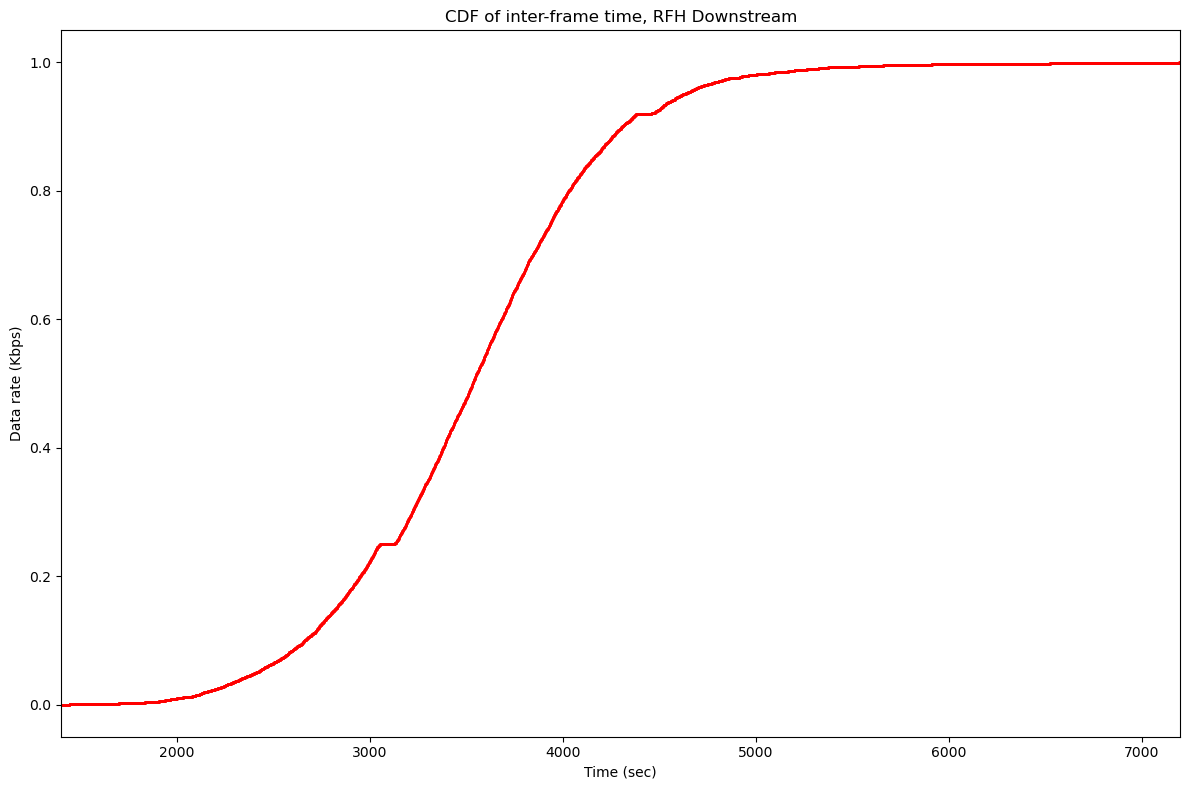

In [55]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(sample_list)

test_vals = [i for i in range(7200) if i > 1400]
test_cdf = [ecdf(i) for i in test_vals]


x_min_display = min(test_vals)
x_max_display = max(test_vals)
scatterplot(test_vals, test_cdf, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")

In [56]:
import statsmodels.api as sm

In [60]:
state_cdf_test = np.array([0.00455063, 0.00796359, 0.01137656, 0.01592719, 0.0182025 ,
       0.03526735, 0.0523322 , 0.07622298, 0.10011377, 0.12741752,
       0.15244596, 0.19226394, 0.22753129, 0.24118316, 0.29124005,
       0.33560865, 0.3811149 , 0.42207053, 0.4596132 , 0.50284414,
       0.54948805, 0.5847554 , 0.63594994, 0.65642776, 0.70193402,
       0.74175199, 0.778157  , 0.814562  , 0.85324232, 0.88168373,
       0.89988623, 0.92263936, 0.93287827, 0.9374289 , 0.94425484,
       0.95449374, 0.96359499, 0.97042093, 0.9738339 , 0.97610922,
       0.9817975 , 0.98293515, 0.98521047, 0.98634812, 0.98748578,
       0.99089875, 0.99317406, 0.99886234, 0.99886234, 1.        ])

In [61]:
state_cdf_test

array([0.00455063, 0.00796359, 0.01137656, 0.01592719, 0.0182025 ,
       0.03526735, 0.0523322 , 0.07622298, 0.10011377, 0.12741752,
       0.15244596, 0.19226394, 0.22753129, 0.24118316, 0.29124005,
       0.33560865, 0.3811149 , 0.42207053, 0.4596132 , 0.50284414,
       0.54948805, 0.5847554 , 0.63594994, 0.65642776, 0.70193402,
       0.74175199, 0.778157  , 0.814562  , 0.85324232, 0.88168373,
       0.89988623, 0.92263936, 0.93287827, 0.9374289 , 0.94425484,
       0.95449374, 0.96359499, 0.97042093, 0.9738339 , 0.97610922,
       0.9817975 , 0.98293515, 0.98521047, 0.98634812, 0.98748578,
       0.99089875, 0.99317406, 0.99886234, 0.99886234, 1.        ])

## Implementation Steps

DL, remote rendering

1. Set up a timer at 30 fps
2. When every time the timer expires, generate a frame size per the state-specific CDF curve
3. reload the timer

A finer version considering the separate frames for head/core/tail
1. set up a timer for the next core cluster at 30 fps
2. determine the timers for head and tails respectively
3. When timers expire, select the frame size per the type of frame and the state
4. reload the timers for the next round

In [63]:
# Input
## Time (IBT): lst_ibt_msec (in msec), or lst_core_interval (in sec)
## Burst size (byte) specific to Application State (plot_index): list_of_lst_core_tail_sum_size[plot_index]

# Output
## sequence of (burst time, burst size)

import random
import time


# given an empirical CDF list, return the index of a random variable following the CDF
def rand_index_gen(lst_cdf):
    random.seed(int(str(time.time()).split('.')[1]))
    random.uniform(0, 1)
#     print("Input CDF curve: ", lst_cdf)
    tmp_rand = random.uniform(0, 1) # generate a random number between 0 and 1
#     print("ramdom number in [0, 1]: ", tmp_rand)
    
    # the input, lst_cdf, is supported to be sorted in the ascending order
    lst_less_eq = [i for i in lst_cdf if i <= tmp_rand]
#     print(lst_less_eq)
    
    idx_return = len(lst_less_eq)-1
    
#     print("random number {} picks index {}".format(tmp_rand, idx_return))
    
    return idx_return


# given the predefined state list and state transition probability, return the next state from the current state
def frame_size_gen_ds(in_size_cdf, in_size_range):
    # initiate the returned value
    out_size = 0
    # Get the index of the random size value
    tmp_size_idx = rand_index_gen(in_size_cdf)
    # Get the random size value
    out_size = in_size_range[tmp_size_idx]
    
    return out_size


# given the interval CDF, return the next frame time from the current frame time
def frame_next_time_gen_ds(in_time_curr, in_interval_cdf, in_interval_range):
    tmp_frame_interval_idx = rand_index_gen(in_interval_cdf)
#     print("in func: index: ", tmp_frame_interval_idx)
    tmp_frame_interval_gen = in_interval_range[tmp_frame_interval_idx]
#     print("in func: interval: ", tmp_frame_interval_gen)
    out_time_next = in_time_curr + tmp_frame_interval_gen
    out_time_next = np.round_(out_time_next, decimals=5)
#     print("in func: new frame time: ", out_time_next)
    
    return out_time_next

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


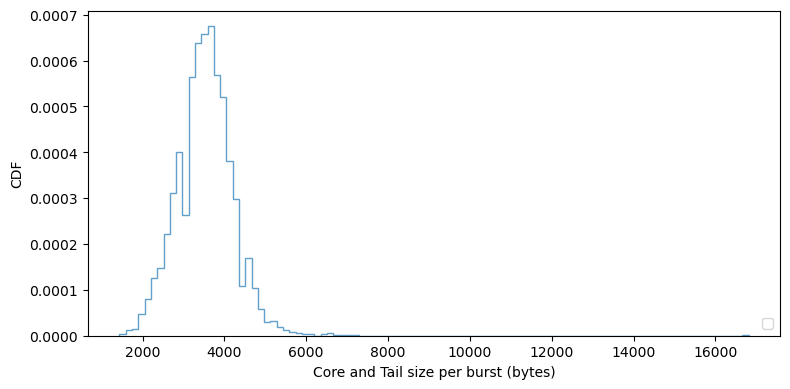

C:\Users\Yongkang.Liu\AppData\Local\Temp\1\ipykernel_5648\420622976.py:55: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
C:\Users\Yongkang.Liu\AppData\Local\Temp\1\ipykernel_5648\420622976.py:68: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)


Sim data size:  9017


In [64]:
## Simulate the DS traffic at a specific Application State

# pick the app state
sim_app_state = 2

# plot the cdf of the frame size at the selected state
fig, ax = plt.subplots(figsize=(8, 4))
num_bins = 100

lst_core_tail_sum_size_selected = list_of_lst_core_tail_sum_size[sim_app_state]
# lst_core_tail_sum_size_selected = [i for i in lst_core_tail_sum_size_selected if i < 7200]

# plot the histogram
n, bins, patches = ax.hist(lst_core_tail_sum_size_selected, num_bins, 
#                            range=[-0.005, 20000], 
#                            range=[1400, 5000], 
                            density = 1, histtype='step', 
#                             color =color_vec[sim_app_state],
                           cumulative=False,
                            alpha = 0.7)
plt.xlabel('Core and Tail size per burst (bytes)')
plt.ylabel('CDF')
plt.legend(loc='lower right') #(loc='upper right') 
plt.show()

sim_mat = [] # store the simulated frame size and time instances per the distribution of the samples

## Obtain Burst size CDF lists
lst_burst_size_selected = list_of_lst_core_tail_sum_size[sim_app_state]
lst_burst_size_vals = np.sort(lst_burst_size_selected)
# calculate the proportional values of samples
lst_burst_size_probs = 1. * np.arange(len(lst_burst_size_selected)) / (len(lst_burst_size_selected) - 1)


## Obtain IBT CDF lists
lst_ibt_selected = lst_core_interval
lst_ibt_vals = np.sort(lst_ibt_selected)
lst_ibt_probs = 1. * np.arange(len(lst_ibt_selected)) / (len(lst_ibt_selected) - 1)

# Step 1. Determine the initial frame size
# Generate a random number, and pick the initial frame size according to the ECDF distribution

# print("Step 1: Initial frame size")
frame_size_curr_idx = rand_index_gen(lst_burst_size_probs)
frame_size_curr = lst_burst_size_vals[frame_size_curr_idx]
# print("Initial frame size is ", frame_size_curr)

frame_time_curr = 0

# Save the first generated frame info
sim_mat.append([frame_time_curr, frame_size_curr])

# Create the following frames
# Determine the interval length from the current frame to the next frame 
frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
# frame_time_next = frame_time_curr + 0.033 #frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
# print("Current frame time: {}, Next frame time: {}".format(frame_time_curr, frame_time_next))

sim_time_stop = 300

while frame_time_curr <= sim_time_stop:
#     print("Generate frame at {} with size {}".format(frame_time_curr, frame_size_curr))
    sim_mat.append([frame_time_curr, frame_size_curr])
  
    frame_size_curr = lst_burst_size_vals[rand_index_gen(lst_burst_size_probs)]
    
    frame_time_curr = frame_time_next
    frame_time_next = frame_next_time_gen_ds(frame_time_curr, lst_ibt_probs, lst_ibt_vals)
#     frame_time_next = frame_time_curr + 0.033
    
    
print('Sim data size: ', len(sim_mat))

In [65]:
sim_mat[:10]

[[0, 3610],
 [0, 3610],
 [0.03365, 2362],
 [0.06617, 3657],
 [0.09968, 3657],
 [0.13319, 3657],
 [0.1667, 3340],
 [0.20056, 4860],
 [0.2345, 3301],
 [0.2681, 4231]]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


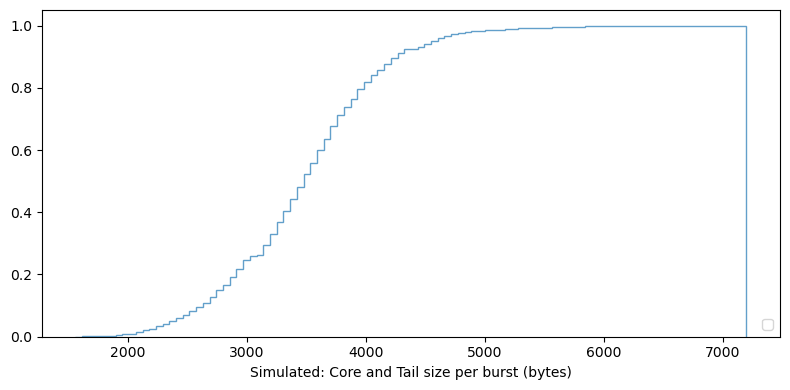

In [66]:
# Plot the burst size distribution in the simulated data set

lst_sim_size = [i[1] for i in sim_mat]

fig, ax = plt.subplots(figsize=(8, 4))

num_bins = 100

# plot the histogram
n, bins, patches = ax.hist(lst_sim_size, num_bins, 
#                            range=[-0.005, 20000], 
#                            range=[1400, 5000], 
                            density = 1, histtype='step', 
#                             color =color_vec[plot_index],
#                            label = ["", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                           cumulative=True,
                            alpha = 0.7)


#plot the cumulative histogram
#     n, bins, patches = ax.hist(list_of_lst_core_tail_sum_size[phase_state], num_bins, density=True, histtype='step',
#                                cumulative=True, label='Empirical')


plt.xlabel('Simulated: Core and Tail size per burst (bytes)')
# plt.ylabel('Y-Axis')

# title_print = "State {}, {}\n sample count: {}".format(phase_state, phase_state_term, \
#                                                                       len(list_of_lst_core_tail_sum_size[phase_state]))

# plt.title(title_print,
#           fontweight = "bold")
plt.legend(loc='lower right') #(loc='upper right') 
plt.show()

In [68]:
lst_phase_record

[[0.5, 30, 0],
 [30.5, 60, 1],
 [60, 110, 2],
 [123, 134.5, 3],
 [136, 151, 2],
 [152.5, 170, 4],
 [175, 186, 2],
 [191, 201, 2],
 [211, 230, 4],
 [236, 251, 2],
 [255, 259, 2],
 [261, 271, 2],
 [273, 290, 3],
 [291, 330, 2],
 [330, 450, 5],
 [450, 480, 6],
 [482, 540, 2],
 [540, 570, 7],
 [570, 600, 2],
 [600, 660, 7],
 [660, 680, 2]]

In [69]:
# To compare the simulated traffic with the actual traffic measured in the link (named benchmark, or bench here)
# Obtain all bench traffic data segment from the measured data
list_of_lst_time_ranges_state = []
for i in lst_phase_record:
    if i[2] == sim_app_state:
        list_of_lst_time_ranges_state.append([i[0], i[1]])
        
print("State {} data in the time segments: {}".format(sim_app_state, list_of_lst_time_ranges_state))

State 2 data in the time segments: [[60, 110], [136, 151], [175, 186], [191, 201], [236, 251], [255, 259], [261, 271], [291, 330], [482, 540], [570, 600], [660, 680]]


In [70]:
# Get throughput of the selected data stream

segment_start_time_shift = 0

ana_mat_bench = []

for i in range(len(list_of_lst_time_ranges_state)):
    
    i_start_t = list_of_lst_time_ranges_state[i][0]
    i_end_t = list_of_lst_time_ranges_state[i][1]
    print("collecting in State {}, Segment {}: from {} to {}".format(sim_app_state, i, i_start_t, i_end_t))
    
    ana_mat_bench_i = [j for j in ana_mat_burst \
                     if j[cols["data.type.name"]] in ["core", "tail"] \
                    and j[cols["frame.time_epoch"]] > i_start_t \
                     and j[cols["frame.time_epoch"]] < i_end_t ]
    
    if i > 0:
        # for a new segment of traffic, their timestamp will be shifted
        # The new start time will reference the last timestamp in the previous segement
        # a 33.3 msec interval is added    
        segment_start_time_shift = ana_mat_bench[-1][0] + 0.0333 
        
    segment_start_time_origin = ana_mat_bench_i[0][cols["frame.time_epoch"]]
    for j in ana_mat_bench_i:
        tmp_j = [j[cols["frame.time_epoch"]]-segment_start_time_origin+segment_start_time_shift, j[cols["data.len"]]]
        ana_mat_bench.append(tmp_j)
        
    print("Collected frame counts: {}", len(ana_mat_bench))
    

collecting in State 2, Segment 0: from 60 to 110
Collected frame counts: {} 5639
collecting in State 2, Segment 1: from 136 to 151
Collected frame counts: {} 7328
collecting in State 2, Segment 2: from 175 to 186
Collected frame counts: {} 8523
collecting in State 2, Segment 3: from 191 to 201
Collected frame counts: {} 9601
collecting in State 2, Segment 4: from 236 to 251
Collected frame counts: {} 11266
collecting in State 2, Segment 5: from 255 to 259
Collected frame counts: {} 11710
collecting in State 2, Segment 6: from 261 to 271
Collected frame counts: {} 12886
collecting in State 2, Segment 7: from 291 to 330
Collected frame counts: {} 17222
collecting in State 2, Segment 8: from 482 to 540
Collected frame counts: {} 24074
collecting in State 2, Segment 9: from 570 to 600
Collected frame counts: {} 27640
collecting in State 2, Segment 10: from 660 to 680
Collected frame counts: {} 30121


[1154.96, 1196.488, 747.288, 778.632, 809.648, 799.52, 711.808, 802.712, 850.096, 790.408]
Figure saved as  Packet TransmissionsData Type_80:23


<Figure size 1200x800 with 0 Axes>

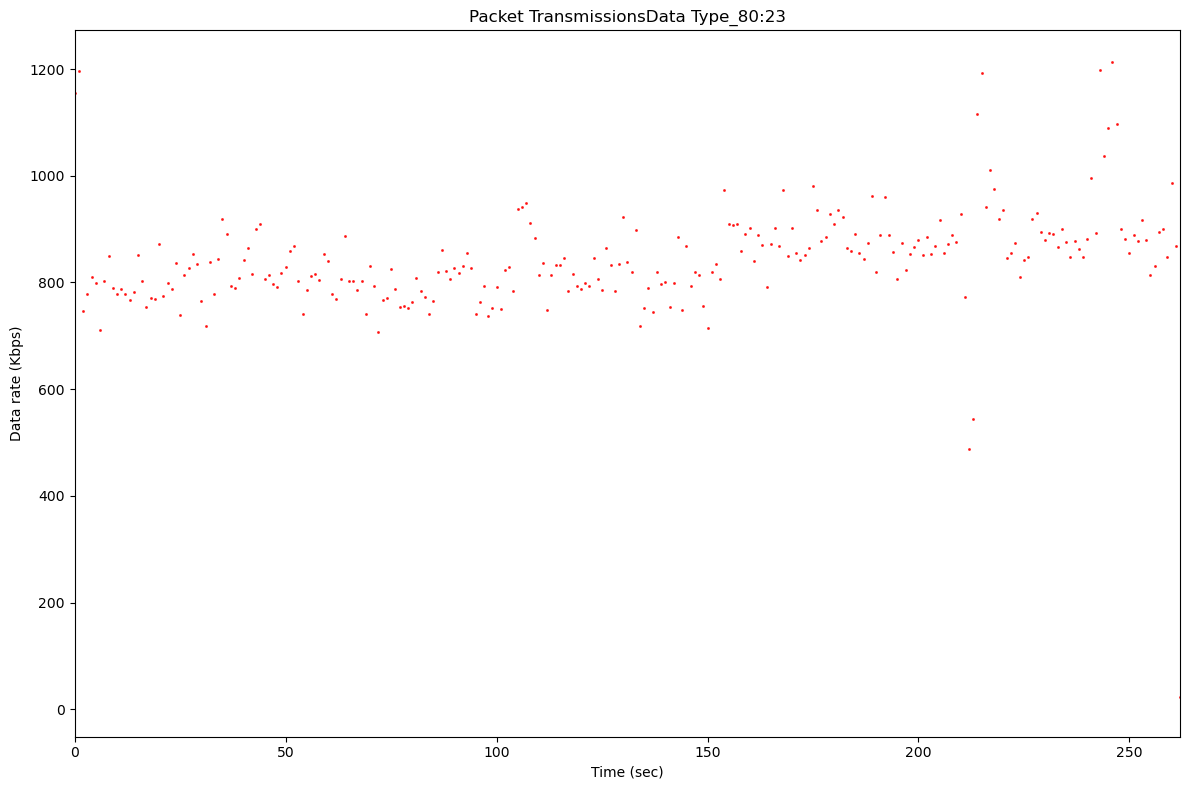

In [71]:
# Throughput of the selected data stream

# Pick only 
# ana_mat_bench = [i for i in ana_mat_burst \
#                  if i[cols["data.type.name"]] in ["core", "tail"] \
#                     and i[cols["frame.time_epoch"]] > state_start_time \
#                      and i[cols["frame.time_epoch"]] < state_end_time ]

start_time = ana_mat_bench[0][0]
ana_mat_bench_t0 = []
for i in ana_mat_bench:
    tmp_i = i.copy()
    tmp_i[0] = i[0] - start_time
    ana_mat_bench_t0.append(tmp_i)

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(ana_mat_bench_t0[-1][0]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in ana_mat_bench_t0:
    len_tmp = int(i[1])
    time_tmp = i[0]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

print(lst_rate_kbps[:10])

lst_rate_kbps_bench = []
for i in lst_rate_kbps:
    lst_rate_kbps_bench.append(i)


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = ana_mat_bench_t0[-1][0]#state_end_time - state_start_time#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")


[793.28, 781.552, 865.544, 827.152, 810.584, 809.848, 845.928, 861.416, 845.024, 835.696]
Figure saved as  Packet TransmissionsData Type_80:23


<Figure size 1200x800 with 0 Axes>

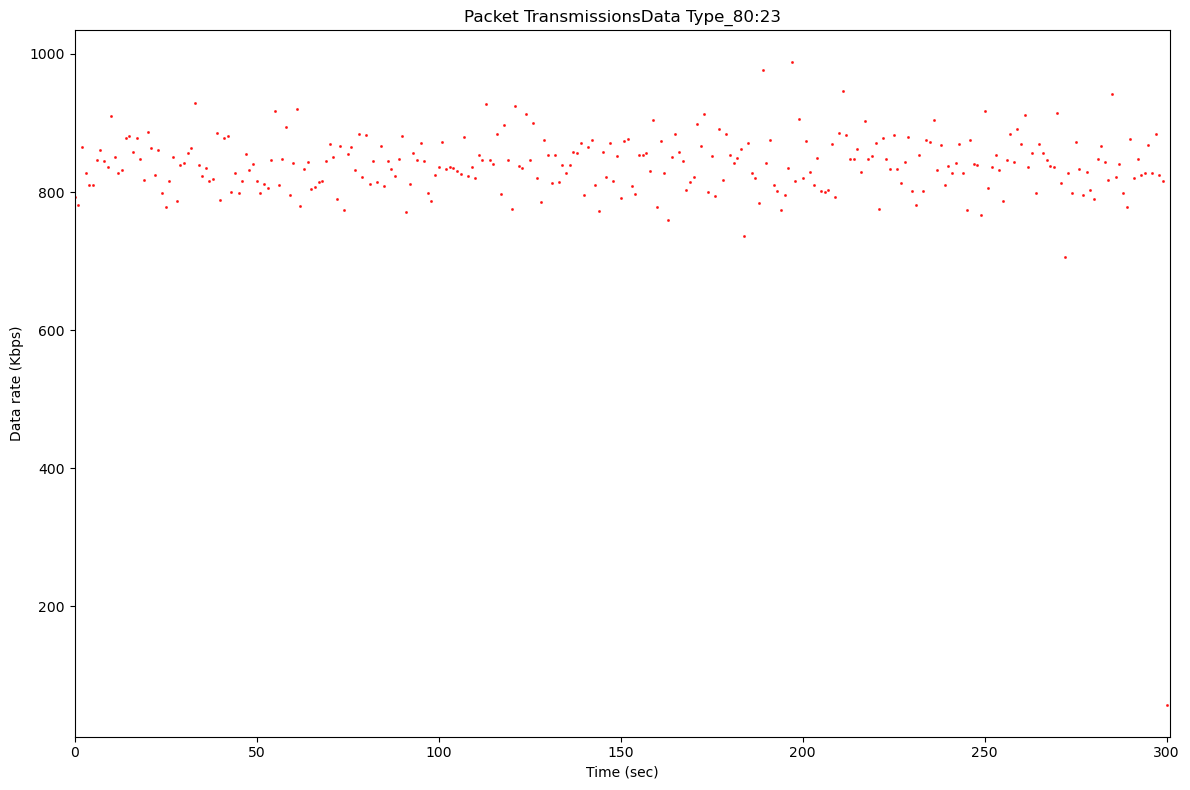

In [72]:
# Throughput of the simulated data stream

# # Pick only 
# ana_mat_bench = [i for i in ana_mat_burst \
#                  if i[cols["data.type.name"]] in ["core", "tail"] \
#                     and i[cols["frame.time_epoch"]] > 450 \
#                      and i[cols["frame.time_epoch"]] < 480 ]

# start_time = ana_mat_bench[0][cols["frame.time_epoch"]]
# ana_mat_bench_t0 = []
# for i in ana_mat_bench:
#     tmp_i = i.copy()
#     tmp_i[cols["frame.time_epoch"]] = i[cols["frame.time_epoch"]] - start_time
#     ana_mat_bench_t0.append(tmp_i)

import math

step = 1 #sec

start_time = 0
end_time = math.ceil(sim_mat[-1][0]) + 1
arr_time = np.arange(start_time, end_time, step = step)
arr_time[1]

# for i in arr_time:
#     print(i)
    
lst_byte = [0 for i in range(len(arr_time))]

# print(lst_rate)

import math

for i in sim_mat:
    len_tmp = i[1]#int(i[cols["data.len"]])
    time_tmp = i[0]#i[cols["frame.time_epoch"]]
    idx = math.ceil(time_tmp / step)
    lst_byte[idx-1] += len_tmp
    
# print(lst_byte[300:350])

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_kbps_sim = []
for i in lst_rate_kbps:
    lst_rate_kbps_sim.append(i)

print(lst_rate_kbps[:10])


# print("After:", lst_rate_kbps[300:350])

# pic_title = "Link: "+stream_dir_list[stream_id]

pic_title = "Packet Transmissions" + "Data Type" + str_displayed_data_type
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = end_time - start_time #40#pcap_end_time
scatterplot(arr_time, lst_rate_kbps, x_xlim=[x_min_display, x_max_display], \
#             y_ylim=[0, 30], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")


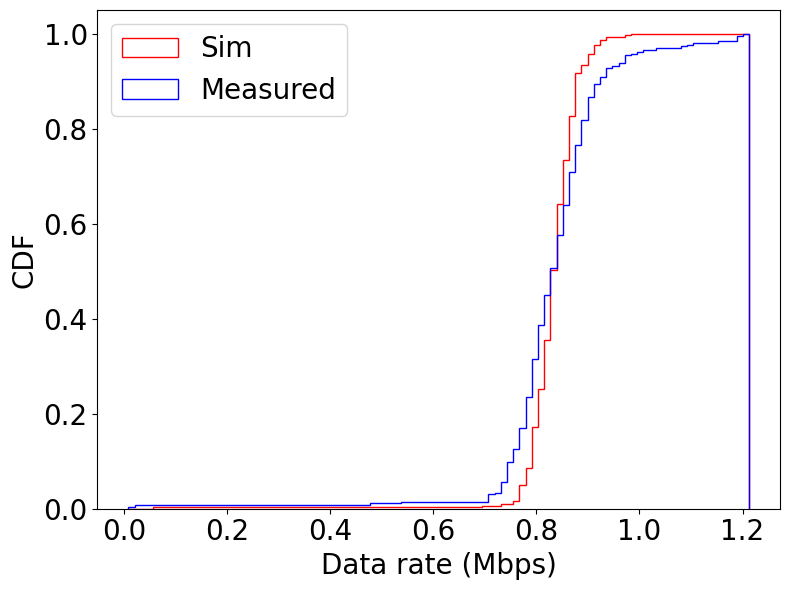

In [73]:
list_of_lst_rate_kbps = [lst_rate_kbps_bench, lst_rate_kbps_sim]
color_vec = ["b", "r"]

list_of_lst_rate_mbps = []

for i in list_of_lst_rate_kbps:
    i_mbps = [j/1000 for j in i]
    list_of_lst_rate_mbps.append(i_mbps)

fig, ax = plt.subplots(figsize=(8, 6))

num_bins = 100

# plot the histogram
n, bins, patches = ax.hist(list_of_lst_rate_mbps, num_bins, 
#                            range=[-0.005, 20000], 
#                            range=[1400, 5000], 
                            density = 1, histtype='step', 
                            color =color_vec,
                           label = ["Measured", "Sim"],
#                            label = ["", "$AS_1$", "$AS_2$", "$AS_3$", "$AS_4$", "$AS_5$", "$AS_6$", "$AS_7$"],
                           cumulative=True,
                            alpha = 1)


ax.set_xlabel("Data rate (Mbps)", fontsize = 20)
ax.set_ylabel("CDF", color='k', fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
# ax1.set_ylim([0, 0.06])
# plt.xlabel('Data rate (kbps)')
# plt.ylabel('Y-Axis')


plt.legend(loc='upper left', fontsize=20) #(loc='upper right') 
plt.show()

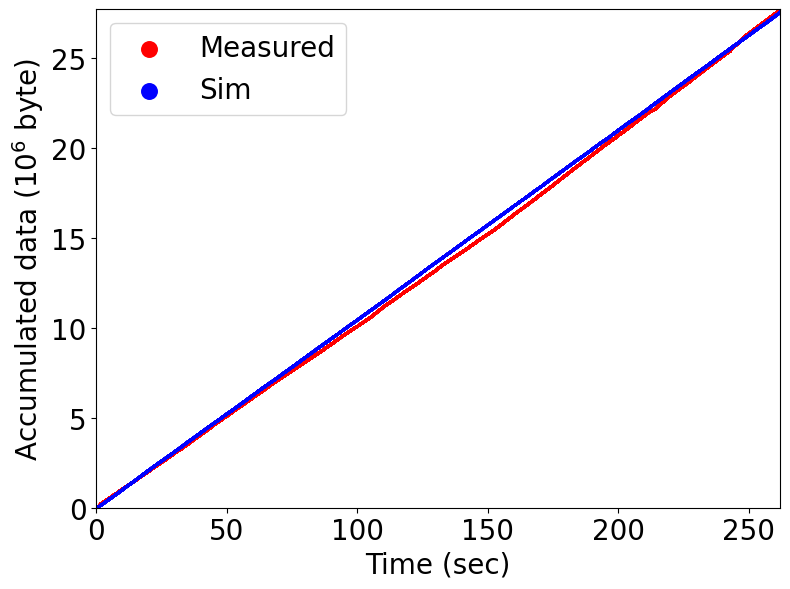

In [74]:
lst_sim_time_to_sec = [i[0] for i in sim_mat]
size_accum = 0
lst_sim_size_accum = []
for i in sim_mat:
    size_accum += i[1]
    lst_sim_size_accum.append(size_accum)
    

lst_bench_time = [i[0] for i in ana_mat_bench_t0]
size_accum = 0
lst_bench_size_accum = []
for i in ana_mat_bench_t0:
    size_accum += int(i[1])
    lst_bench_size_accum.append(size_accum)

# def scatterplot(x_data, y_data, x_xlim=[0, 0], x_label="", y_label="", \
#                 title="", color = "r", yscale_log=False, figSave=False, fig_index=""):

# Create the plot object
_, ax = plt.subplots(figsize=(8, 6))

# Plot the data, set the size (s), color and transparency (alpha)
# of the points
ax.scatter(lst_bench_time, [i/1000000 for i in lst_bench_size_accum], s = 5, color = 'r', 
           label = 'Measured', alpha = 1, marker='.')


ax.scatter(lst_sim_time_to_sec, [i/1000000 for i in lst_sim_size_accum], s = 5, color = 'b', 
           label = 'Sim', alpha = 1, marker='.')


# if yscale_log == True:
#     ax.set_yscale('log')

# # Label the axes and provide a title
# ax.set_title(title)
ax.set_xlabel("Time (sec)", fontsize = 20)
ax.set_ylabel("Accumulated data ($10^6$ byte)", fontsize = 20)

ax.set_xlim(0, lst_bench_time[-1])#state_end_time-state_start_time)
ax.set_ylim(0, lst_bench_size_accum[-1]/1000000)#state_end_time-state_start_time)


ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

plt.legend(loc='upper left', fontsize=20, markerscale=10) #(loc='upper right') 
# ax.legend(fontsize = 20, bbox_to_anchor=(0.5, 0.1), loc='upper left', ncol=3, markerscale=10)

In [75]:
lst_bench_time[-1]

262.0067263202667

Figure saved as  Application Data Rate


<Figure size 1200x800 with 0 Axes>

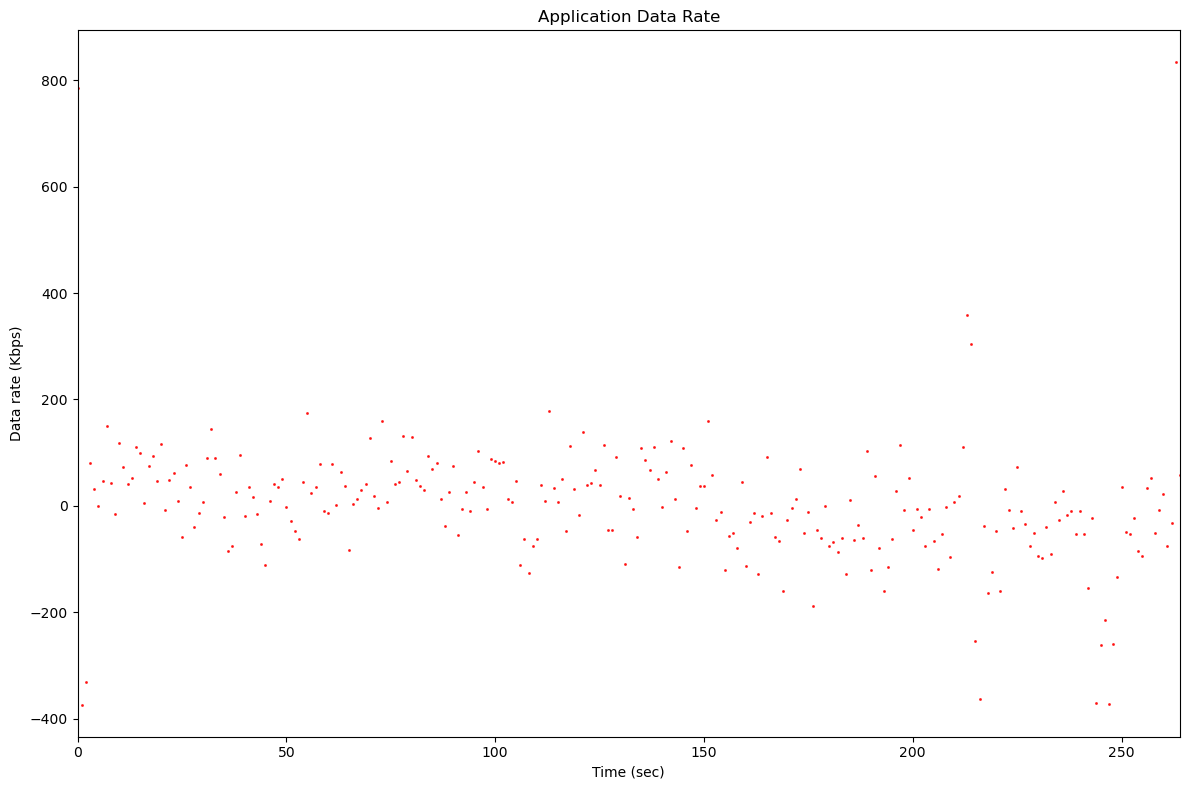

In [76]:
# Traffic load difference between the simulated and measured traffic
import math

step = 1 # sec

start_time = 0
end_time = math.ceil(lst_bench_time[-1])+1#220 # sim_mat_silent[-1][0] / 1000
arr_time = np.arange(start_time, end_time+1, step = step)
arr_time[1]


# Simulated rate   
lst_byte = [0 for i in range(len(arr_time))]
for i in sim_mat:   
    if i[0] <= end_time:
        idx = math.ceil(i[0] / step)
        lst_byte[idx-1] += i[1]

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_kbps_sim = [i for i in lst_rate_kbps]


# Measured rate
lst_byte = [0 for i in range(len(arr_time))]
for i in ana_mat_bench_t0:
    len_tmp = int(i[1])
    time_tmp = i[0]
    
    if time_tmp <= end_time:    
        idx = math.ceil(time_tmp / step)
        lst_byte[idx] += len_tmp

lst_rate_kbps = [i * 8 / step / 1000 for i in lst_byte]

lst_rate_kbps_meas = [i for i in lst_rate_kbps]


lst_rate_kbps_diff = [lst_rate_kbps_sim[i]-lst_rate_kbps_meas[i] for i in range(len(arr_time))]


    
pic_title = "Application Data Rate"
print('Figure saved as ', pic_title)
x_min_display = 0
x_max_display = end_time#pcap_end_time
scatterplot(arr_time, lst_rate_kbps_diff, x_xlim=[x_min_display, x_max_display], \
            x_label="Time (sec)", y_label="Data rate (Kbps)", title=pic_title, figSave=True, fig_index="")




In [77]:
lst_rate_kbps_diff

[784.52,
 -373.408,
 -330.9440000000001,
 79.86400000000003,
 31.951999999999998,
 0.1999999999999318,
 46.408000000000015,
 149.60800000000006,
 42.31200000000001,
 -14.399999999999977,
 119.144,
 72.65599999999995,
 40.51200000000006,
 52.88799999999992,
 111.54399999999998,
 98.60800000000006,
 6.159999999999968,
 75.22400000000005,
 94.36799999999994,
 47.76800000000003,
 117.22400000000005,
 -8.384000000000015,
 48.96799999999996,
 61.81600000000003,
 10.144000000000005,
 -58.351999999999975,
 77.10400000000004,
 36.37600000000009,
 -40.27999999999997,
 -13.912000000000035,
 7.231999999999971,
 90.59199999999998,
 144.808,
 90.79999999999995,
 60.567999999999984,
 -20.176000000000045,
 -83.976,
 -75.0,
 25.26400000000001,
 94.99199999999996,
 -19.720000000000027,
 35.247999999999934,
 16.120000000000005,
 -15.559999999999945,
 -72.21600000000001,
 -111.18399999999997,
 8.367999999999938,
 41.19200000000001,
 35.295999999999935,
 50.53600000000006,
 -2.0399999999999636,
 -29.152000

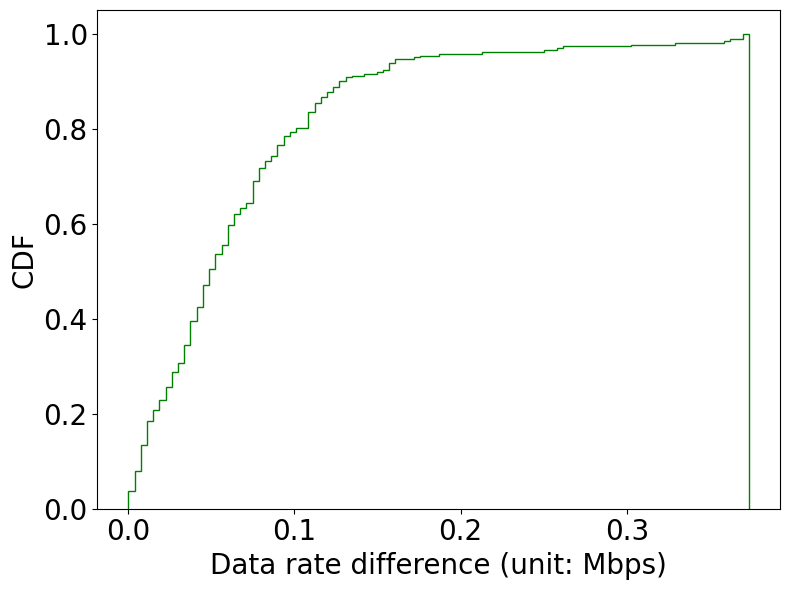

Outliers:  13


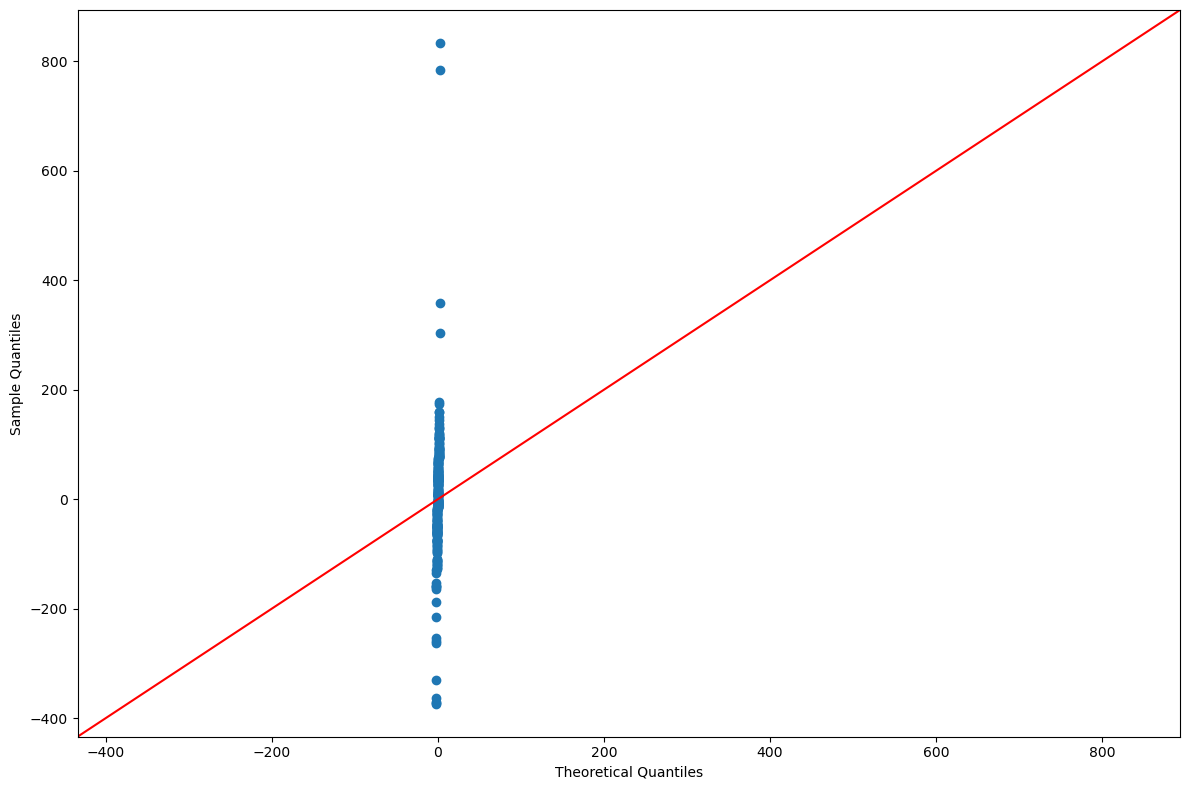

In [79]:
# We further compare the difference between the simulated and measured traffic rate

fig, ax = plt.subplots(figsize=(8, 6))

num_bins = 100

lst_rate_mbps_diff_abs = [np.abs(i)/1000 for i in lst_rate_kbps_diff[1:-3]]

 
# plot the histogram
n, bins, patches = ax.hist(lst_rate_mbps_diff_abs, num_bins,
#                            range=[.006, .012],
                            density = 1,
                            color ='green',
                           histtype='step',
                           cumulative=True,
                            alpha = 1)

# plot the cumulative histogram
# n, bins, patches = ax.hist(lst_seg_interval, num_bins, density=True, histtype='step',
#                            cumulative=True, label='Empirical')
  

plt.xlabel('Data rate difference (unit: Mbps)', fontsize=20)
plt.ylabel('CDF', fontsize=20)

# ax.set_xlim(0, 30)#state_end_time-state_start_time)
# ax.set_ylim(0, lst_bench_size_accum[-1]/1000000)#state_end_time-state_start_time)


ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

# plt.legend(loc='upper left', fontsize=20, markerscale=10) #(loc='upper right') 
 
# plt.title('Histogram of data rate difference between the measured and simulated traffics\n',
#           fontweight = "bold")
 
plt.show()

lst_rate_kbps_diff_outliers = [i for i in lst_rate_kbps_diff if i < -200 or i > 200]
print("Outliers: ", len(lst_rate_kbps_diff_outliers))



import statsmodels.api as sm

lst_frame_interval_select_qqplot = lst_rate_kbps_diff.copy()

lst_frame_interval_select_qqplot.sort()

data = np.array(lst_frame_interval_select_qqplot)

fig = sm.qqplot(data, line='45')
plt.show()

#The Q-Q plot indicates the inter-burst time is not normally distributed.

In [80]:
ana_mat_bench = [i for i in ana_mat_burst \
                 if i[cols["data.type.name"]] in ["core", "tail"] \
                    and i[cols["frame.time_epoch"]] > 450 \
                     and i[cols["frame.time_epoch"]] < 480 ]

In [81]:
len(ana_mat_burst)

103844

# End of Analysis Report